# Laboratorio 3
### Majo Gil 20337
### Joshua Chicoj 20566

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

import warnings
warnings.simplefilter('ignore')

In [2]:
data_precios = pd.read_excel('./data/PreciosCombustible.xlsx', parse_dates=['MES/AÑO'], date_format='%Y-%m', index_col='MES/AÑO')
data_gas = pd.read_excel('./data/PreciosGas.xlsx', parse_dates=['MES/AÑO'], date_format='%Y-%m', index_col='MES/AÑO')
data_impor = pd.read_excel('./data/IMPORTACION-VOLUMEN-2024-05.xlsx', parse_dates=['Fecha'], date_format='%Y-%m', index_col='Fecha')
data_consumo = pd.read_excel('./data/CONSUMO-2024-05.xlsx', parse_dates=['Fecha'], date_format='%Y-%m', index_col='Fecha')

In [3]:
data_consumo.head()

Diesel  Gas licuado de petróleo  Gasolina regular  \
Fecha                                                                       
2002-01-01 00:00:00  634667.06            194410.476190         202645.20   
2002-01-02 00:00:00  642380.66            174710.552381         205530.96   
2002-01-03 00:00:00  699807.25            189234.066667         229499.56   
2002-01-04 00:00:00  586803.98            174330.607143         210680.40   
2002-01-05 00:00:00  656948.20            191745.147619         208164.34   

                     Gasolina superior  
Fecha                                   
2002-01-01 00:00:00          308156.82  
2002-01-02 00:00:00          307766.31  
2002-01-03 00:00:00          331910.29  
2002-01-04 00:00:00          315648.08  
2002-01-05 00:00:00          319667.97

In [4]:
from typing import Tuple

def get_train_test(df: pd.DataFrame, train_proportion: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_size = int(len(df) * train_proportion)

    train_data = df[0:train_size]
    test_data = df[train_size:len(df)]
    
    return train_data, test_data

In [5]:
train_precios, test_precios = get_train_test(data_precios, train_proportion=0.7)
train_gas, test_gas = get_train_test(data_gas, train_proportion=0.7)
train_imp, test_imp = get_train_test(data_impor, train_proportion=0.7)
train_consumo, test_consumo = get_train_test(data_consumo, train_proportion=0.7)

## Comparación de modelos

In [6]:
def create_arima_model(data: pd.DataFrame, p: int, d: int, q: int, s: int = None) -> ARIMAResults:
    if s is None:
        model = ARIMA(data, order=(p, d, q))
    else:
        model = ARIMA(data, order=(p, d, q), seasonal_order=(p, d, q, s))
        
    return model.fit()

In [7]:
from sklearn.metrics import mean_squared_error

def plot_arima_eval(model: ARIMAResults, train_data: pd.DataFrame, test_data: pd.DataFrame, label: str):
    forecast = model.get_forecast(steps=len(test_data))
    forecast_series = pd.Series(forecast.predicted_mean, index=test_data.index)
    
    # Calculate the mean squared error
    mse = mean_squared_error(test_data, forecast_series)
    rmse = mse**0.5
    
    print('RMSE:', rmse)
    
    # Create a plot to compare the forecast with the actual test data
    plt.figure(figsize=(14,7))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, label='Actual Data', color='orange')
    plt.plot(forecast_series, label='Forecasted Data', color='green')
    plt.fill_between(test_data.index, 
                     forecast.conf_int().iloc[:, 0], 
                     forecast.conf_int().iloc[:, 1], 
                     color='k', alpha=.15)
    plt.title('ARIMA Model Evaluation')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.legend()
    plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def data_preprocessing(data: pd.DataFrame, d=1, sequence_length: int = 3, train_proportion: float = 0.7) -> Tuple[np.array, np.array, np.array, np.array]:
    for _ in range(d):
        data = data.diff()
        data.fillna(0, inplace=True)
    
    scaled_data = scaler.fit_transform(data)
    train_size = int(len(data) * train_proportion)
    
    train_data = scaled_data[0:train_size]
    test_data = scaled_data[train_size:]
    
    train_x, train_y = sequences_pred(train_data, sequence_length)
    test_x, test_y = sequences_pred(test_data, sequence_length)
    
    return train_x, train_y, test_x, test_y


def sequences_pred(data: pd.DataFrame, sequence_length: int = 3) -> Tuple[np.array, np.array]:
    x_serie = []
    y_serie = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        predicted_value = data[i+sequence_length]
        
        x_serie.append(seq)
        y_serie.append(predicted_value)
        
    x_serie = np.array(x_serie)
    y_serie = np.array(y_serie)
    
    return x_serie, y_serie

In [9]:
import tensorflow.keras as keras

from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

def create_lstm_model(train_x: np.array, units: list[int], dropout: list[float]) -> keras.models.Sequential:
    model = keras.models.Sequential()

    model.add(Input((train_x.shape[1],1)))

    for i in range(len(units) - 1):
        model.add(LSTM(units=units[i], return_sequences=True))
        model.add(Dropout(dropout[i]))

    model.add(LSTM(units=units[-1], return_sequences=False))
    model.add(Dropout(dropout[-1]))

    model.add(Dense(units=1))

    return model

def create_lstm_model_s(train_x: np.array) -> keras.Model:
    inputs = keras.layers.Input((train_x.shape[1],1))
    lstm_out = keras.layers.LSTM(1)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    return keras.Model(inputs=inputs, outputs=outputs)

In [10]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def get_history(model: keras.models.Sequential, train_x: np.array, train_y: np.array, name: str, epochs: int = 100, batch_size: int = 64, validation_rate: float = 0.2):
    model_checkpoint = keras.callbacks.ModelCheckpoint(f'./models/{name}.keras', monitor='val_loss', save_best_only=True)
    
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_rate, callbacks=[early_stopping, model_checkpoint], shuffle=False, verbose=2)

In [100]:
def prediccion_fun(data, modelo, batch_size, dif=False ,dif_cant=1, series=None, n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

def evaluate_model(model, history, data: pd.DataFrame, label: str, train_x: np.array,  train_y: np.array, test_x: np.array, test_y: np.array, train_proportion: float = 0.7, minus: int = 1):
    print("Pérdida en Entrenamiento")
    model.evaluate(
        x = train_x,
        y = train_y
    )
    print("Pérdida en Prueba")
    model.evaluate(
        x = test_x,
        y = test_y
    )
    
    train_size = round(train_proportion*len(data))
    prediccion_test = prediccion_fun(test_x, model, 1, dif=True, dif_cant=1, series = data.values , n=train_size)
    df_test = pd.DataFrame(prediccion_test, index=data[train_size:len(data) - minus].index)
    
    plt.figure(figsize=(14,7))
    plt.plot(data, label='Actual Data')
    plt.plot(df_test, label='Predicted Data', color='orange')
    plt.title('LSTM Model Evaluation')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.legend()
    plt.show()
    
    losses_df1 = pd.DataFrame(history.history)
    losses_df1.plot(figsize = (10,6))

### Modelos de precios de combustibles
#### Gasolina Superior
##### ARIMA

RMSE: 8.126732457393569


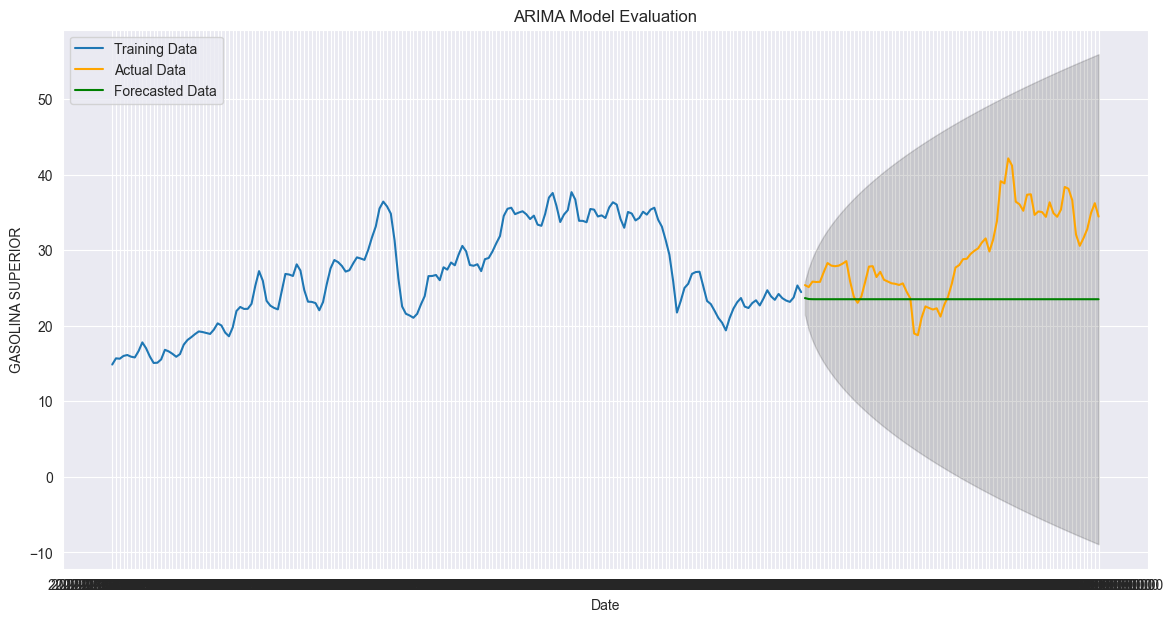

In [12]:
pgs_111 = create_arima_model(train_precios[['GASOLINA SUPERIOR']], p=1, d=1, q=1)
plot_arima_eval(pgs_111, train_precios[['GASOLINA SUPERIOR']], test_precios[['GASOLINA SUPERIOR']], 'GASOLINA SUPERIOR')

In [13]:
train_x_pgs, train_y_pgs, test_x_pgs, test_y_pgs = data_preprocessing(data_precios[['GASOLINA SUPERIOR']], sequence_length=1)

##### LSTM 1

In [14]:
pgs_1 = create_lstm_model_s(train_x_pgs)
pgs_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pgs_1_history = get_history(pgs_1, train_x_pgs, train_y_pgs, name='pgs 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.9139 - mse: 0.9139 - val_accuracy: 0.0000e+00 - val_loss: 0.9298 - val_mse: 0.9298
Epoch 2/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9008 - mse: 0.9008 - val_accuracy: 0.0000e+00 - val_loss: 0.9230 - val_mse: 0.9230
Epoch 3/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8909 - mse: 0.8909 - val_accuracy: 0.0000e+00 - val_loss: 0.9172 - val_mse: 0.9172
Epoch 4/100
137/137 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.8828 - mse: 0.8828 - val_accuracy: 0.0000e+00 - val_loss: 0.9123 - val_mse: 0.9123
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8763 - mse: 0.8763 - val_accuracy: 0.0000e+00 - val_loss: 0.9080 - val_mse: 0.9080
Epoch 6/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8707 - mse: 0.8707 - val_accuracy: 0.0000e+00 - val_loss: 0.9041 - val_mse: 0.9041
Epoch 7/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8661 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.5799 - mse: 0.5799
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.1577 - mse: 1.1577


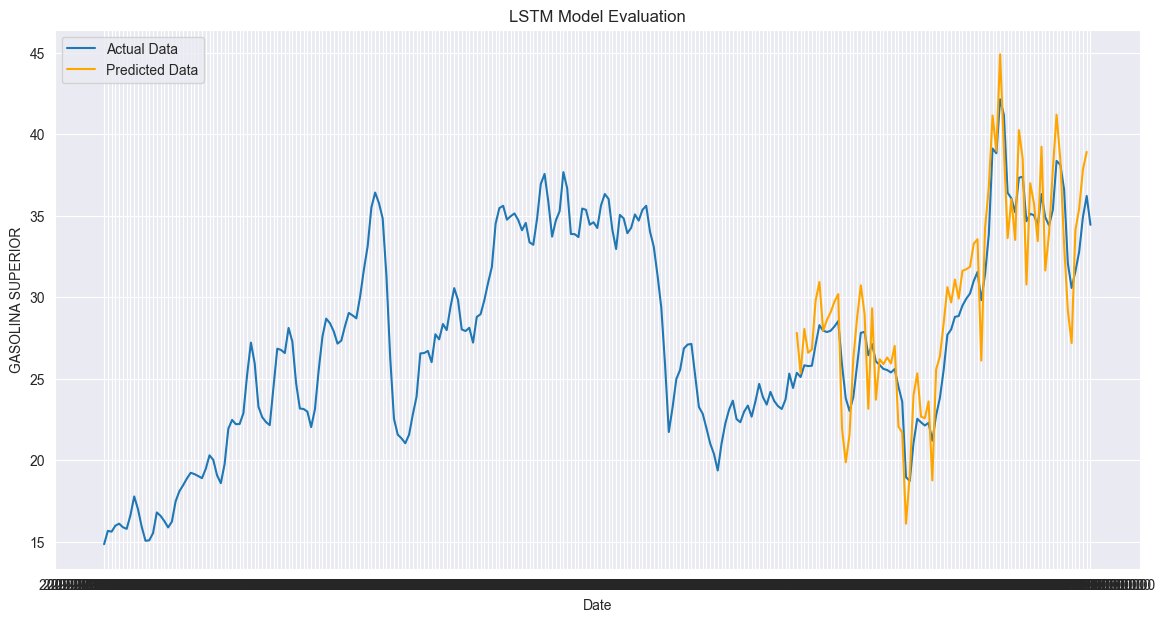

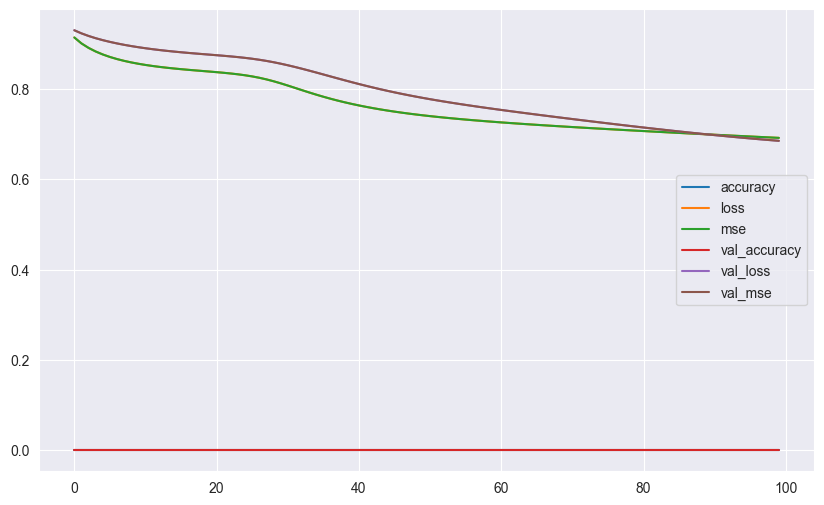

In [41]:
evaluate_model(pgs_1, pgs_1_history, data_precios['GASOLINA SUPERIOR'], 'GASOLINA SUPERIOR', train_x_pgs, train_y_pgs, test_x_pgs, test_y_pgs)

##### LSTM 2

In [15]:
pgs_2 = create_lstm_model(train_x_pgs, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
pgs_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pgs_2_history = get_history(pgs_2, train_x_pgs, train_y_pgs, name='pgs 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 7s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.8179 - mse: 0.8179 - val_accuracy: 0.0000e+00 - val_loss: 0.7848 - val_mse: 0.7848
Epoch 2/100
137/137 - 9s - 69ms/step - accuracy: 0.0000e+00 - loss: 0.7216 - mse: 0.7216 - val_accuracy: 0.0000e+00 - val_loss: 0.7008 - val_mse: 0.7008
Epoch 3/100
137/137 - 6s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.6826 - mse: 0.6826 - val_accuracy: 0.0000e+00 - val_loss: 0.6997 - val_mse: 0.6997
Epoch 4/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.6802 - mse: 0.6802 - val_accuracy: 0.0000e+00 - val_loss: 0.7088 - val_mse: 0.7088
Epoch 5/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.6777 - mse: 0.6777 - val_accuracy: 0.0000e+00 - val_loss: 0.7134 - val_mse: 0.7134
Epoch 6/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.6674 - mse: 0.6674 - val_accuracy: 0.0000e+00 - val_loss: 0.7124 - val_mse: 0.7124
Epoch 7/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.6529 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.5608 - mse: 0.5608
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1.1826 - mse: 1.1826


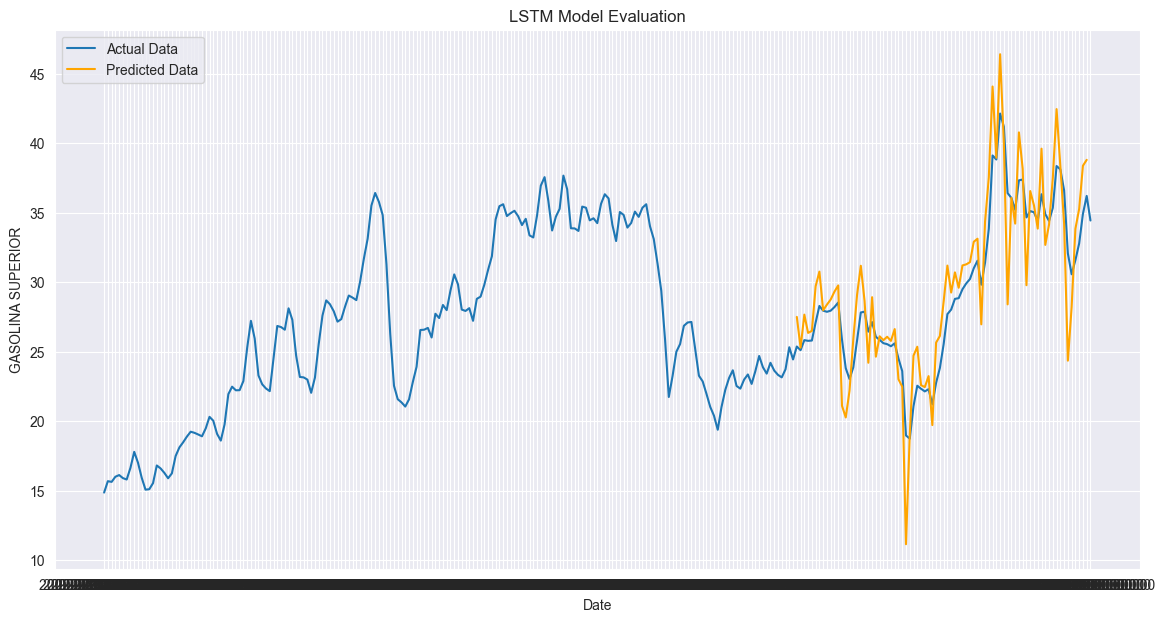

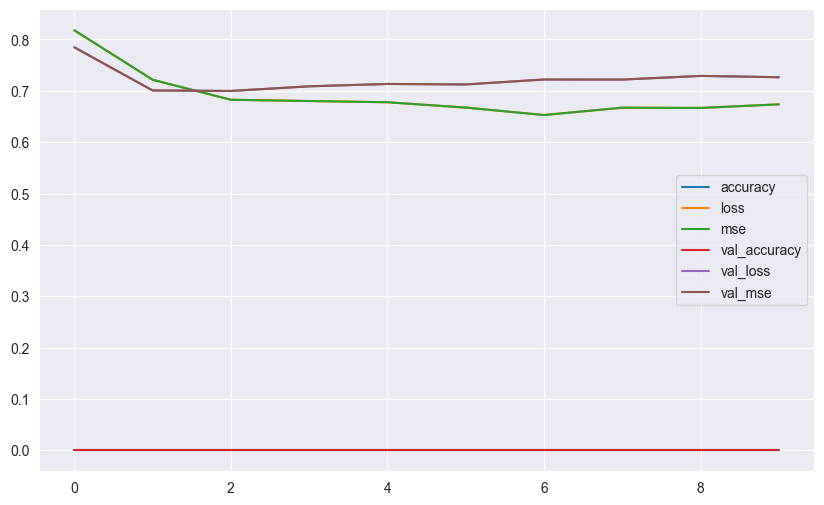

In [42]:
pgs_2_loaded = keras.models.load_model('./models/pgs 2.keras')
evaluate_model(pgs_2_loaded, pgs_2_history, data_precios['GASOLINA SUPERIOR'], 'GASOLINA SUPERIOR', train_x_pgs, train_y_pgs, test_x_pgs, test_y_pgs)

#### Gasolina Regular
##### ARIMA

RMSE: 7.441152168564744


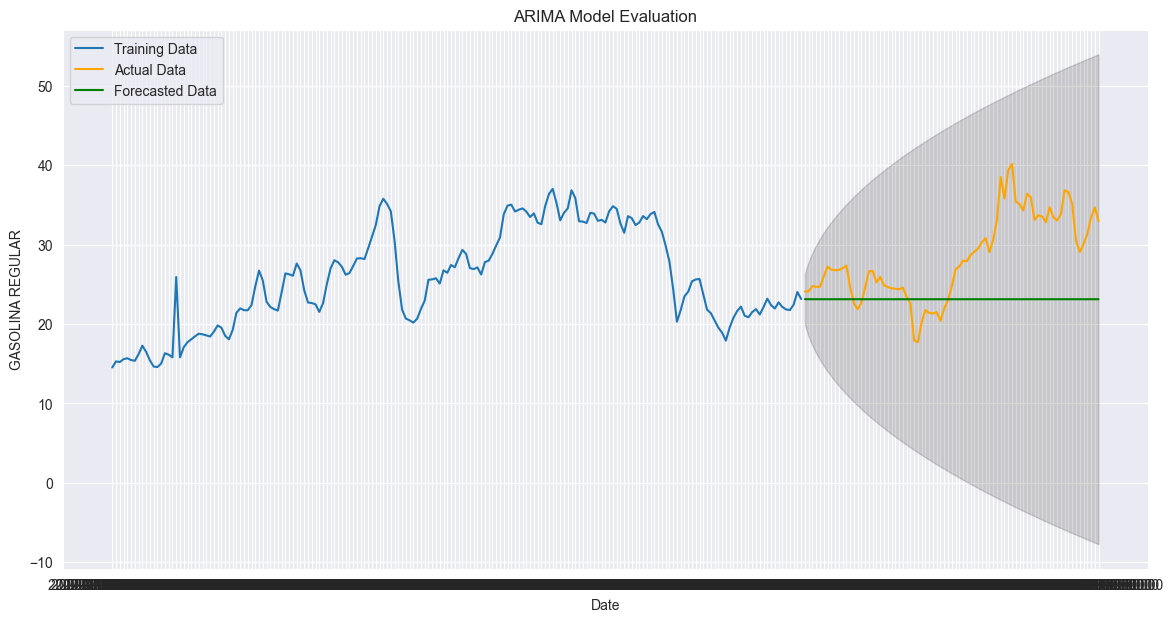

In [22]:
pgr_111 = create_arima_model(train_precios[['GASOLINA REGULAR']], p=1, d=1, q=1)
plot_arima_eval(pgr_111, train_precios[['GASOLINA REGULAR']], test_precios[['GASOLINA REGULAR']], 'GASOLINA REGULAR')

In [24]:
train_x_pgr, train_y_pgr, test_x_pgr, test_y_pgr = data_preprocessing(data_precios[['GASOLINA REGULAR']], sequence_length=1)

##### LSTM 1

In [25]:
pgr_1 = create_lstm_model_s(train_x_pgr)
pgr_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pgr_1_history = get_history(pgr_1, train_x_pgr, train_y_pgr, name='pgr 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.1708 - mse: 1.1708 - val_accuracy: 0.0000e+00 - val_loss: 0.6444 - val_mse: 0.6444
Epoch 2/100
137/137 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 1.1605 - mse: 1.1605 - val_accuracy: 0.0000e+00 - val_loss: 0.6352 - val_mse: 0.6352
Epoch 3/100
137/137 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 1.1520 - mse: 1.1520 - val_accuracy: 0.0000e+00 - val_loss: 0.6278 - val_mse: 0.6278
Epoch 4/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 1.1453 - mse: 1.1453 - val_accuracy: 0.0000e+00 - val_loss: 0.6220 - val_mse: 0.6220
Epoch 5/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 1.1403 - mse: 1.1403 - val_accuracy: 0.0000e+00 - val_loss: 0.6175 - val_mse: 0.6175
Epoch 6/100
137/137 - 3s - 23ms/step - accuracy: 0.0000e+00 - loss: 1.1368 - mse: 1.1368 - val_accuracy: 0.0000e+00 - val_loss: 0.6141 - val_mse: 0.6141
Epoch 7/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 1.1343 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.2941 - mse: 1.2941 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.9685 - mse: 0.9685


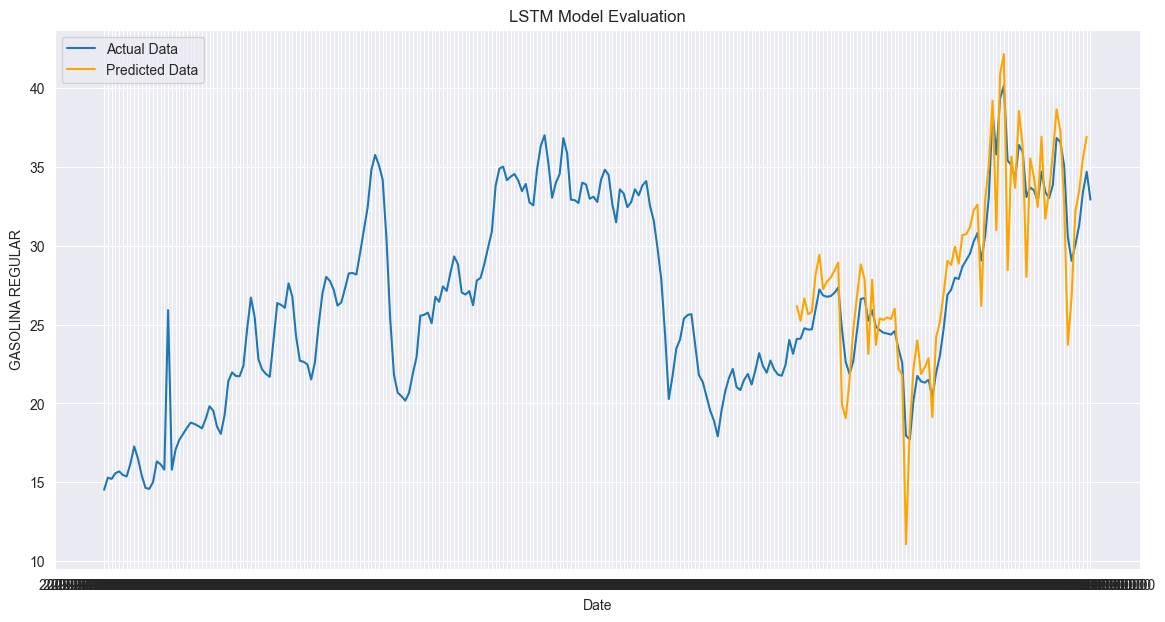

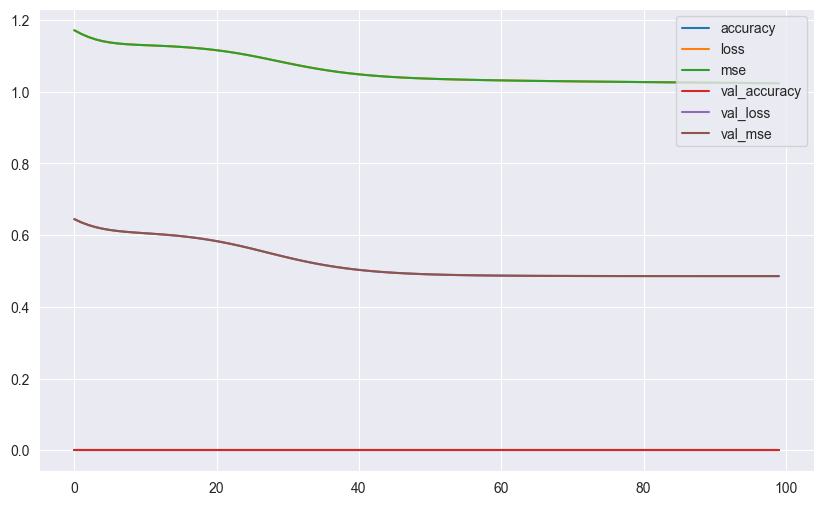

In [43]:
evaluate_model(pgr_1, pgr_1_history, data_precios['GASOLINA REGULAR'], 'GASOLINA REGULAR', train_x_pgr, train_y_pgr, test_x_pgr, test_y_pgr)

##### LSTM 2

In [27]:
pgr_2 = create_lstm_model(train_x_pgr, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
pgr_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pgr_2_history = get_history(pgr_2, train_x_pgr, train_y_pgr, name='pgr 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 1.1287 - mse: 1.1287 - val_accuracy: 0.0000e+00 - val_loss: 0.5928 - val_mse: 0.5928
Epoch 2/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 1.1322 - mse: 1.1322 - val_accuracy: 0.0000e+00 - val_loss: 0.5906 - val_mse: 0.5906
Epoch 3/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 1.1351 - mse: 1.1351 - val_accuracy: 0.0000e+00 - val_loss: 0.5844 - val_mse: 0.5844
Epoch 4/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 1.1413 - mse: 1.1413 - val_accuracy: 0.0000e+00 - val_loss: 0.5826 - val_mse: 0.5826
Epoch 5/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 1.1312 - mse: 1.1312 - val_accuracy: 0.0000e+00 - val_loss: 0.5722 - val_mse: 0.5722
Epoch 6/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 1.1327 - mse: 1.1327 - val_accuracy: 0.0000e+00 - val_loss: 0.5644 - val_mse: 0.5644
Epoch 7/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 1.1096 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 1.3013 - mse: 1.3013
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.9172 - mse: 0.9172


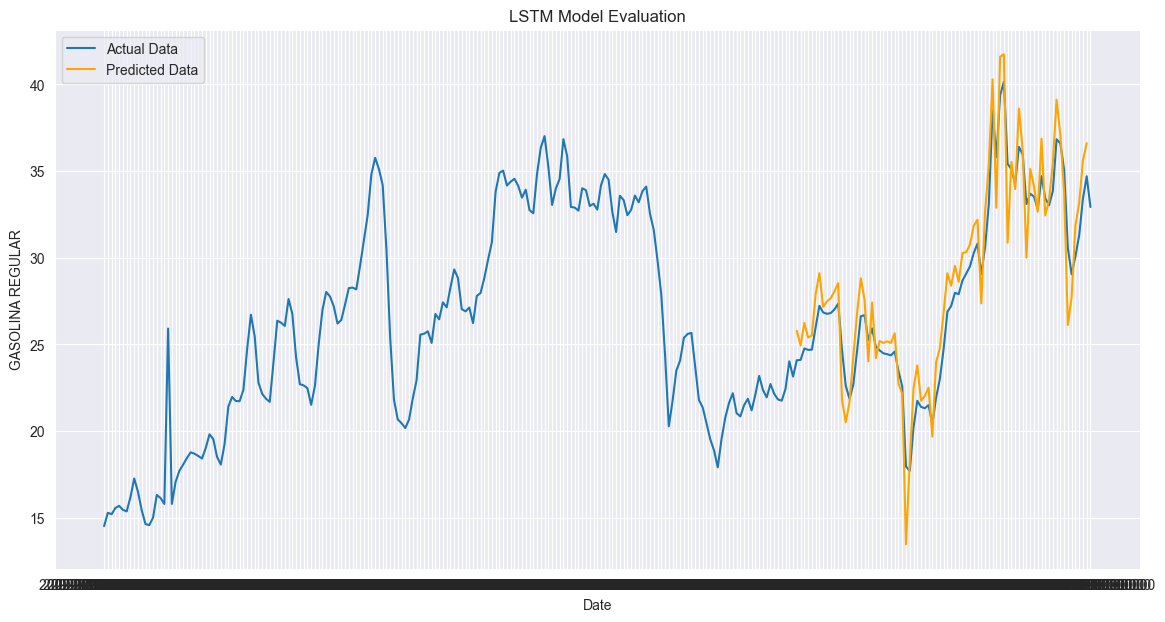

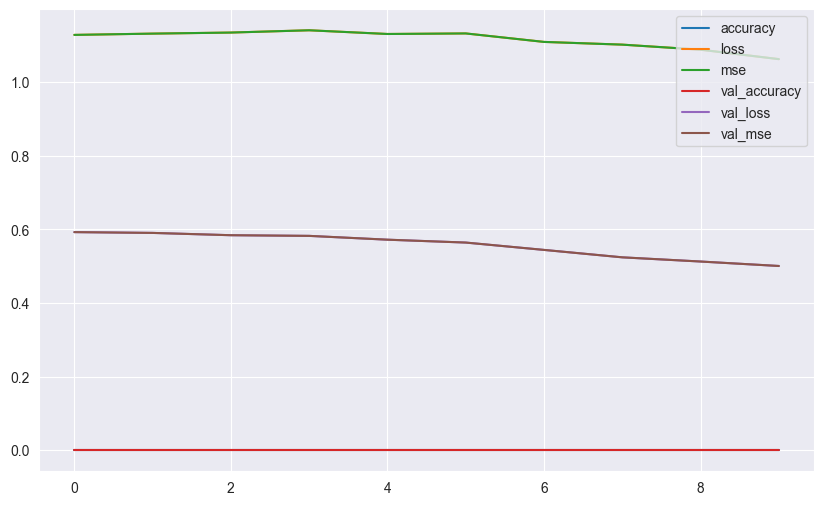

In [44]:
pgr_2_loaded = keras.models.load_model('./models/pgr 2.keras')
evaluate_model(pgr_2_loaded, pgr_2_history, data_precios['GASOLINA REGULAR'], 'GASOLINA REGULAR', train_x_pgr, train_y_pgr, test_x_pgr, test_y_pgr)

#### Aceite Combustible Diesel
##### ARIMA

RMSE: 8.098845641972764


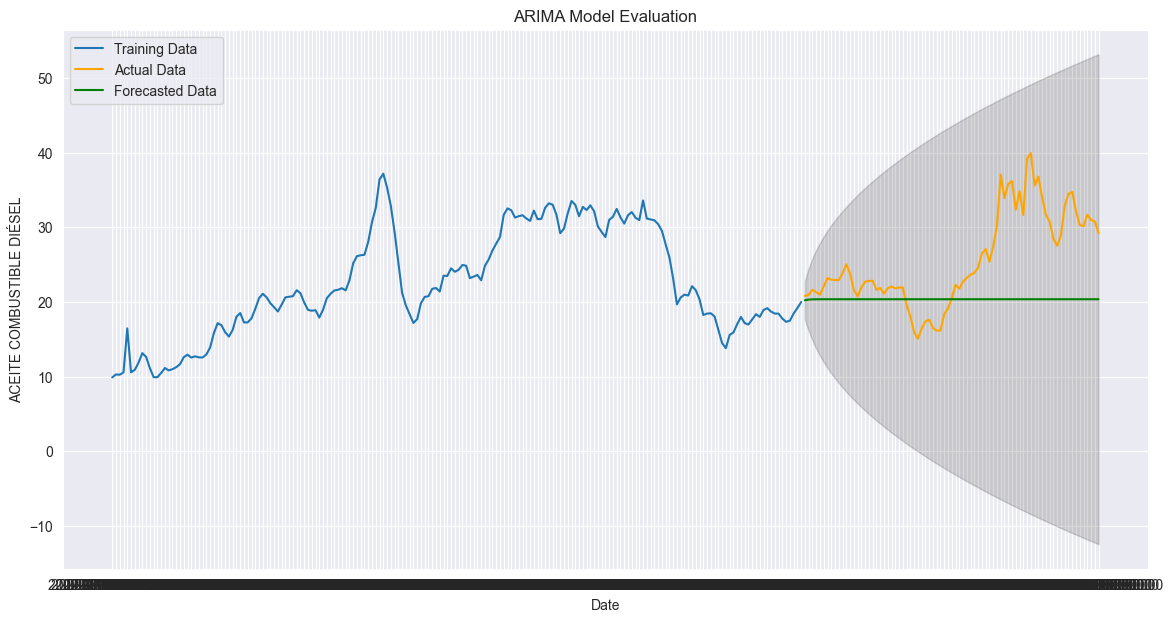

In [23]:
pacd_211 = create_arima_model(train_precios[['ACEITE COMBUSTIBLE DIÉSEL']], p=2, d=1, q=1)
plot_arima_eval(pacd_211, train_precios[['ACEITE COMBUSTIBLE DIÉSEL']], test_precios[['ACEITE COMBUSTIBLE DIÉSEL']], 'ACEITE COMBUSTIBLE DIÉSEL')

In [29]:
train_x_pd, train_y_pd, test_x_pd, test_y_pd = data_preprocessing(data_precios[['ACEITE COMBUSTIBLE DIÉSEL']], sequence_length=1)

##### LSTM 1

In [31]:
pd_1 = create_lstm_model_s(train_x_pd)
pd_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pd_1_history = get_history(pd_1, train_x_pd, train_y_pd, name='pd 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.9667 - mse: 0.9667 - val_accuracy: 0.0000e+00 - val_loss: 0.6855 - val_mse: 0.6855
Epoch 2/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9411 - mse: 0.9411 - val_accuracy: 0.0000e+00 - val_loss: 0.6827 - val_mse: 0.6827
Epoch 3/100
137/137 - 3s - 23ms/step - accuracy: 0.0000e+00 - loss: 0.9207 - mse: 0.9207 - val_accuracy: 0.0000e+00 - val_loss: 0.6805 - val_mse: 0.6805
Epoch 4/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.9037 - mse: 0.9037 - val_accuracy: 0.0000e+00 - val_loss: 0.6788 - val_mse: 0.6788
Epoch 5/100
137/137 - 3s - 23ms/step - accuracy: 0.0000e+00 - loss: 0.8893 - mse: 0.8893 - val_accuracy: 0.0000e+00 - val_loss: 0.6771 - val_mse: 0.6771
Epoch 6/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8767 - mse: 0.8767 - val_accuracy: 0.0000e+00 - val_loss: 0.6755 - val_mse: 0.6755
Epoch 7/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8653 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.9327 - mse: 0.9327 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.3622 - mse: 1.3622 


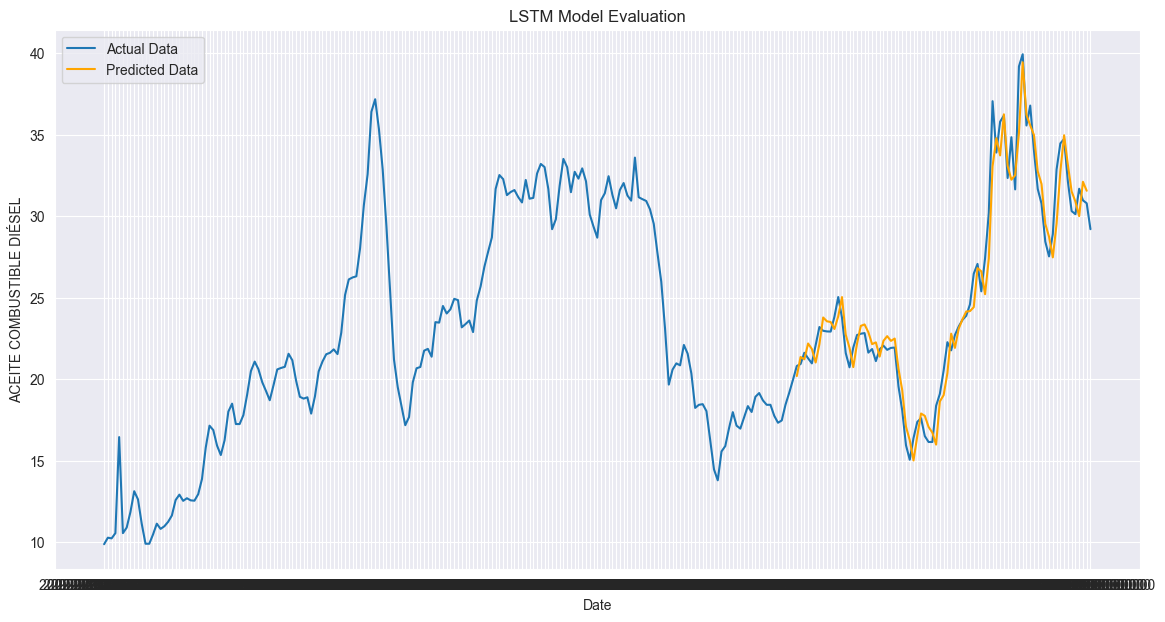

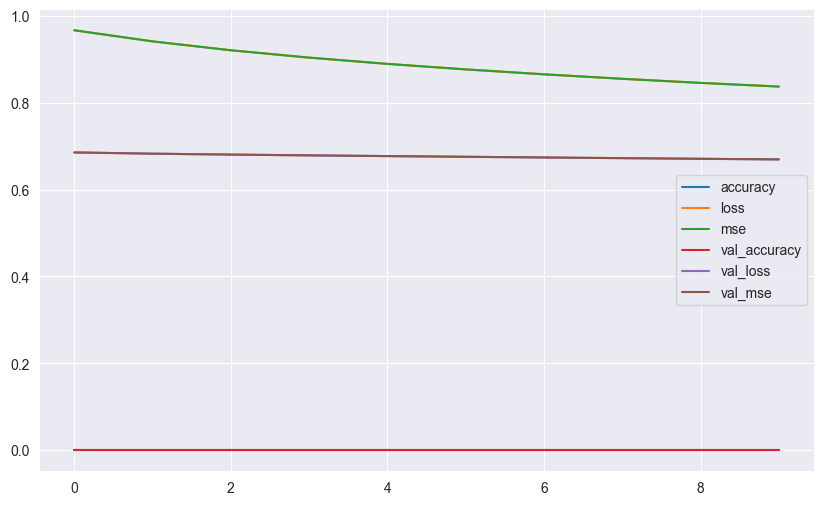

In [45]:
evaluate_model(pd_1, pd_1_history, data_precios['ACEITE COMBUSTIBLE DIÉSEL'], 'ACEITE COMBUSTIBLE DIÉSEL', train_x_pd, train_y_pd, test_x_pd, test_y_pd)

##### LSTM 2

In [33]:
pd_2 = create_lstm_model(train_x_pd, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
pd_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
pd_2_history = get_history(pd_2, train_x_pd, train_y_pd, name='pd 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.8282 - mse: 0.8282 - val_accuracy: 0.0000e+00 - val_loss: 0.6134 - val_mse: 0.6134
Epoch 2/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.8132 - mse: 0.8132 - val_accuracy: 0.0000e+00 - val_loss: 0.5886 - val_mse: 0.5886
Epoch 3/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.7933 - mse: 0.7933 - val_accuracy: 0.0000e+00 - val_loss: 0.5742 - val_mse: 0.5742
Epoch 4/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.7840 - mse: 0.7840 - val_accuracy: 0.0000e+00 - val_loss: 0.5654 - val_mse: 0.5654
Epoch 5/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.7651 - mse: 0.7651 - val_accuracy: 0.0000e+00 - val_loss: 0.5665 - val_mse: 0.5665
Epoch 6/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.7569 - mse: 0.7569 - val_accuracy: 0.0000e+00 - val_loss: 0.5676 - val_mse: 0.5676
Epoch 7/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.7551 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.7832 - mse: 0.7832
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 1.5056 - mse: 1.5056


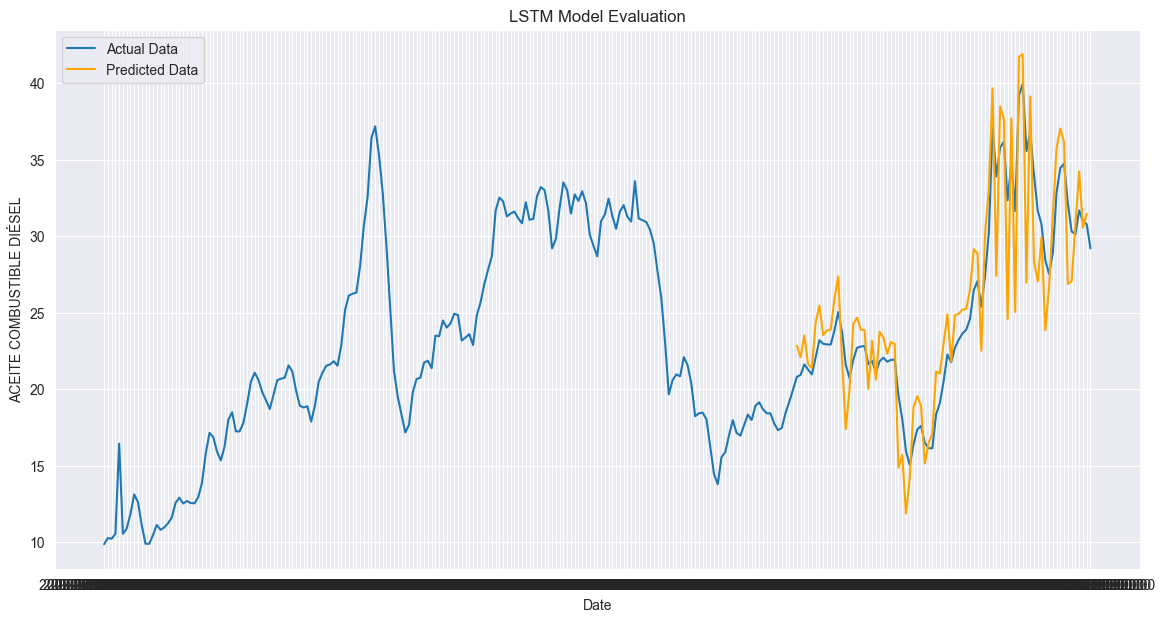

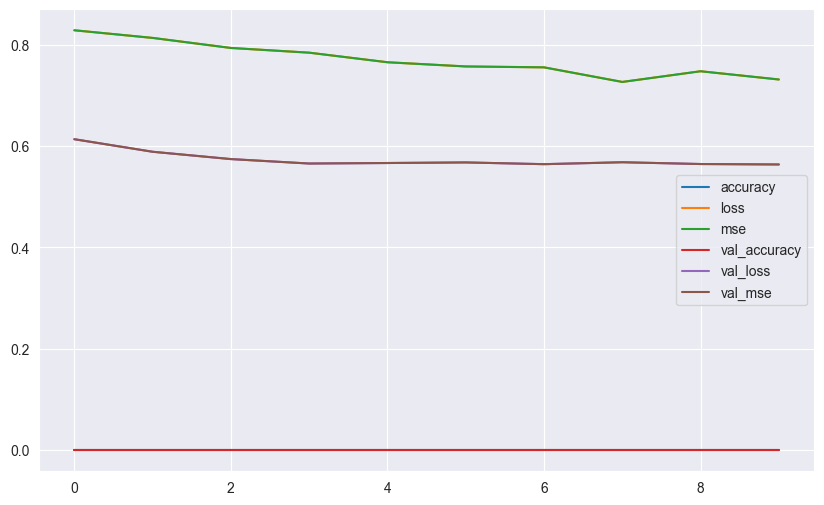

In [46]:
pd_2_loaded = keras.models.load_model('./models/pd 2.keras')
evaluate_model(pd_2_loaded, pd_2_history, data_precios['ACEITE COMBUSTIBLE DIÉSEL'], 'ACEITE COMBUSTIBLE DIÉSEL', train_x_pd, train_y_pd, test_x_pd, test_y_pd)

### Modelos de precios de gas
#### Gas 25lbs
##### ARIMA

RMSE: 16.491312288920497


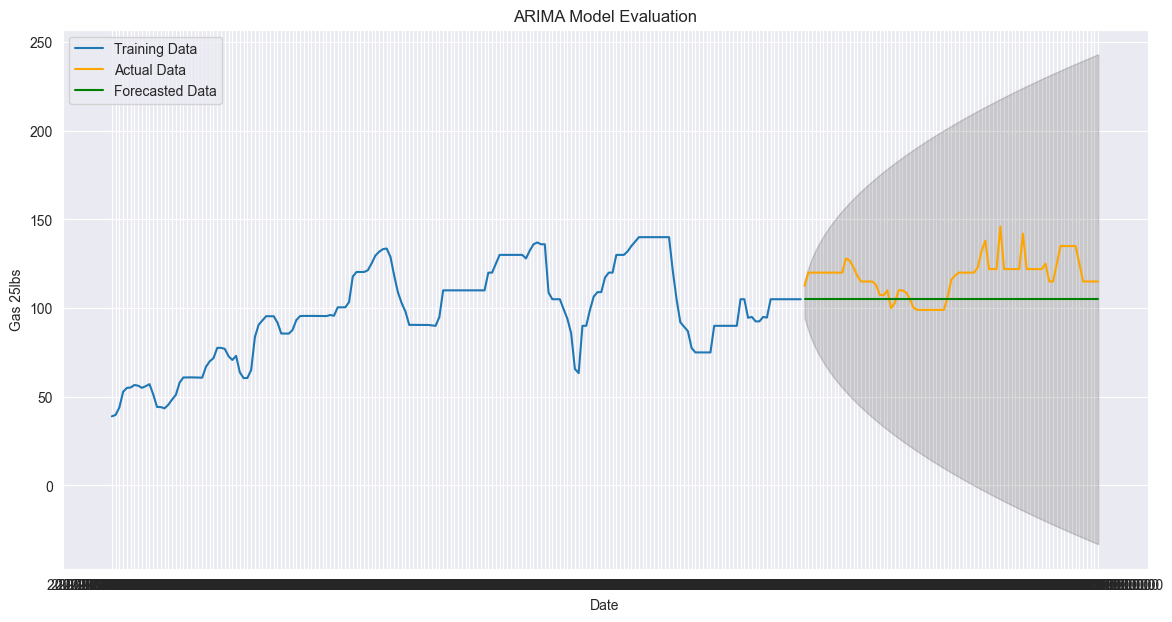

In [24]:
pg25_111 = create_arima_model(train_gas[['Gas 25lbs']], p=1, d=1, q=1)
plot_arima_eval(pg25_111, train_gas[['Gas 25lbs']], test_gas[['Gas 25lbs']], 'Gas 25lbs')

In [35]:
train_x_g25, train_y_g25, test_x_g25, test_y_g25 = data_preprocessing(data_gas[['Gas 25lbs']], sequence_length=1)

##### LSTM 1

In [36]:
g25_1 = create_lstm_model_s(train_x_g25)
g25_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g25_1_history = get_history(g25_1, train_x_g25, train_y_g25, name='g25 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 26ms/step - accuracy: 0.0000e+00 - loss: 0.8855 - mse: 0.8855 - val_accuracy: 0.0000e+00 - val_loss: 0.9832 - val_mse: 0.9832
Epoch 2/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.8834 - mse: 0.8834 - val_accuracy: 0.0000e+00 - val_loss: 0.9852 - val_mse: 0.9852
Epoch 3/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8810 - mse: 0.8810 - val_accuracy: 0.0000e+00 - val_loss: 0.9867 - val_mse: 0.9867
Epoch 4/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8776 - mse: 0.8776 - val_accuracy: 0.0000e+00 - val_loss: 0.9878 - val_mse: 0.9878
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8734 - mse: 0.8734 - val_accuracy: 0.0000e+00 - val_loss: 0.9885 - val_mse: 0.9885
Epoch 6/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8687 - mse: 0.8687 - val_accuracy: 0.0000e+00 - val_loss: 0.9888 - val_mse: 0.9888
Epoch 7/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.8635 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.7205 - mse: 0.7205 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.0214 - mse: 1.0214


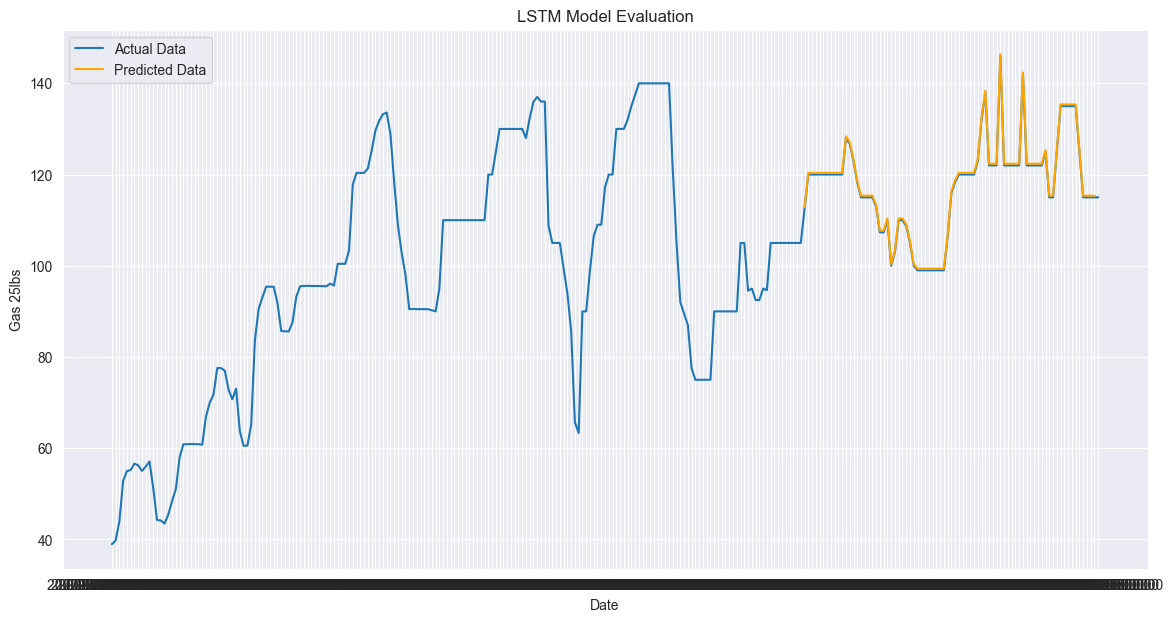

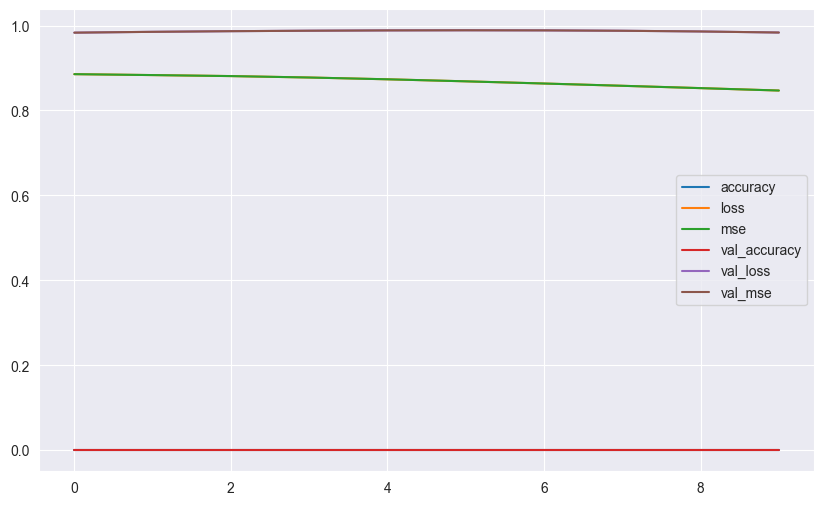

In [47]:
evaluate_model(g25_1, g25_1_history, data_gas['Gas 25lbs'], 'Gas 25lbs', train_x_g25, train_y_g25, test_x_g25, test_y_g25)

In [48]:
g25_2 = create_lstm_model(train_x_g25, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
g25_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g25_2_history = get_history(g25_2, train_x_g25, train_y_g25, name='g25 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 7s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.8604 - mse: 0.8604 - val_accuracy: 0.0000e+00 - val_loss: 0.8642 - val_mse: 0.8642
Epoch 2/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.8041 - mse: 0.8041 - val_accuracy: 0.0000e+00 - val_loss: 0.7955 - val_mse: 0.7955
Epoch 3/100
137/137 - 7s - 50ms/step - accuracy: 0.0000e+00 - loss: 0.7785 - mse: 0.7785 - val_accuracy: 0.0000e+00 - val_loss: 0.8040 - val_mse: 0.8040
Epoch 4/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.7835 - mse: 0.7835 - val_accuracy: 0.0000e+00 - val_loss: 0.8189 - val_mse: 0.8189
Epoch 5/100
137/137 - 6s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.7568 - mse: 0.7568 - val_accuracy: 0.0000e+00 - val_loss: 0.8179 - val_mse: 0.8179
Epoch 6/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.7614 - mse: 0.7614 - val_accuracy: 0.0000e+00 - val_loss: 0.8162 - val_mse: 0.8162
Epoch 7/100
137/137 - 7s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.7452 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.5928 - mse: 0.5928
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1.2122 - mse: 1.2122


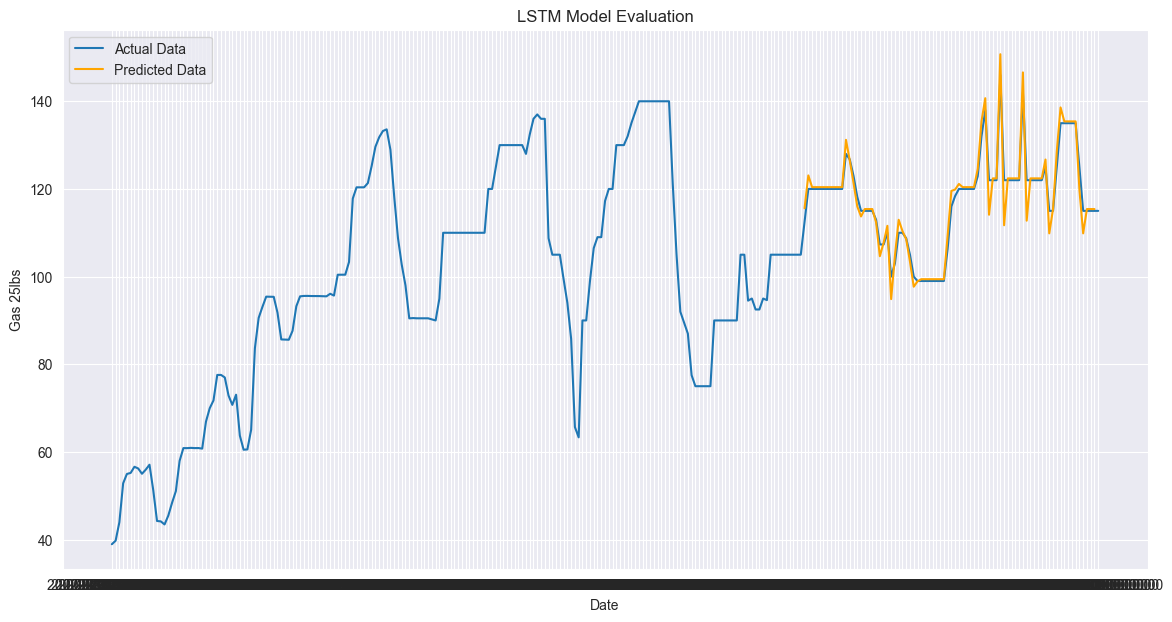

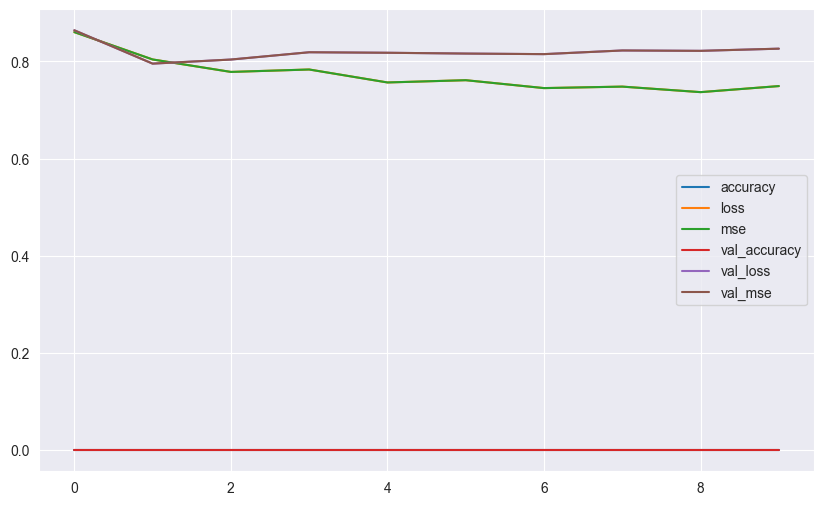

In [49]:
g25_2_loaded = keras.models.load_model('./models/g25 2.keras')
evaluate_model(g25_2_loaded, g25_2_history, data_gas['Gas 25lbs'], 'Gas 25lbs', train_x_g25, train_y_g25, test_x_g25, test_y_g25)

#### Gas 35lbs
##### ARIMA

RMSE: 23.22031231023338


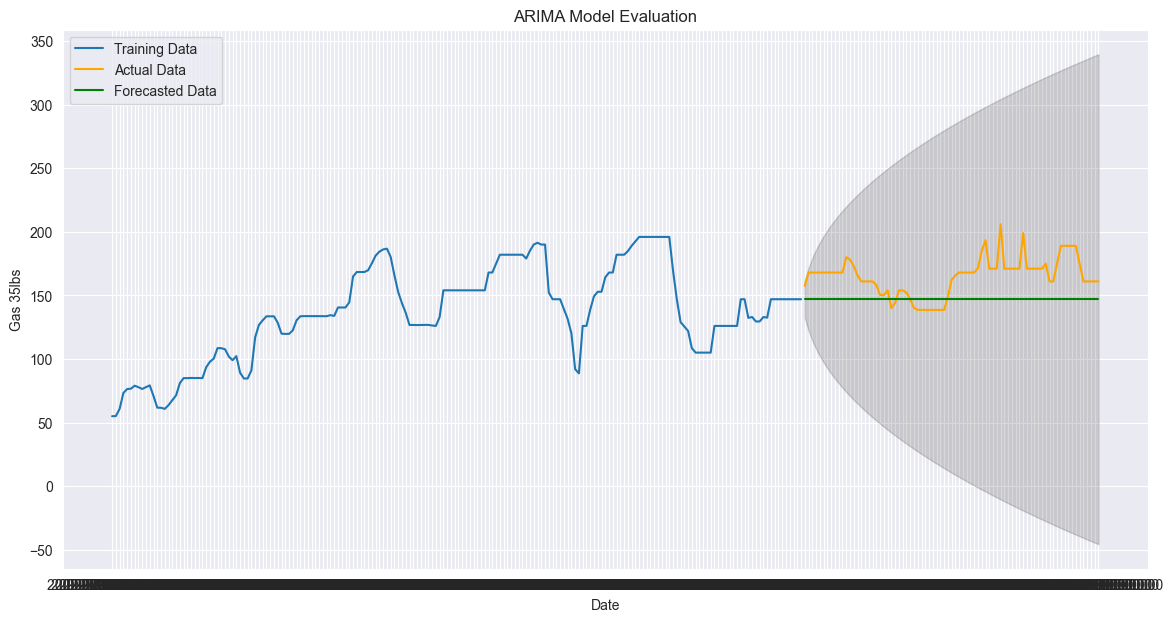

In [25]:
pg35_111 = create_arima_model(train_gas[['Gas 35lbs']], p=1, d=1, q=1)
plot_arima_eval(pg35_111, train_gas[['Gas 35lbs']], test_gas[['Gas 35lbs']], 'Gas 35lbs')

In [51]:
train_x_g35, train_y_g35, test_x_g35, test_y_g35 = data_preprocessing(data_gas[['Gas 35lbs']], sequence_length=1)

##### LSTM 1

In [52]:
g35_1 = create_lstm_model_s(train_x_g35)
g35_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g35_1_history = get_history(g35_1, train_x_g35, train_y_g35, name='g35 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 4s - 26ms/step - accuracy: 0.0000e+00 - loss: 0.8088 - mse: 0.8088 - val_accuracy: 0.0000e+00 - val_loss: 0.8919 - val_mse: 0.8919
Epoch 2/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.8006 - mse: 0.8006 - val_accuracy: 0.0000e+00 - val_loss: 0.8865 - val_mse: 0.8865
Epoch 3/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.7937 - mse: 0.7937 - val_accuracy: 0.0000e+00 - val_loss: 0.8810 - val_mse: 0.8810
Epoch 4/100
137/137 - 3s - 23ms/step - accuracy: 0.0000e+00 - loss: 0.7873 - mse: 0.7873 - val_accuracy: 0.0000e+00 - val_loss: 0.8754 - val_mse: 0.8754
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.7812 - mse: 0.7812 - val_accuracy: 0.0000e+00 - val_loss: 0.8699 - val_mse: 0.8699
Epoch 6/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.7755 - mse: 0.7755 - val_accuracy: 0.0000e+00 - val_loss: 0.8645 - val_mse: 0.8645
Epoch 7/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.7701 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.6456 - mse: 0.6456
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.0442 - mse: 1.0442 


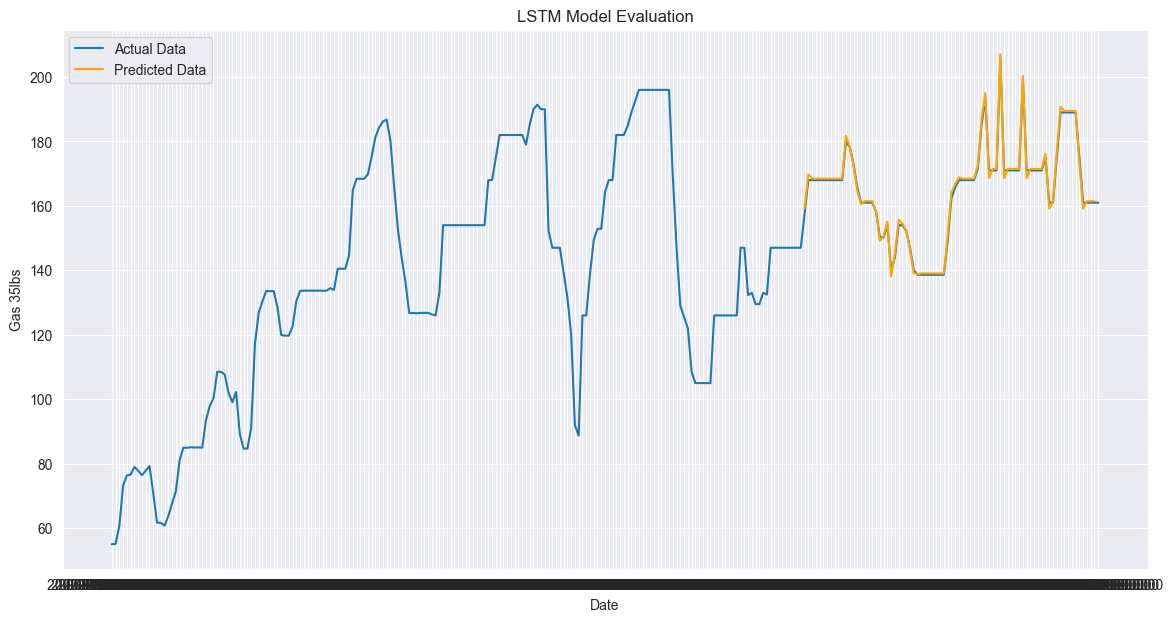

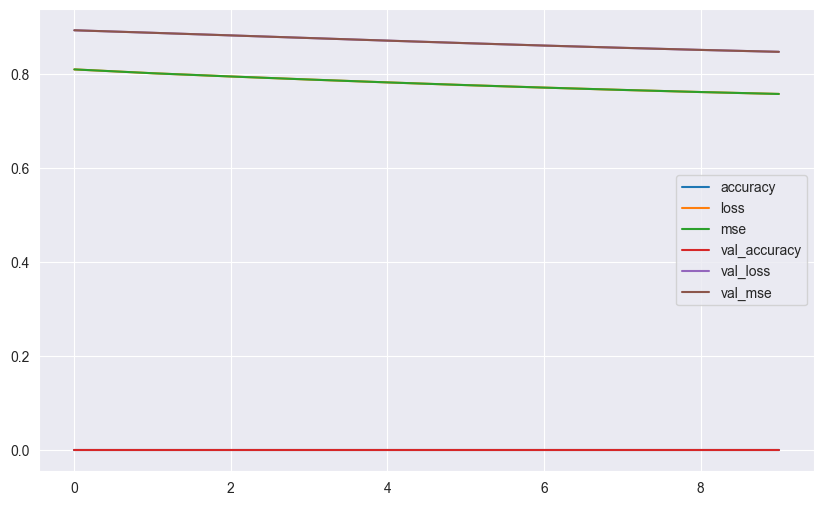

In [53]:
evaluate_model(g35_1, g35_1_history, data_gas['Gas 35lbs'], 'Gas 35lbs', train_x_g35, train_y_g35, test_x_g35, test_y_g35)

##### LSTM 2

In [54]:
g35_2 = create_lstm_model(train_x_g35, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
g35_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g35_2_history = get_history(g35_2, train_x_g35, train_y_g35, name='g35 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 7s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.8442 - mse: 0.8442 - val_accuracy: 0.0000e+00 - val_loss: 0.8614 - val_mse: 0.8614
Epoch 2/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.7889 - mse: 0.7889 - val_accuracy: 0.0000e+00 - val_loss: 0.8017 - val_mse: 0.8017
Epoch 3/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.7504 - mse: 0.7504 - val_accuracy: 0.0000e+00 - val_loss: 0.8001 - val_mse: 0.8001
Epoch 4/100
137/137 - 10s - 74ms/step - accuracy: 0.0000e+00 - loss: 0.7724 - mse: 0.7724 - val_accuracy: 0.0000e+00 - val_loss: 0.8110 - val_mse: 0.8110
Epoch 5/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.7459 - mse: 0.7459 - val_accuracy: 0.0000e+00 - val_loss: 0.8174 - val_mse: 0.8174
Epoch 6/100
137/137 - 7s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.7562 - mse: 0.7562 - val_accuracy: 0.0000e+00 - val_loss: 0.8148 - val_mse: 0.8148
Epoch 7/100
137/137 - 6s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.7436 - mse:

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.5810 - mse: 0.5810
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1.2545 - mse: 1.2545


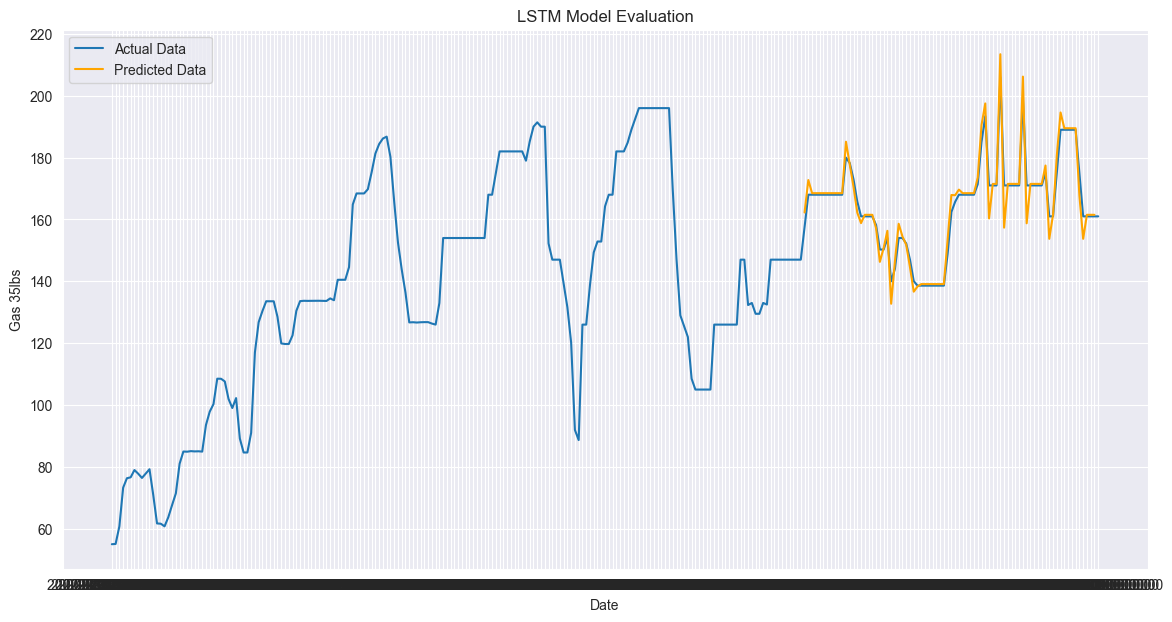

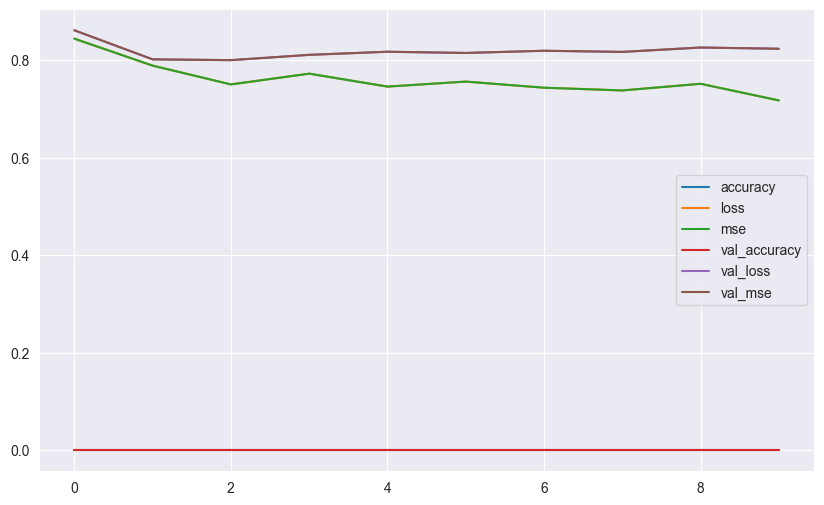

In [55]:
g35_2_loaded = keras.models.load_model('./models/g35 2.keras')
evaluate_model(g35_2_loaded, g35_2_history, data_gas['Gas 35lbs'], 'Gas 35lbs', train_x_g35, train_y_g35, test_x_g35, test_y_g35)

#### Gas 40lbs
##### ARIMA

RMSE: 34.864380557319095


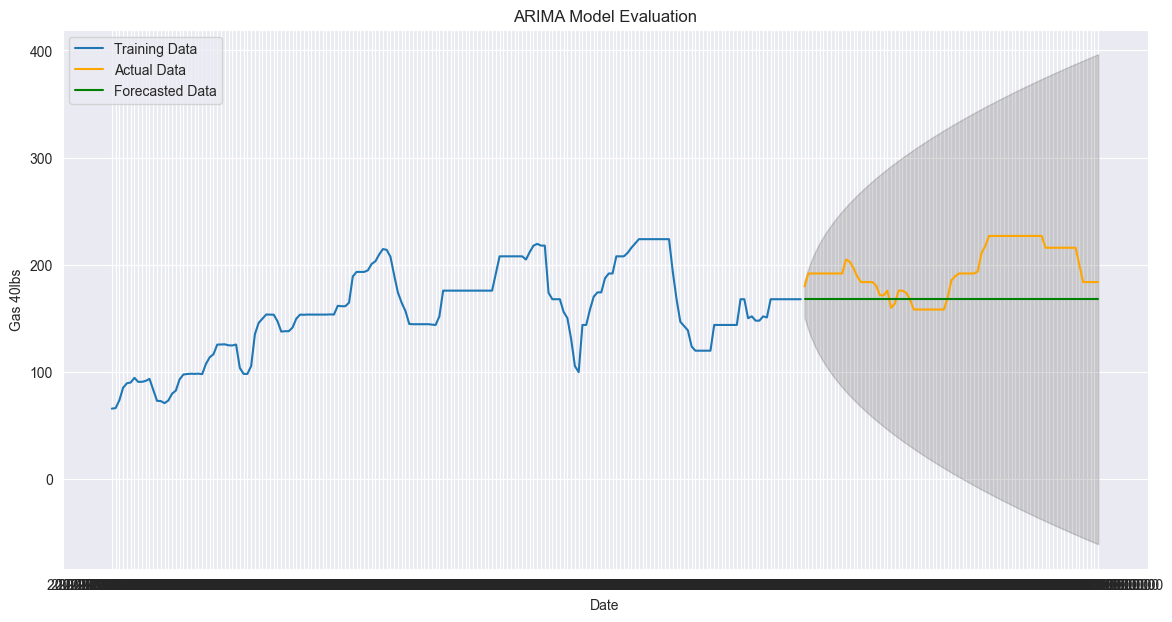

In [26]:
pg40_111 = create_arima_model(train_gas[['Gas 40lbs']], p=1, d=1, q=1)
plot_arima_eval(pg40_111, train_gas[['Gas 40lbs']], test_gas[['Gas 40lbs']], 'Gas 40lbs')

In [56]:
train_x_g40, train_y_g40, test_x_g40, test_y_g40 = data_preprocessing(data_gas[['Gas 40lbs']], sequence_length=1)

##### LSTM 1

In [57]:
g40_1 = create_lstm_model_s(train_x_g40)
g40_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g40_1_history = get_history(g40_1, train_x_g40, train_y_g40, name='g40 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 25ms/step - accuracy: 0.0000e+00 - loss: 1.1179 - mse: 1.1179 - val_accuracy: 0.0000e+00 - val_loss: 1.2149 - val_mse: 1.2149
Epoch 2/100
137/137 - 3s - 23ms/step - accuracy: 0.0000e+00 - loss: 1.1067 - mse: 1.1067 - val_accuracy: 0.0000e+00 - val_loss: 1.2074 - val_mse: 1.2074
Epoch 3/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 1.0975 - mse: 1.0975 - val_accuracy: 0.0000e+00 - val_loss: 1.1998 - val_mse: 1.1998
Epoch 4/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.0890 - mse: 1.0890 - val_accuracy: 0.0000e+00 - val_loss: 1.1921 - val_mse: 1.1921
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.0811 - mse: 1.0811 - val_accuracy: 0.0000e+00 - val_loss: 1.1846 - val_mse: 1.1846
Epoch 6/100
137/137 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 1.0738 - mse: 1.0738 - val_accuracy: 0.0000e+00 - val_loss: 1.1774 - val_mse: 1.1774
Epoch 7/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 1.0672 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.8886 - mse: 0.8886 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4418 - mse: 0.4418


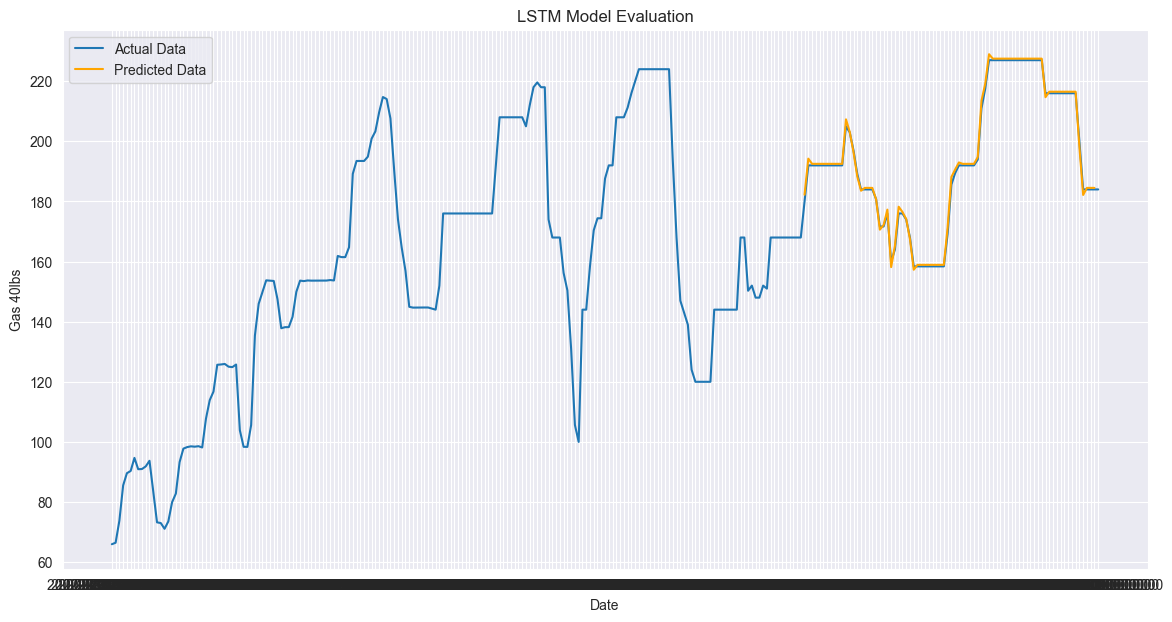

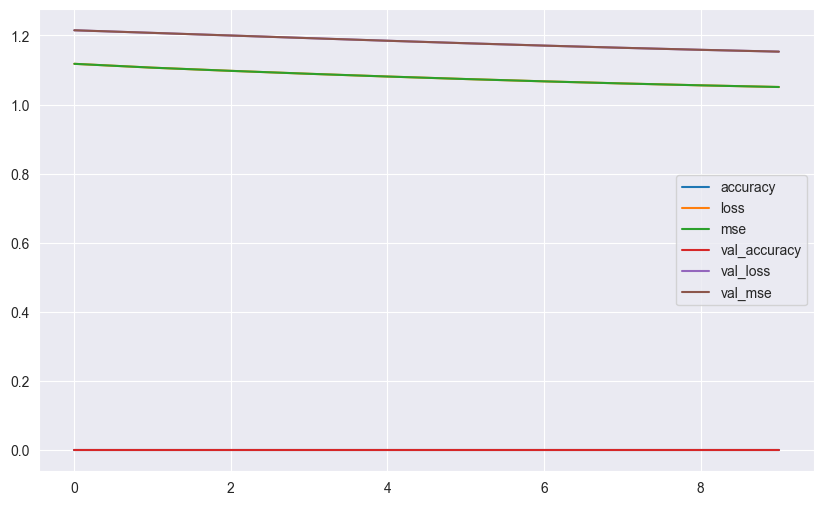

In [58]:
evaluate_model(g40_1, g40_1_history, data_gas['Gas 40lbs'], 'Gas 40lbs', train_x_g40, train_y_g40, test_x_g40, test_y_g40)

##### LSTM 2

In [59]:
g40_2 = create_lstm_model(train_x_g40, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
g40_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g40_2_history = get_history(g40_2, train_x_g40, train_y_g40, name='g40 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 8s - 55ms/step - accuracy: 0.0000e+00 - loss: 1.1514 - mse: 1.1514 - val_accuracy: 0.0000e+00 - val_loss: 1.1626 - val_mse: 1.1626
Epoch 2/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 1.0897 - mse: 1.0897 - val_accuracy: 0.0000e+00 - val_loss: 1.1193 - val_mse: 1.1193
Epoch 3/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 1.0618 - mse: 1.0618 - val_accuracy: 0.0000e+00 - val_loss: 1.1165 - val_mse: 1.1165
Epoch 4/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 1.0497 - mse: 1.0497 - val_accuracy: 0.0000e+00 - val_loss: 1.1062 - val_mse: 1.1062
Epoch 5/100
137/137 - 7s - 50ms/step - accuracy: 0.0000e+00 - loss: 1.0507 - mse: 1.0507 - val_accuracy: 0.0000e+00 - val_loss: 1.1118 - val_mse: 1.1118
Epoch 6/100
137/137 - 8s - 57ms/step - accuracy: 0.0000e+00 - loss: 1.0410 - mse: 1.0410 - val_accuracy: 0.0000e+00 - val_loss: 1.1125 - val_mse: 1.1125
Epoch 7/100
137/137 - 7s - 50ms/step - accuracy: 0.0000e+00 - loss: 1.0458 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.8037 - mse: 0.8037
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.4453 - mse: 0.4453


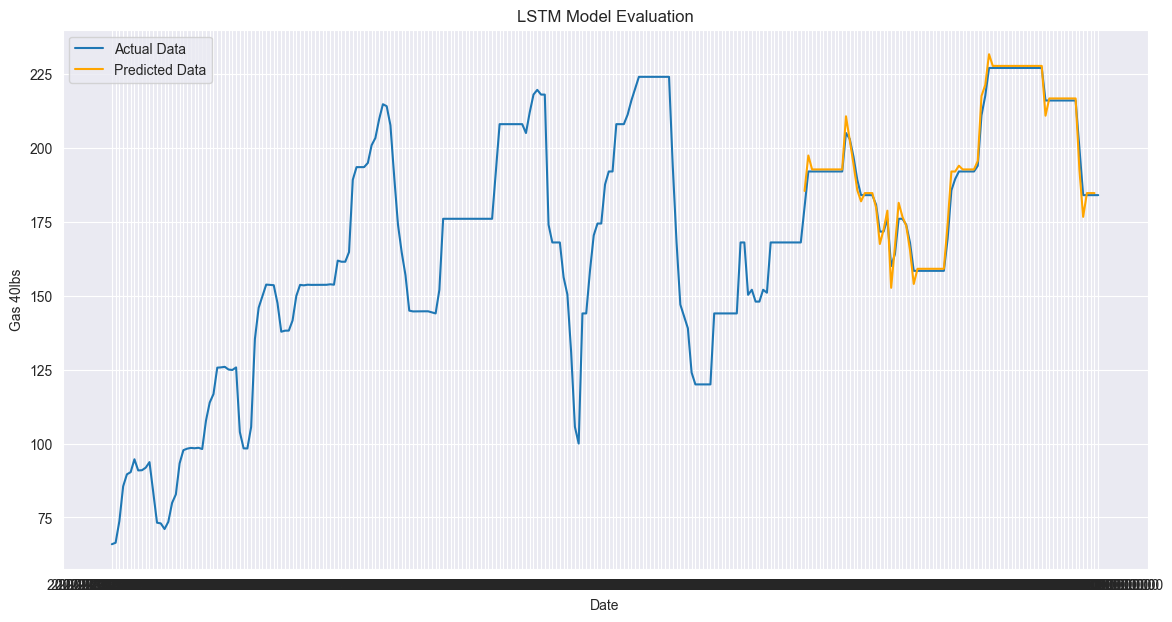

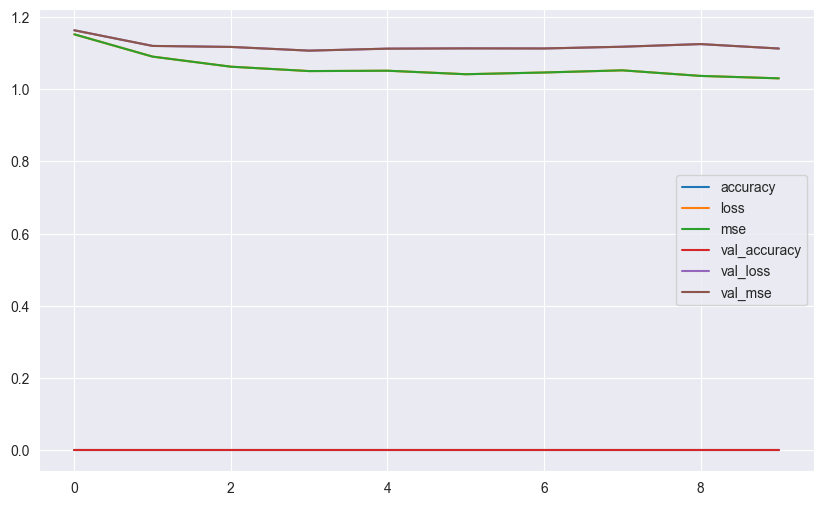

In [60]:
g40_2_loaded = keras.models.load_model('./models/g40 2.keras')
evaluate_model(g40_2_loaded, g40_2_history, data_gas['Gas 40lbs'], 'Gas 40lbs', train_x_g40, train_y_g40, test_x_g40, test_y_g40)

#### Gas 60lbs
##### ARIMA

RMSE: 52.39944942581397


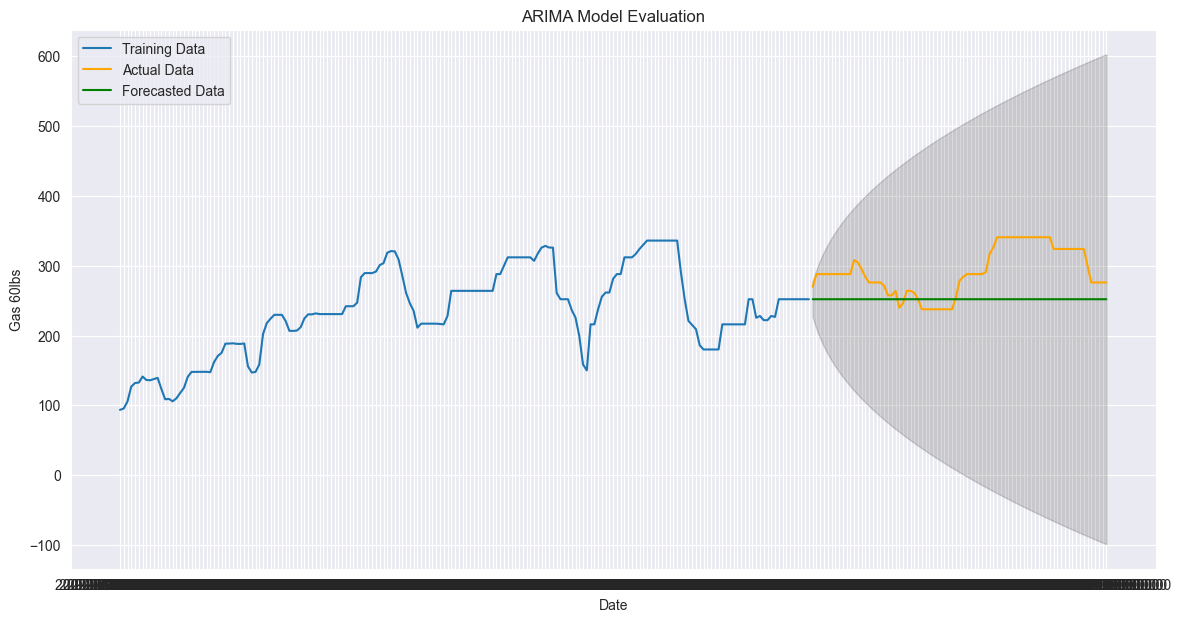

In [27]:
pg60_112 = create_arima_model(train_gas[['Gas 60lbs']], p=1, d=1, q=2)
plot_arima_eval(pg60_112, train_gas[['Gas 60lbs']], test_gas[['Gas 60lbs']], 'Gas 60lbs')

In [61]:
train_x_g60, train_y_g60, test_x_g60, test_y_g60 = data_preprocessing(data_gas[['Gas 60lbs']], sequence_length=1)

##### LSTM 1

In [62]:
g60_1 = create_lstm_model_s(train_x_g60)
g60_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g60_1_history = get_history(g60_1, train_x_g60, train_y_g60, name='g60 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 1.1625 - mse: 1.1625 - val_accuracy: 0.0000e+00 - val_loss: 1.2748 - val_mse: 1.2748
Epoch 2/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.1551 - mse: 1.1551 - val_accuracy: 0.0000e+00 - val_loss: 1.2715 - val_mse: 1.2715
Epoch 3/100
137/137 - 3s - 25ms/step - accuracy: 0.0000e+00 - loss: 1.1484 - mse: 1.1484 - val_accuracy: 0.0000e+00 - val_loss: 1.2674 - val_mse: 1.2674
Epoch 4/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.1415 - mse: 1.1415 - val_accuracy: 0.0000e+00 - val_loss: 1.2624 - val_mse: 1.2624
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.1345 - mse: 1.1345 - val_accuracy: 0.0000e+00 - val_loss: 1.2565 - val_mse: 1.2565
Epoch 6/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.1275 - mse: 1.1275 - val_accuracy: 0.0000e+00 - val_loss: 1.2501 - val_mse: 1.2501
Epoch 7/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 1.1204 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.9400 - mse: 0.9400 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.4640 - mse: 0.4640 


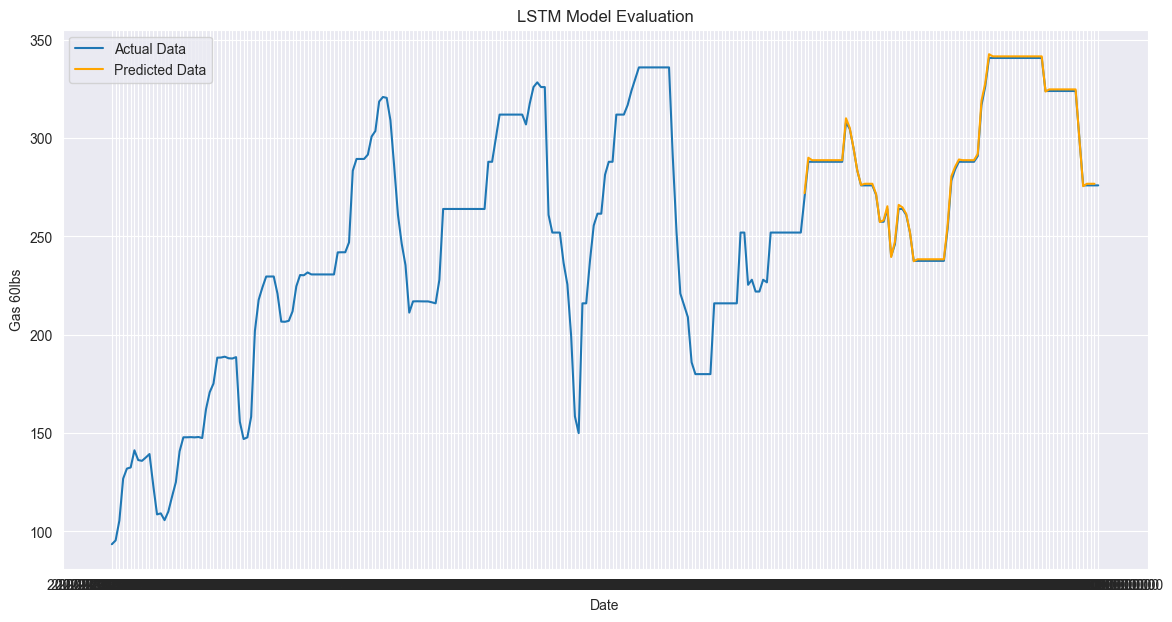

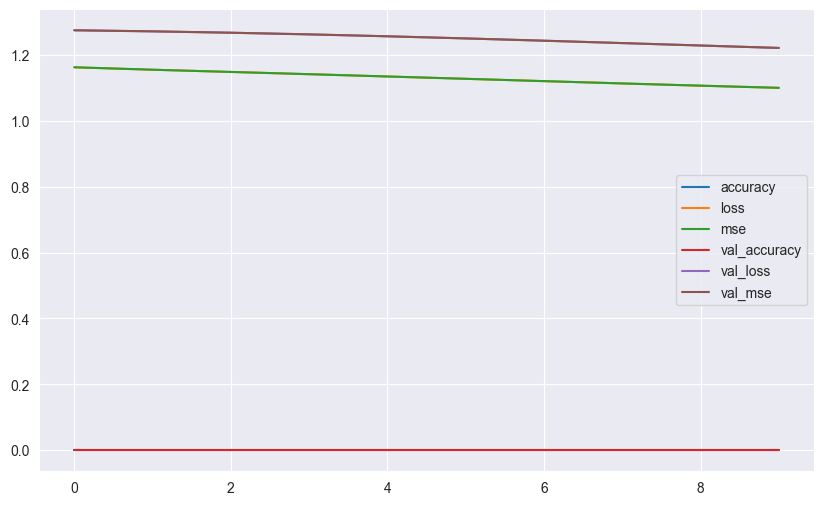

In [63]:
evaluate_model(g60_1, g60_1_history, data_gas['Gas 60lbs'], 'Gas 60lbs', train_x_g60, train_y_g60, test_x_g60, test_y_g60)

##### LSTM 2

In [64]:
g60_2 = create_lstm_model(train_x_g60, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
g60_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g60_2_history = get_history(g60_2, train_x_g60, train_y_g60, name='g60 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 8s - 56ms/step - accuracy: 0.0000e+00 - loss: 1.1648 - mse: 1.1648 - val_accuracy: 0.0000e+00 - val_loss: 1.1622 - val_mse: 1.1622
Epoch 2/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 1.0929 - mse: 1.0929 - val_accuracy: 0.0000e+00 - val_loss: 1.0912 - val_mse: 1.0912
Epoch 3/100
137/137 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 1.0819 - mse: 1.0819 - val_accuracy: 0.0000e+00 - val_loss: 1.0902 - val_mse: 1.0902
Epoch 4/100
137/137 - 7s - 55ms/step - accuracy: 0.0000e+00 - loss: 1.0433 - mse: 1.0433 - val_accuracy: 0.0000e+00 - val_loss: 1.0911 - val_mse: 1.0911
Epoch 5/100
137/137 - 7s - 54ms/step - accuracy: 0.0000e+00 - loss: 1.0360 - mse: 1.0360 - val_accuracy: 0.0000e+00 - val_loss: 1.0942 - val_mse: 1.0942
Epoch 6/100
137/137 - 7s - 53ms/step - accuracy: 0.0000e+00 - loss: 1.0649 - mse: 1.0649 - val_accuracy: 0.0000e+00 - val_loss: 1.1045 - val_mse: 1.1045
Epoch 7/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 1.0374 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.8178 - mse: 0.8178
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.4494 - mse: 0.4494


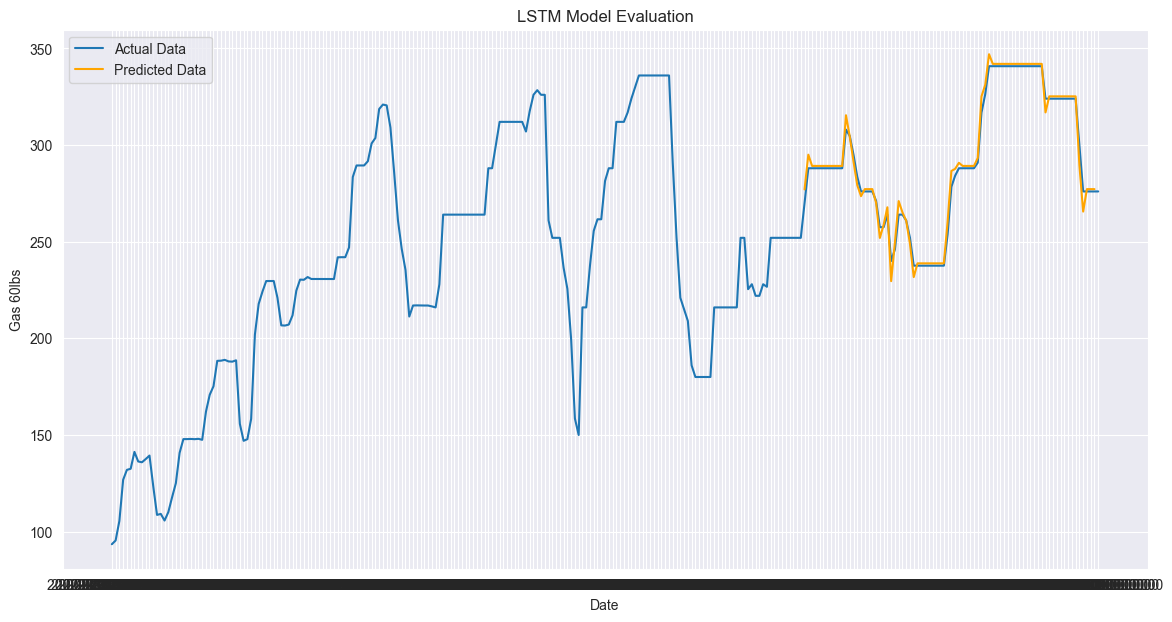

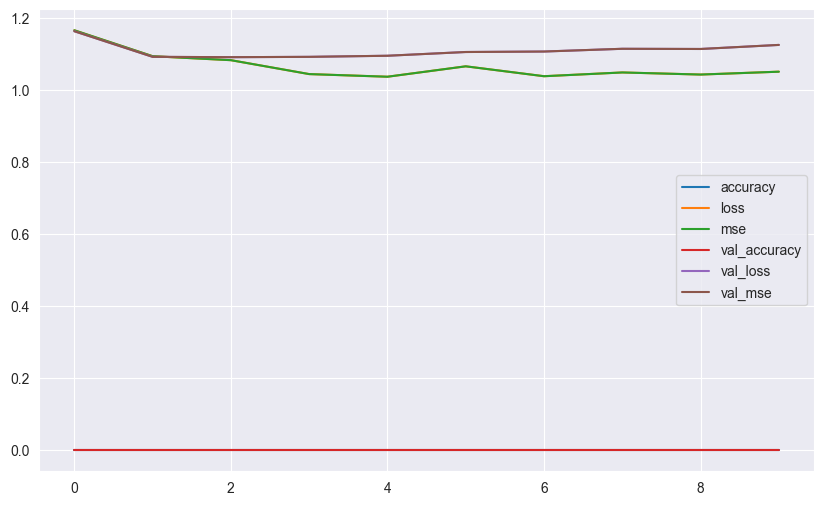

In [65]:
g60_2_loaded = keras.models.load_model('./models/g60 2.keras')
evaluate_model(g60_2_loaded, g60_2_history, data_gas['Gas 60lbs'], 'Gas 60lbs', train_x_g60, train_y_g60, test_x_g60, test_y_g60)

#### Gas 100lbs
##### ARIMA

RMSE: 87.38683965376536


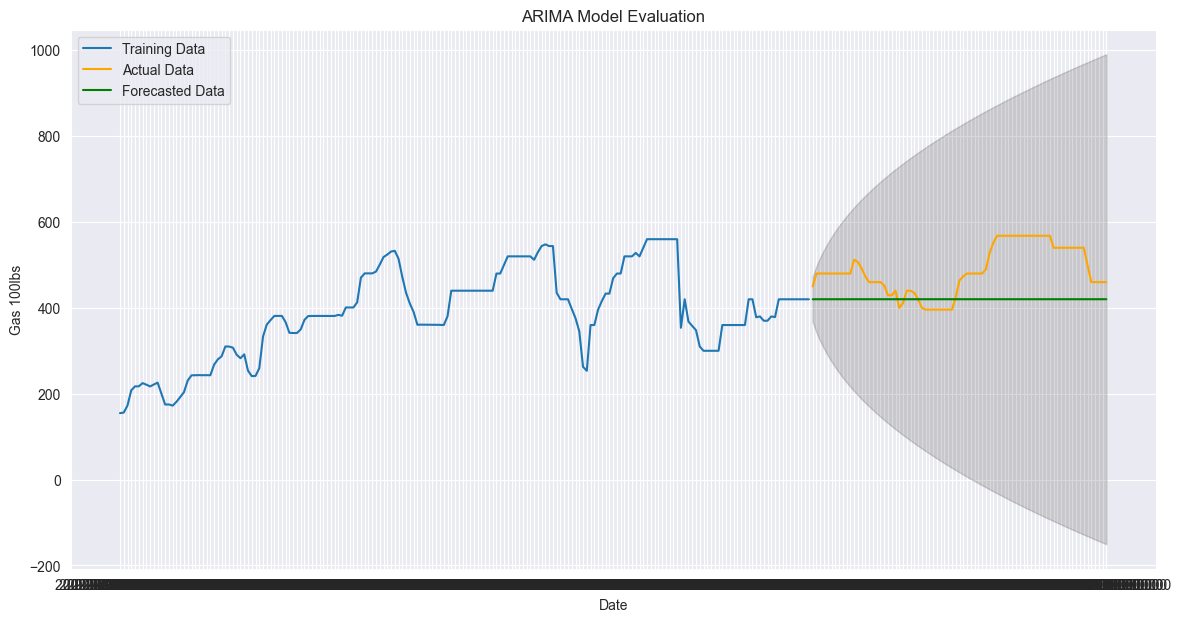

In [28]:
pg100_111 = create_arima_model(train_gas[['Gas100lbs']], p=1, d=1, q=1)
plot_arima_eval(pg100_111, train_gas[['Gas100lbs']], test_gas[['Gas100lbs']], 'Gas 100lbs')

In [67]:
train_x_g100, train_y_g100, test_x_g100, test_y_g100 = data_preprocessing(data_gas[['Gas100lbs']], sequence_length=1)

##### LSTM 1

In [68]:
g100_1 = create_lstm_model_s(train_x_g100)
g100_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g100_1_history = get_history(g100_1, train_x_g100, train_y_g100, name='g100 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 4s - 28ms/step - accuracy: 0.0000e+00 - loss: 0.9563 - mse: 0.9563 - val_accuracy: 0.0000e+00 - val_loss: 2.4354 - val_mse: 2.4354
Epoch 2/100
137/137 - 3s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.9453 - mse: 0.9453 - val_accuracy: 0.0000e+00 - val_loss: 2.4376 - val_mse: 2.4376
Epoch 3/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9372 - mse: 0.9372 - val_accuracy: 0.0000e+00 - val_loss: 2.4394 - val_mse: 2.4394
Epoch 4/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9305 - mse: 0.9305 - val_accuracy: 0.0000e+00 - val_loss: 2.4409 - val_mse: 2.4409
Epoch 5/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9248 - mse: 0.9248 - val_accuracy: 0.0000e+00 - val_loss: 2.4421 - val_mse: 2.4421
Epoch 6/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9200 - mse: 0.9200 - val_accuracy: 0.0000e+00 - val_loss: 2.4431 - val_mse: 2.4431
Epoch 7/100
137/137 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.9159 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.9377 - mse: 0.9377 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.3881 - mse: 0.3881 


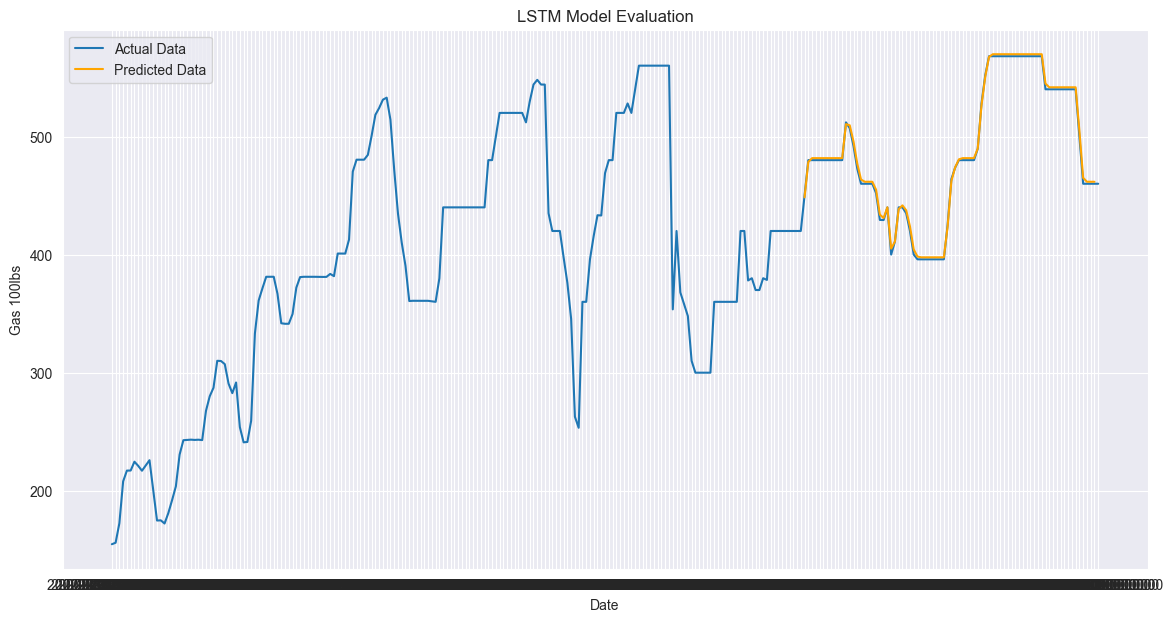

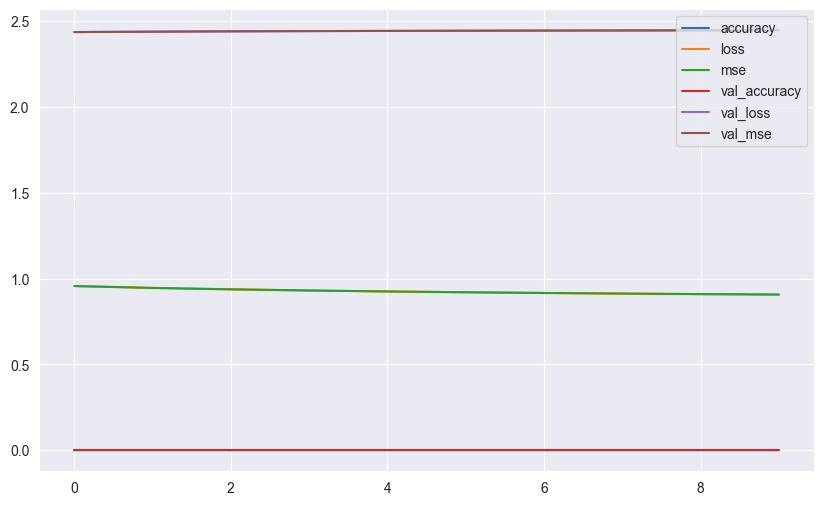

In [69]:
evaluate_model(g100_1, g100_1_history, data_gas['Gas100lbs'], 'Gas 100lbs', train_x_g100, train_y_g100, test_x_g100, test_y_g100)

##### LSTM 2

In [70]:
g100_2 = create_lstm_model(train_x_g100, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
g100_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
g100_2_history = get_history(g100_2, train_x_g100, train_y_g100, name='g100 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
137/137 - 8s - 59ms/step - accuracy: 0.0000e+00 - loss: 0.8734 - mse: 0.8734 - val_accuracy: 0.0000e+00 - val_loss: 2.6097 - val_mse: 2.6097
Epoch 2/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.8253 - mse: 0.8253 - val_accuracy: 0.0000e+00 - val_loss: 2.7981 - val_mse: 2.7981
Epoch 3/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.7889 - mse: 0.7889 - val_accuracy: 0.0000e+00 - val_loss: 2.8765 - val_mse: 2.8765
Epoch 4/100
137/137 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.7852 - mse: 0.7852 - val_accuracy: 0.0000e+00 - val_loss: 2.7997 - val_mse: 2.7997
Epoch 5/100
137/137 - 7s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.7807 - mse: 0.7807 - val_accuracy: 0.0000e+00 - val_loss: 2.7449 - val_mse: 2.7449
Epoch 6/100
137/137 - 7s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.7505 - mse: 0.7505 - val_accuracy: 0.0000e+00 - val_loss: 2.7174 - val_mse: 2.7174
Epoch 7/100
137/137 - 7s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.7626 - mse: 

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.8483 - mse: 0.8483
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.3272 - mse: 0.3272


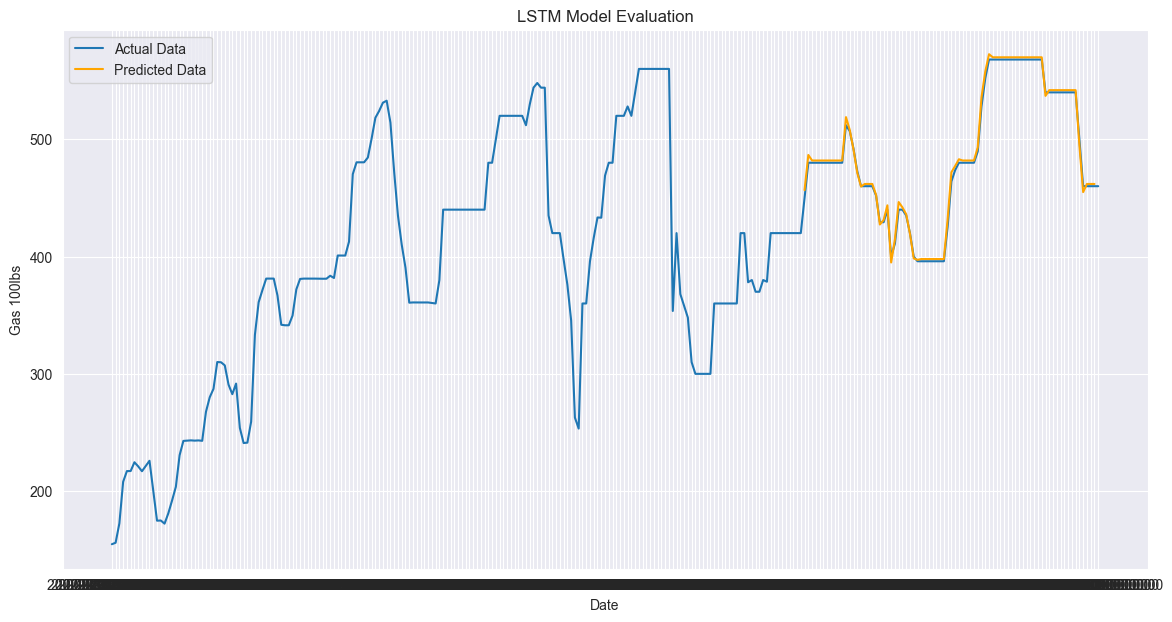

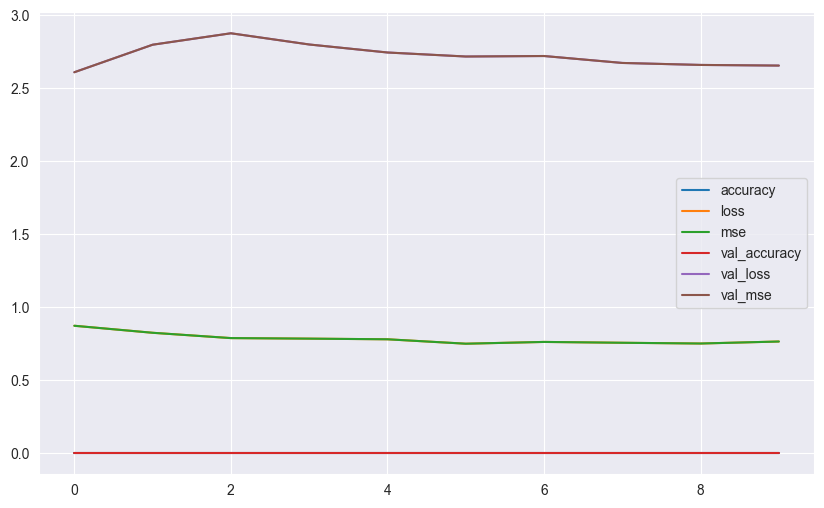

In [71]:
g100_2_loaded = keras.models.load_model('./models/g100 2.keras')
evaluate_model(g100_2_loaded, g100_2_history, data_gas['Gas100lbs'], 'Gas 100lbs', train_x_g100, train_y_g100, test_x_g100, test_y_g100)

### Modelos de consumo de combustibles
#### Consumo de Diesel
##### ARIMA

RMSE: 93550.03306908801


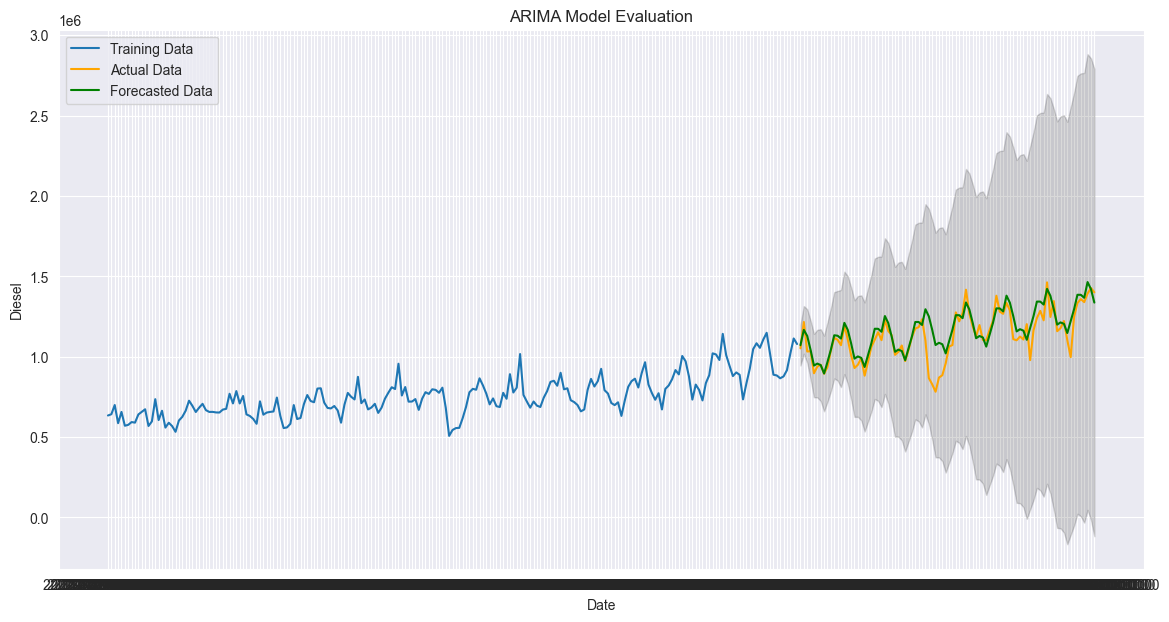

In [29]:
pcd_111 = create_arima_model(train_consumo[['Diesel']], p=1, d=1, q=1, s=12)
plot_arima_eval(pcd_111, train_consumo[['Diesel']], test_consumo[['Diesel']], 'Diesel')

In [72]:
train_x_cd, train_y_cd, test_x_cd, test_y_cd = data_preprocessing(data_consumo[['Diesel']], sequence_length=1)

##### LSTM 1

In [74]:
cd_1 = create_lstm_model_s(train_x_cd)
cd_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cd_1_history = get_history(cd_1, train_x_cd, train_y_cd, name='cd 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 4s - 27ms/step - accuracy: 0.0000e+00 - loss: 0.7486 - mse: 0.7486 - val_accuracy: 0.0000e+00 - val_loss: 0.9826 - val_mse: 0.9826
Epoch 2/100
153/153 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.7434 - mse: 0.7434 - val_accuracy: 0.0000e+00 - val_loss: 0.9824 - val_mse: 0.9824
Epoch 3/100
153/153 - 4s - 23ms/step - accuracy: 0.0000e+00 - loss: 0.7397 - mse: 0.7397 - val_accuracy: 0.0000e+00 - val_loss: 0.9828 - val_mse: 0.9828
Epoch 4/100
153/153 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.7369 - mse: 0.7369 - val_accuracy: 0.0000e+00 - val_loss: 0.9834 - val_mse: 0.9834
Epoch 5/100
153/153 - 4s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.7345 - mse: 0.7345 - val_accuracy: 0.0000e+00 - val_loss: 0.9843 - val_mse: 0.9843
Epoch 6/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.7324 - mse: 0.7324 - val_accuracy: 0.0000e+00 - val_loss: 0.9853 - val_mse: 0.9853
Epoch 7/100
153/153 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.7305 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.7156 - mse: 0.7156 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.3213 - mse: 1.3213 


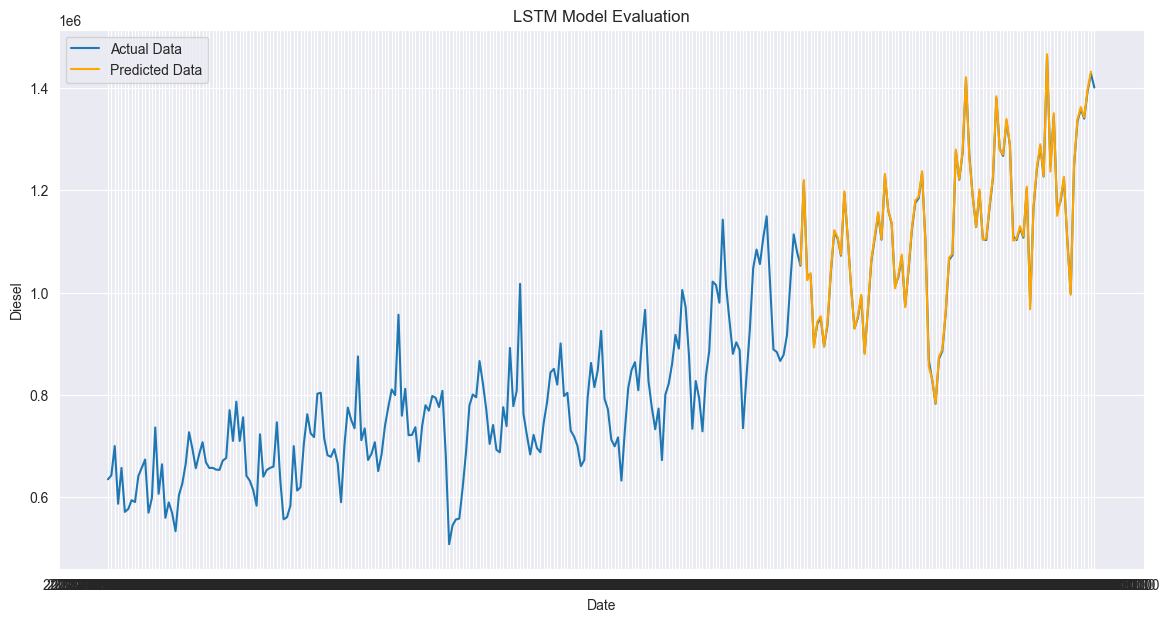

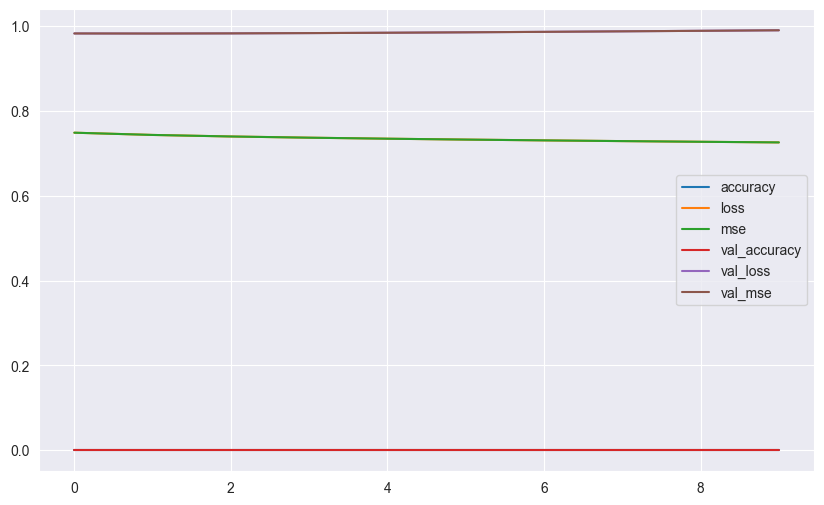

In [75]:
evaluate_model(cd_1, cd_1_history, data_consumo[['Diesel']], 'Diesel', train_x_cd, train_y_cd, test_x_cd, test_y_cd)

##### LSTM 2

In [76]:
cd_2 = create_lstm_model(train_x_cd, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
cd_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cd_2_history = get_history(cd_2, train_x_cd, train_y_cd, name='cd 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 8s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.7268 - mse: 0.7268 - val_accuracy: 0.0000e+00 - val_loss: 1.0024 - val_mse: 1.0024
Epoch 2/100
153/153 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.6614 - mse: 0.6614 - val_accuracy: 0.0000e+00 - val_loss: 1.1530 - val_mse: 1.1530
Epoch 3/100
153/153 - 9s - 57ms/step - accuracy: 0.0000e+00 - loss: 0.6104 - mse: 0.6104 - val_accuracy: 0.0000e+00 - val_loss: 1.1680 - val_mse: 1.1680
Epoch 4/100
153/153 - 8s - 55ms/step - accuracy: 0.0000e+00 - loss: 0.6174 - mse: 0.6174 - val_accuracy: 0.0000e+00 - val_loss: 1.1656 - val_mse: 1.1656
Epoch 5/100
153/153 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.5859 - mse: 0.5859 - val_accuracy: 0.0000e+00 - val_loss: 1.1691 - val_mse: 1.1691
Epoch 6/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.6075 - mse: 0.6075 - val_accuracy: 0.0000e+00 - val_loss: 1.0894 - val_mse: 1.0894
Epoch 7/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.5740 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.6684 - mse: 0.6684
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 1.2786 - mse: 1.2786


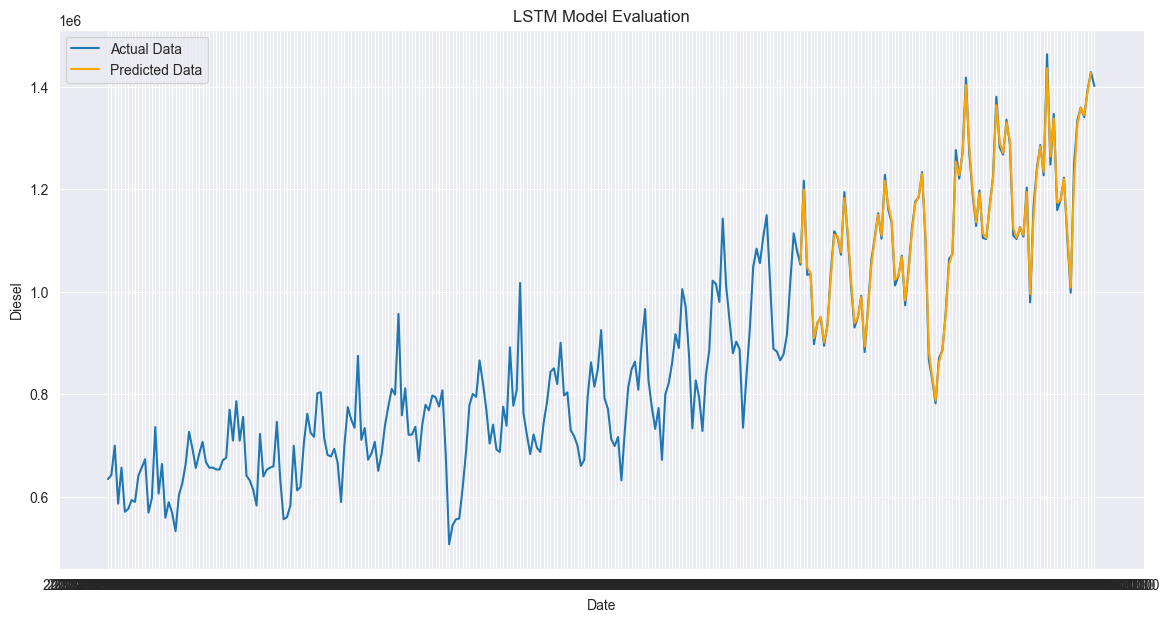

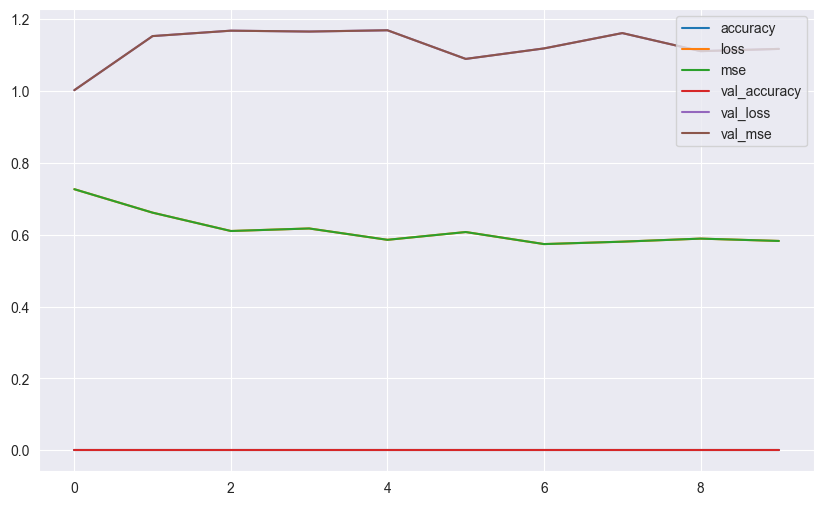

In [77]:
cd_2_loaded = keras.models.load_model('./models/cd 2.keras')
evaluate_model(cd_2_loaded, cd_2_history, data_consumo[['Diesel']], 'Diesel', train_x_cd, train_y_cd, test_x_cd, test_y_cd)

#### Consumo de Gas licuado de petroleo
##### ARIMA

RMSE: 34734.88207004961


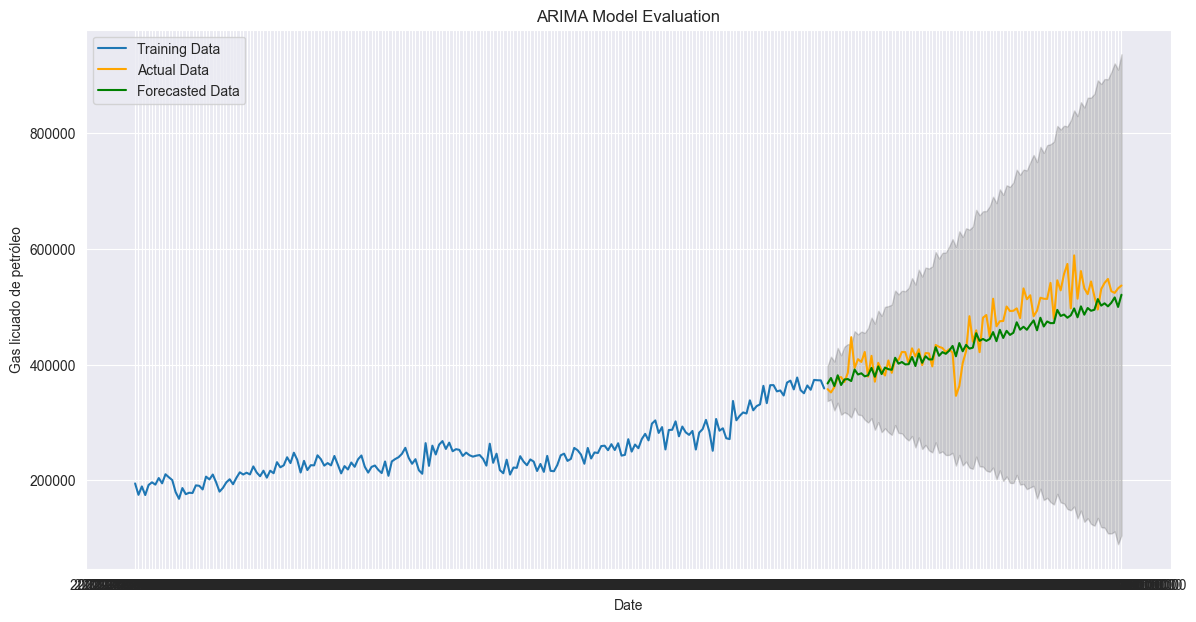

In [30]:
pcglp_711 = create_arima_model(train_consumo[['Gas licuado de petróleo']], p=7, d=1, q=1, s=12)
plot_arima_eval(pcglp_711, train_consumo[['Gas licuado de petróleo']], test_consumo[['Gas licuado de petróleo']], 'Gas licuado de petróleo')

In [78]:
train_x_cglp, train_y_cglp, test_x_cglp, test_y_cglp = data_preprocessing(data_consumo[['Gas licuado de petróleo']], sequence_length=1)

##### LSTM 1

In [79]:
cglp_1 = create_lstm_model_s(train_x_cglp)
cglp_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cglp_1_history = get_history(cglp_1, train_x_cglp, train_y_cglp, name='cglp 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 4s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.4449 - mse: 0.4449 - val_accuracy: 0.0000e+00 - val_loss: 0.9489 - val_mse: 0.9489
Epoch 2/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.4412 - mse: 0.4412 - val_accuracy: 0.0000e+00 - val_loss: 0.9417 - val_mse: 0.9417
Epoch 3/100
153/153 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.4386 - mse: 0.4386 - val_accuracy: 0.0000e+00 - val_loss: 0.9366 - val_mse: 0.9366
Epoch 4/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.4369 - mse: 0.4369 - val_accuracy: 0.0000e+00 - val_loss: 0.9330 - val_mse: 0.9330
Epoch 5/100
153/153 - 4s - 26ms/step - accuracy: 0.0000e+00 - loss: 0.4357 - mse: 0.4357 - val_accuracy: 0.0000e+00 - val_loss: 0.9305 - val_mse: 0.9305
Epoch 6/100
153/153 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.4349 - mse: 0.4349 - val_accuracy: 0.0000e+00 - val_loss: 0.9289 - val_mse: 0.9289
Epoch 7/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.4343 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.4503 - mse: 0.4503 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 1.8136 - mse: 1.8136


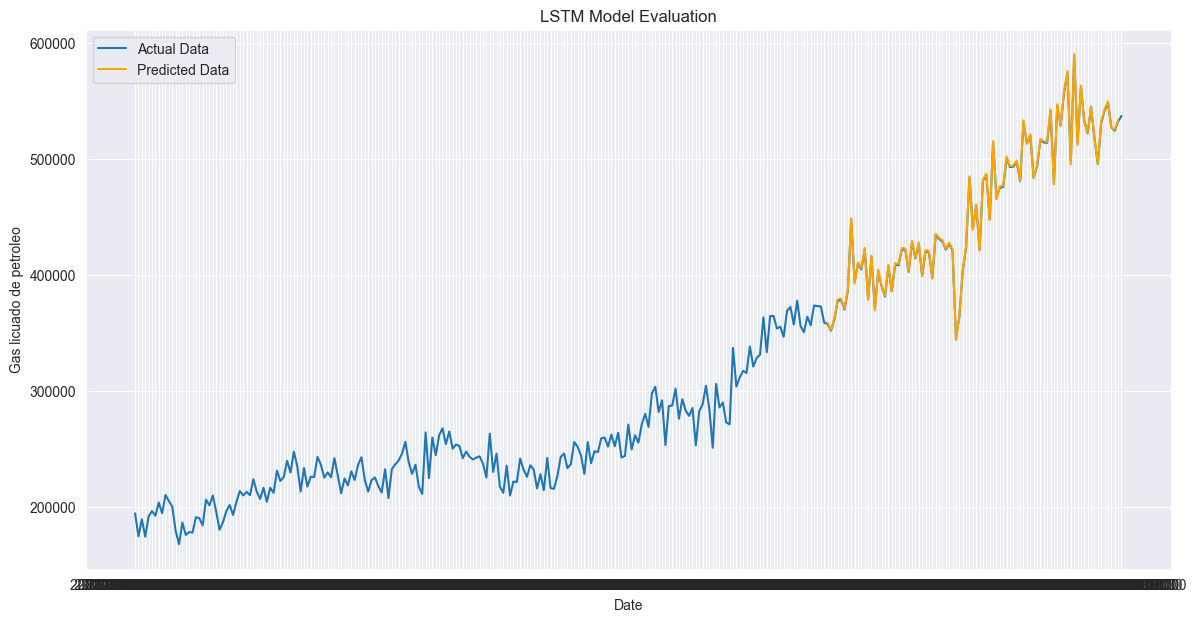

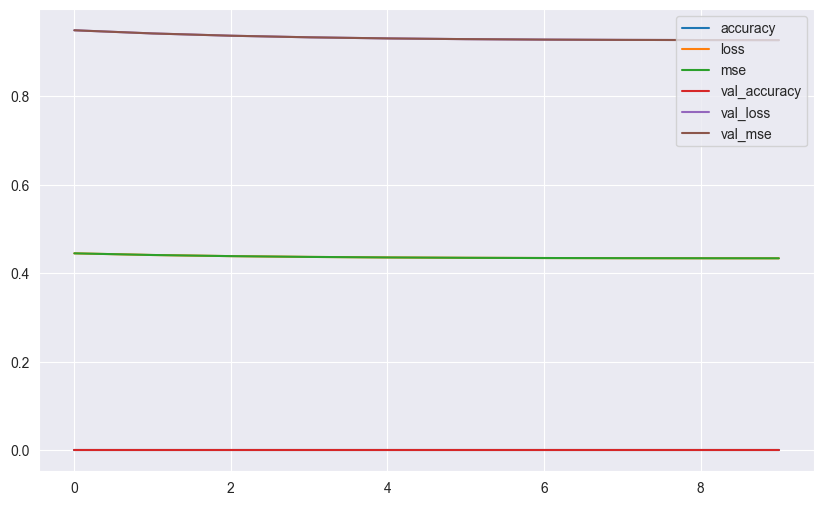

In [80]:
evaluate_model(cglp_1, cglp_1_history, data_consumo[['Gas licuado de petróleo']], 'Gas licuado de petroleo', train_x_cglp, train_y_cglp, test_x_cglp, test_y_cglp)

##### LSTM 2

In [81]:
cglp_2 = create_lstm_model(train_x_cglp, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
cglp_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cglp_2_history = get_history(cglp_2, train_x_cglp, train_y_cglp, name='cglp 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 9s - 57ms/step - accuracy: 0.0000e+00 - loss: 0.3882 - mse: 0.3882 - val_accuracy: 0.0000e+00 - val_loss: 0.7082 - val_mse: 0.7082
Epoch 2/100
153/153 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.3111 - mse: 0.3111 - val_accuracy: 0.0000e+00 - val_loss: 0.7351 - val_mse: 0.7351
Epoch 3/100
153/153 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.3071 - mse: 0.3071 - val_accuracy: 0.0000e+00 - val_loss: 0.7309 - val_mse: 0.7309
Epoch 4/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.3048 - mse: 0.3048 - val_accuracy: 0.0000e+00 - val_loss: 0.7665 - val_mse: 0.7665
Epoch 5/100
153/153 - 8s - 55ms/step - accuracy: 0.0000e+00 - loss: 0.3132 - mse: 0.3132 - val_accuracy: 0.0000e+00 - val_loss: 0.7791 - val_mse: 0.7791
Epoch 6/100
153/153 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.3120 - mse: 0.3120 - val_accuracy: 0.0000e+00 - val_loss: 0.7564 - val_mse: 0.7564
Epoch 7/100
153/153 - 8s - 50ms/step - accuracy: 0.0000e+00 - loss: 0.3050 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: 0.3299 - mse: 0.3299
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 1.2767 - mse: 1.2767


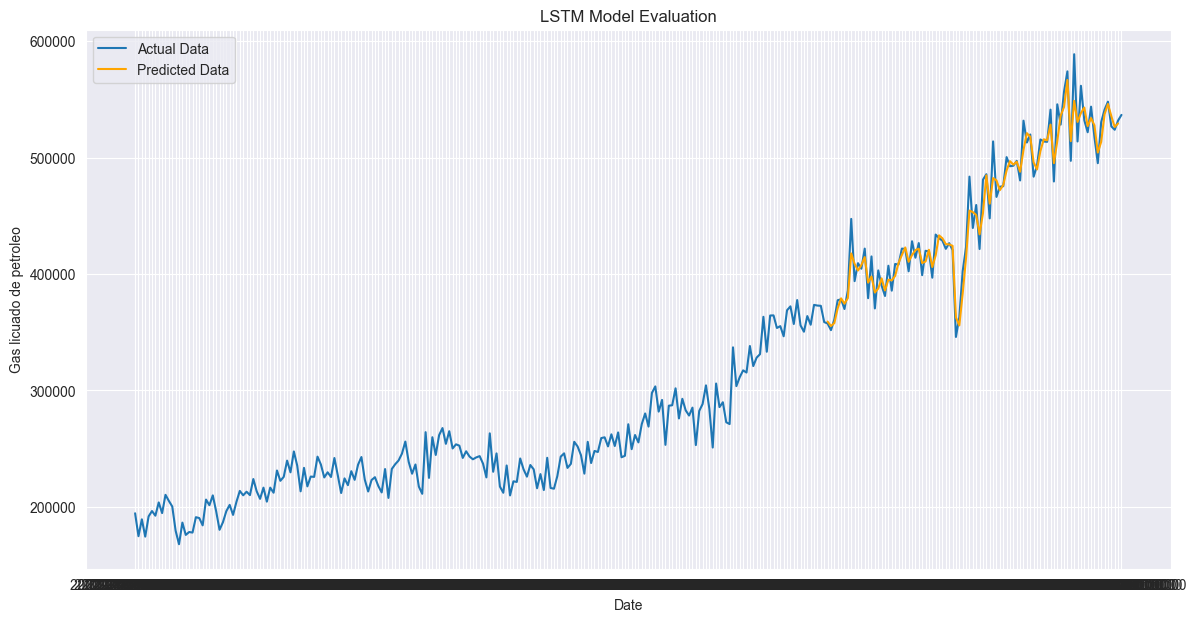

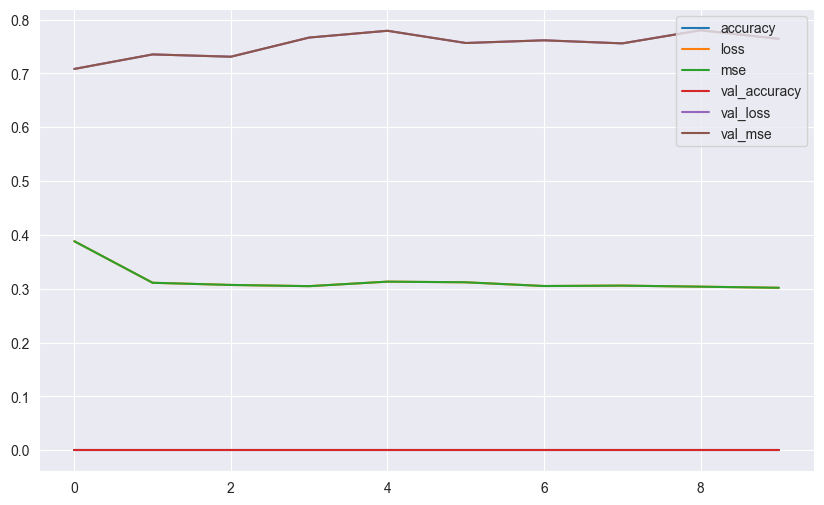

In [82]:
cglp_2_loaded = keras.models.load_model('./models/cglp 2.keras')
evaluate_model(cglp_2_loaded, cglp_2_history, data_consumo[['Gas licuado de petróleo']], 'Gas licuado de petroleo', train_x_cglp, train_y_cglp, test_x_cglp, test_y_cglp)

#### Consumo de Gasolina regular
##### ARIMA

RMSE: 53003.23576606372


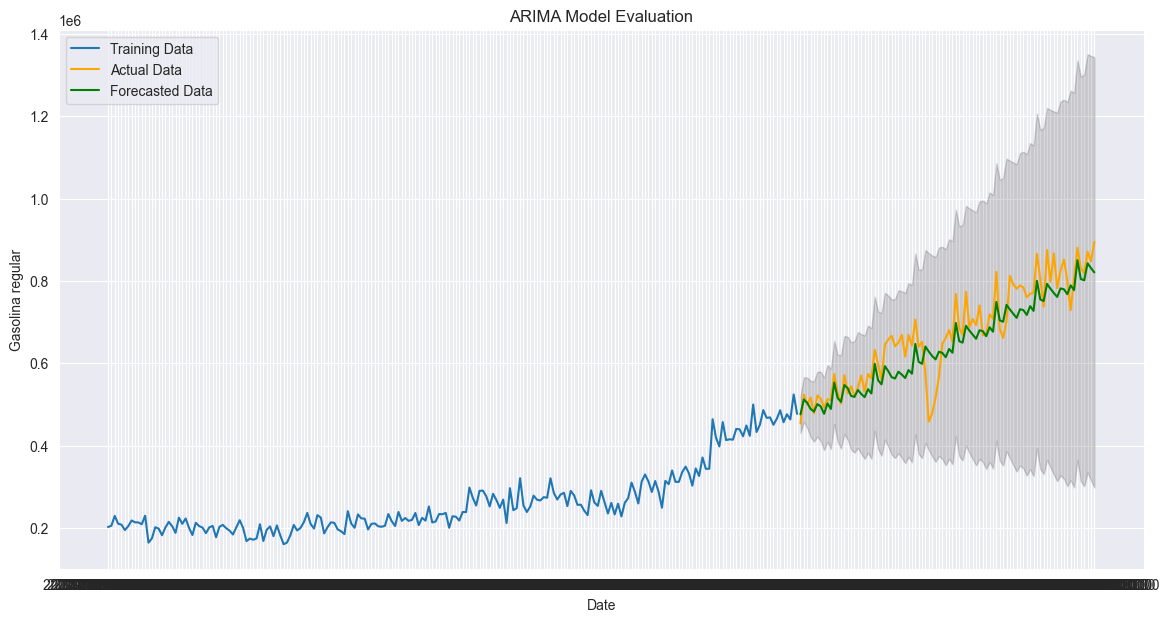

In [31]:
pcgr_313 = create_arima_model(train_consumo[['Gasolina regular']], p=3, d=1, q=3, s=12)
plot_arima_eval(pcgr_313, train_consumo[['Gasolina regular']], test_consumo[['Gasolina regular']], 'Gasolina regular')

In [83]:
train_x_cgr, train_y_cgr, test_x_cgr, test_y_cgr = data_preprocessing(data_consumo[['Gasolina regular']], sequence_length=1)

##### LSTM 1

In [84]:
cgr_1 = create_lstm_model_s(train_x_cgr)
cgr_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cgr_1_history = get_history(cgr_1, train_x_cgr, train_y_cgr, name='cgr 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 4s - 29ms/step - accuracy: 0.0000e+00 - loss: 0.3921 - mse: 0.3921 - val_accuracy: 0.0000e+00 - val_loss: 0.8201 - val_mse: 0.8201
Epoch 2/100
153/153 - 4s - 27ms/step - accuracy: 0.0000e+00 - loss: 0.3864 - mse: 0.3864 - val_accuracy: 0.0000e+00 - val_loss: 0.8125 - val_mse: 0.8125
Epoch 3/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.3814 - mse: 0.3814 - val_accuracy: 0.0000e+00 - val_loss: 0.8044 - val_mse: 0.8044
Epoch 4/100
153/153 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.3767 - mse: 0.3767 - val_accuracy: 0.0000e+00 - val_loss: 0.7961 - val_mse: 0.7961
Epoch 5/100
153/153 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.3722 - mse: 0.3722 - val_accuracy: 0.0000e+00 - val_loss: 0.7877 - val_mse: 0.7877
Epoch 6/100
153/153 - 4s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.3681 - mse: 0.3681 - val_accuracy: 0.0000e+00 - val_loss: 0.7795 - val_mse: 0.7795
Epoch 7/100
153/153 - 4s - 27ms/step - accuracy: 0.0000e+00 - loss: 0.3642 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.3822 - mse: 0.3822
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 1.7078 - mse: 1.7078


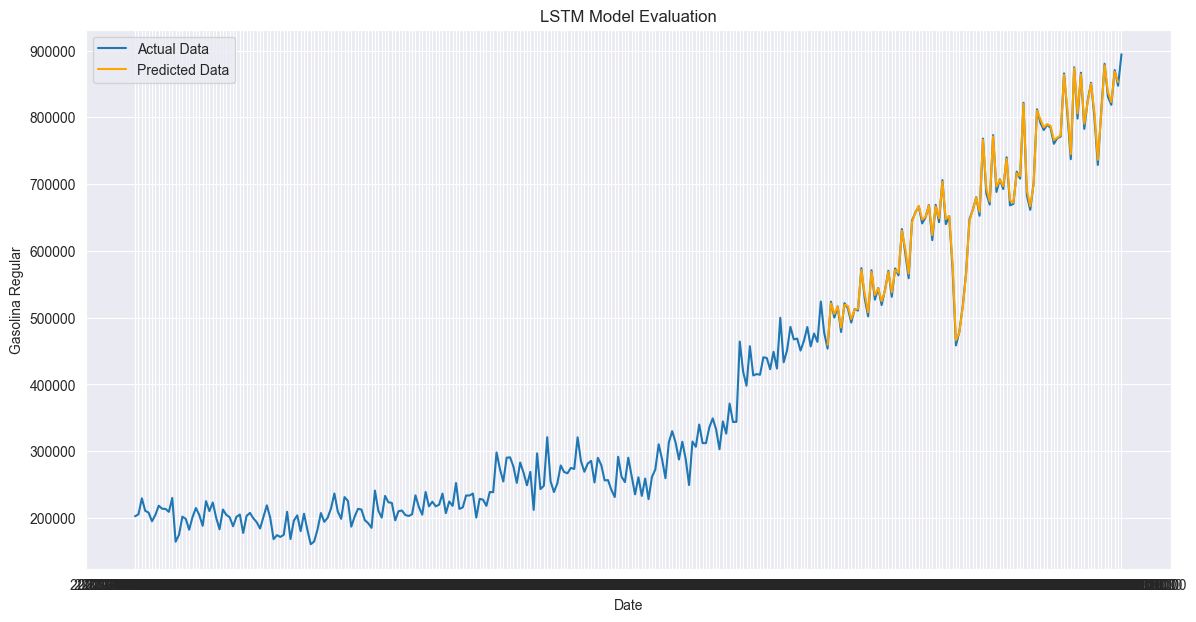

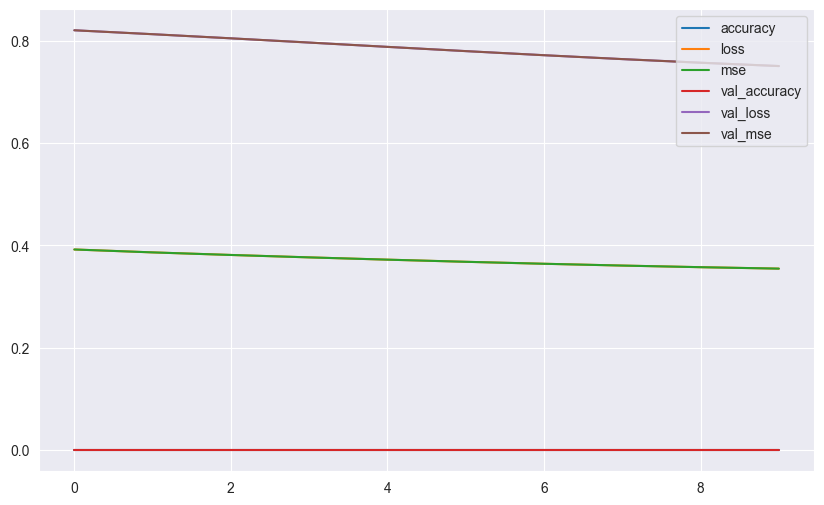

In [85]:
evaluate_model(cgr_1, cgr_1_history, data_consumo[['Gasolina regular']], 'Gasolina Regular', train_x_cgr, train_y_cgr, test_x_cgr, test_y_cgr)

##### LSTM 2

In [86]:
cgr_2 = create_lstm_model(train_x_cgr, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
cgr_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cgr_2_history = get_history(cgr_2, train_x_cgr, train_y_cgr, name='cgr 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 9s - 59ms/step - accuracy: 0.0000e+00 - loss: 0.3776 - mse: 0.3776 - val_accuracy: 0.0000e+00 - val_loss: 0.7069 - val_mse: 0.7069
Epoch 2/100
153/153 - 8s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.3355 - mse: 0.3355 - val_accuracy: 0.0000e+00 - val_loss: 0.7086 - val_mse: 0.7086
Epoch 3/100
153/153 - 8s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.3296 - mse: 0.3296 - val_accuracy: 0.0000e+00 - val_loss: 0.7001 - val_mse: 0.7001
Epoch 4/100
153/153 - 8s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.3301 - mse: 0.3301 - val_accuracy: 0.0000e+00 - val_loss: 0.7452 - val_mse: 0.7452
Epoch 5/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.3244 - mse: 0.3244 - val_accuracy: 0.0000e+00 - val_loss: 0.7103 - val_mse: 0.7103
Epoch 6/100
153/153 - 9s - 58ms/step - accuracy: 0.0000e+00 - loss: 0.3297 - mse: 0.3297 - val_accuracy: 0.0000e+00 - val_loss: 0.7366 - val_mse: 0.7366
Epoch 7/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.3316 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.3314 - mse: 0.3314
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 1.5106 - mse: 1.5106


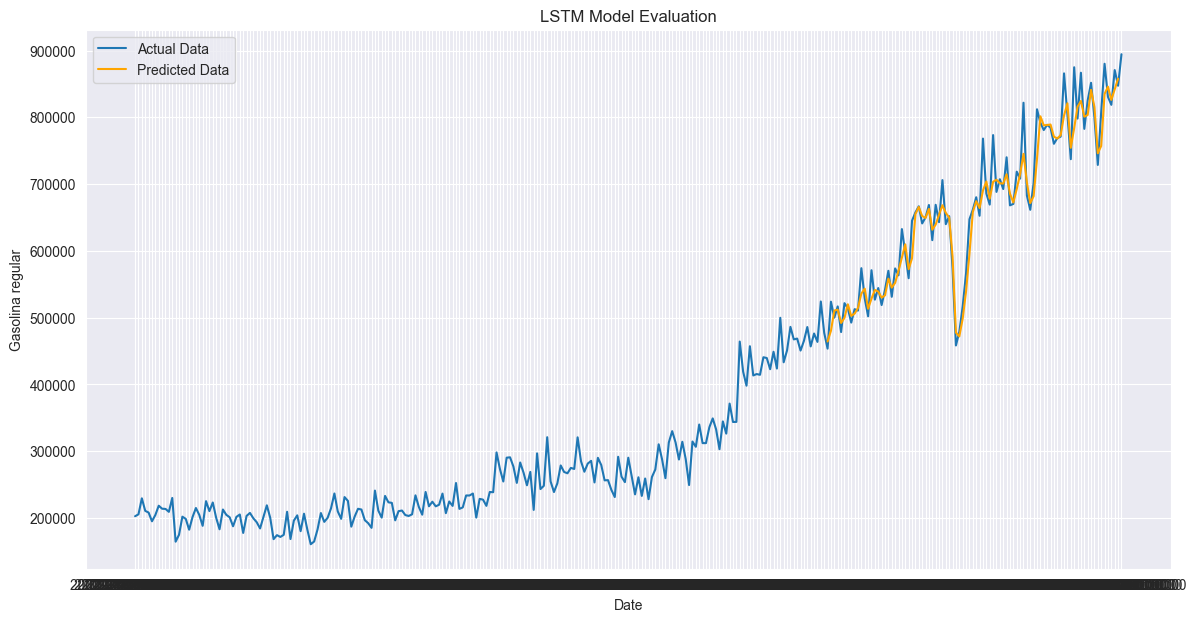

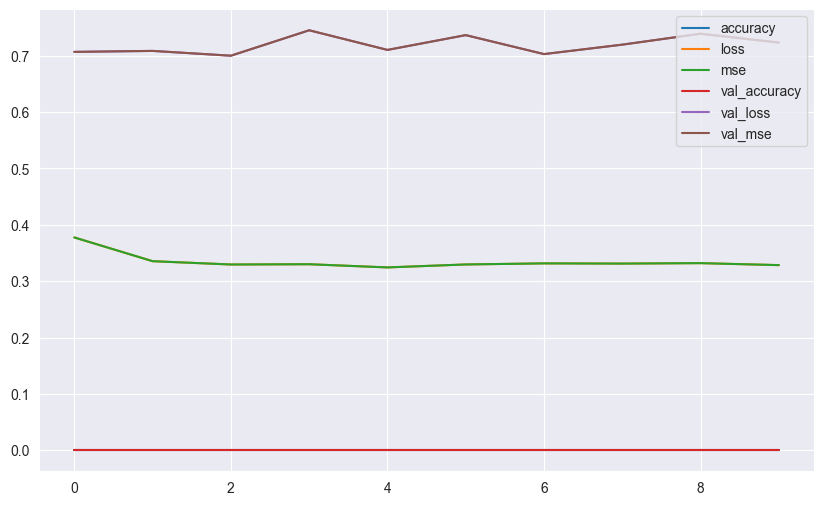

In [87]:
cgr_2_loaded = keras.models.load_model('./models/cgr 2.keras')
evaluate_model(cgr_2_loaded, cgr_2_history, data_consumo[['Gasolina regular']], 'Gasolina regular', train_x_cgr, train_y_cgr, test_x_cgr, test_y_cgr)

#### Consumo de Gasolina superior
##### ARIMA

RMSE: 66278.8596267956


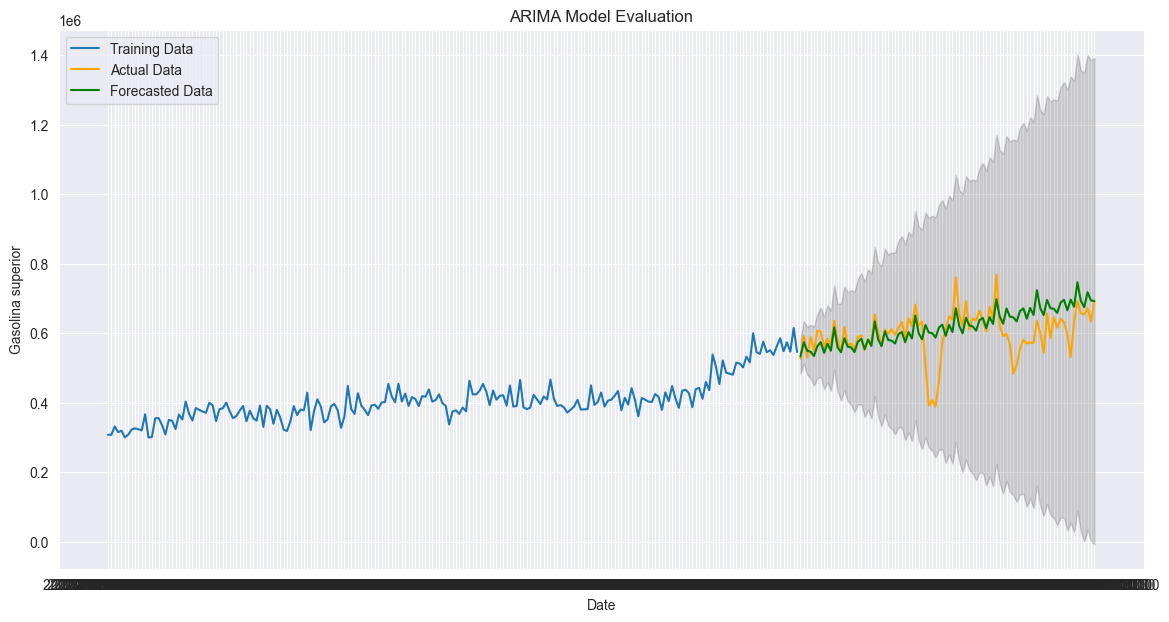

In [32]:
pcgs_611 = create_arima_model(train_consumo[['Gasolina superior']], p=6, d=1, q=1, s=12)
plot_arima_eval(pcgs_611, train_consumo[['Gasolina superior']], test_consumo[['Gasolina superior']], 'Gasolina superior')

In [88]:
train_x_cgs, train_y_cgs, test_x_cgs, test_y_cgs = data_preprocessing(data_consumo[['Gasolina superior']], sequence_length=1)

##### LSTM 1

In [89]:
cgs_1 = create_lstm_model_s(train_x_cgs)
cgs_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cgs_1_history = get_history(cgs_1, train_x_cgs, train_y_cgs, name='cgs 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 4s - 28ms/step - accuracy: 0.0000e+00 - loss: 0.6706 - mse: 0.6706 - val_accuracy: 0.0000e+00 - val_loss: 0.8823 - val_mse: 0.8823
Epoch 2/100
153/153 - 4s - 26ms/step - accuracy: 0.0000e+00 - loss: 0.6622 - mse: 0.6622 - val_accuracy: 0.0000e+00 - val_loss: 0.8704 - val_mse: 0.8704
Epoch 3/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6559 - mse: 0.6559 - val_accuracy: 0.0000e+00 - val_loss: 0.8612 - val_mse: 0.8612
Epoch 4/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6509 - mse: 0.6509 - val_accuracy: 0.0000e+00 - val_loss: 0.8541 - val_mse: 0.8541
Epoch 5/100
153/153 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.6470 - mse: 0.6470 - val_accuracy: 0.0000e+00 - val_loss: 0.8484 - val_mse: 0.8484
Epoch 6/100
153/153 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6438 - mse: 0.6438 - val_accuracy: 0.0000e+00 - val_loss: 0.8438 - val_mse: 0.8438
Epoch 7/100
153/153 - 4s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.6411 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.6587 - mse: 0.6587
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.6516 - mse: 1.6516 


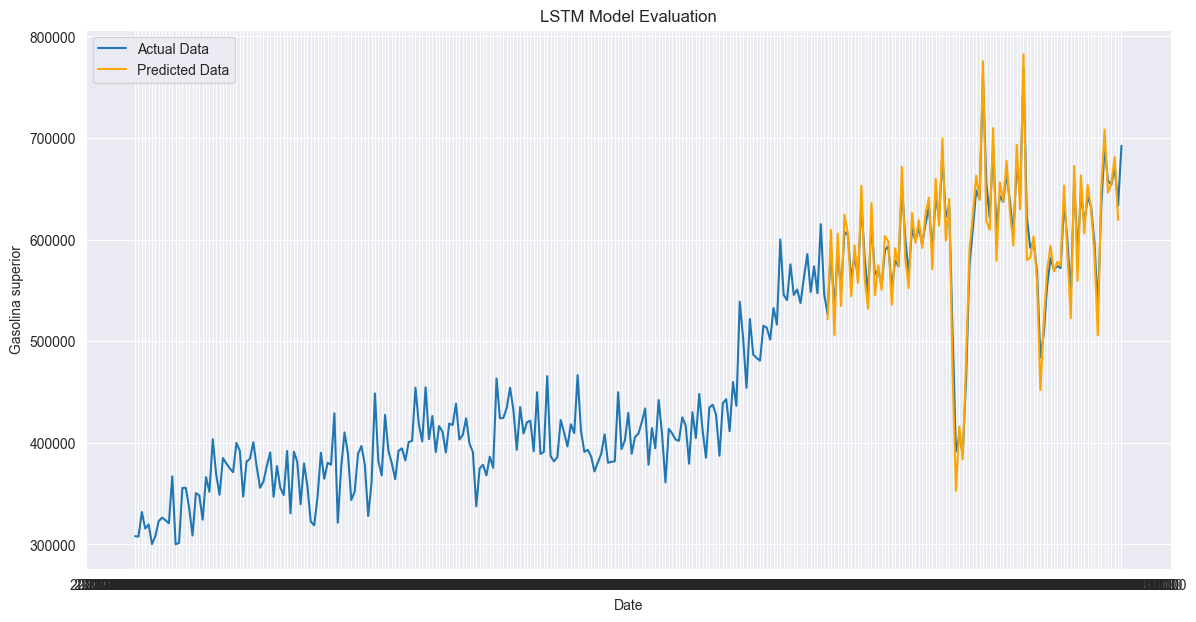

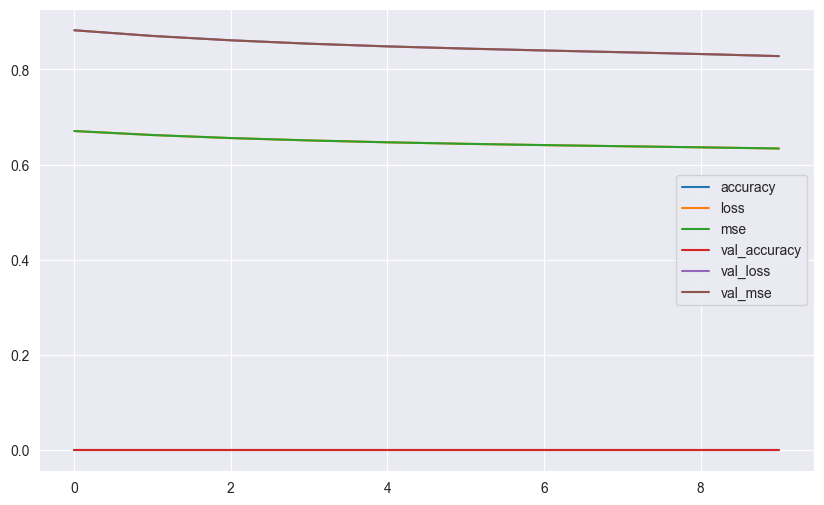

In [102]:
evaluate_model(cgs_1, cgs_1_history, data_consumo[['Gasolina superior']], 'Gasolina superior', train_x_cgs, train_y_cgs, test_x_cgs, test_y_cgs)

##### LSTM 2

In [91]:
cgs_2 = create_lstm_model(train_x_cgs, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
cgs_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
cgs_2_history = get_history(cgs_2, train_x_cgs, train_y_cgs, name='cgs 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
153/153 - 9s - 62ms/step - accuracy: 0.0000e+00 - loss: 0.5936 - mse: 0.5936 - val_accuracy: 0.0000e+00 - val_loss: 0.6156 - val_mse: 0.6156
Epoch 2/100
153/153 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.5101 - mse: 0.5101 - val_accuracy: 0.0000e+00 - val_loss: 0.6278 - val_mse: 0.6278
Epoch 3/100
153/153 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.5047 - mse: 0.5047 - val_accuracy: 0.0000e+00 - val_loss: 0.6403 - val_mse: 0.6403
Epoch 4/100
153/153 - 8s - 55ms/step - accuracy: 0.0000e+00 - loss: 0.4943 - mse: 0.4943 - val_accuracy: 0.0000e+00 - val_loss: 0.6367 - val_mse: 0.6367
Epoch 5/100
153/153 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.4975 - mse: 0.4975 - val_accuracy: 0.0000e+00 - val_loss: 0.6678 - val_mse: 0.6678
Epoch 6/100
153/153 - 9s - 57ms/step - accuracy: 0.0000e+00 - loss: 0.5102 - mse: 0.5102 - val_accuracy: 0.0000e+00 - val_loss: 0.6340 - val_mse: 0.6340
Epoch 7/100
153/153 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.5013 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.5055 - mse: 0.5055
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 1.3258 - mse: 1.3258


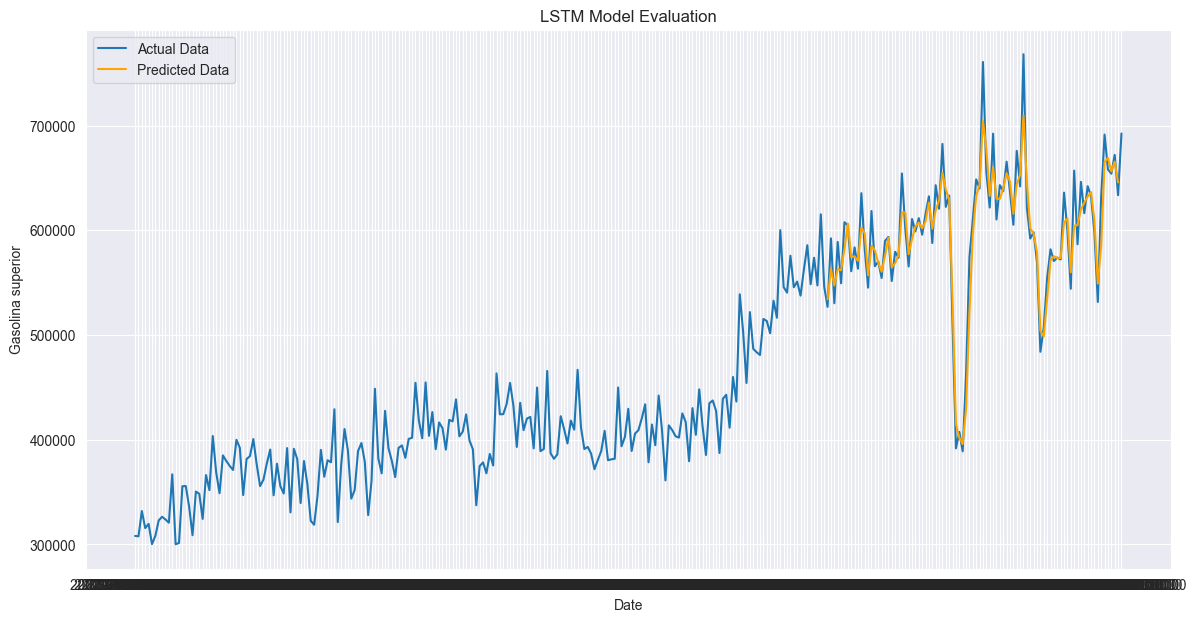

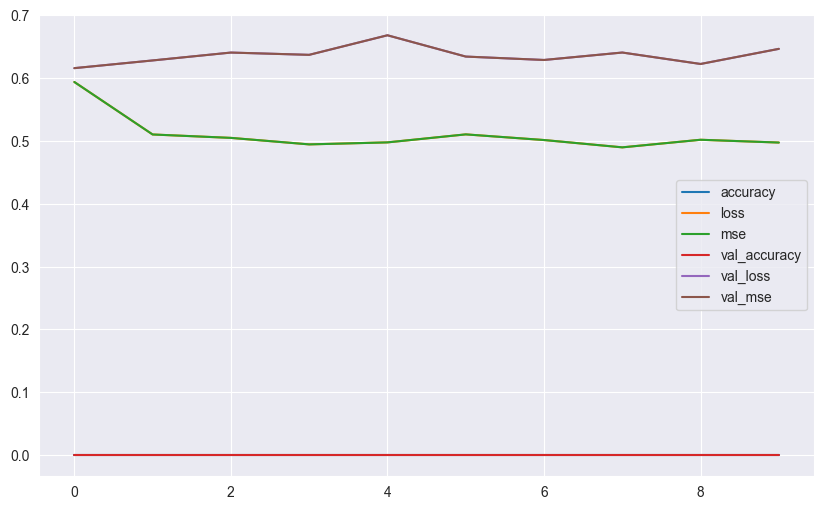

In [92]:
cgs_2_loaded = keras.models.load_model('./models/cgs 2.keras')
evaluate_model(cgs_2_loaded, cgs_2_history, data_consumo[['Gasolina superior']], 'Gasolina superior', train_x_cgs, train_y_cgs, test_x_cgs, test_y_cgs)

### Modelos de volumen de importacion
#### Volumen de importacion de Diesel
##### ARIMA

RMSE: 227981.36898385404


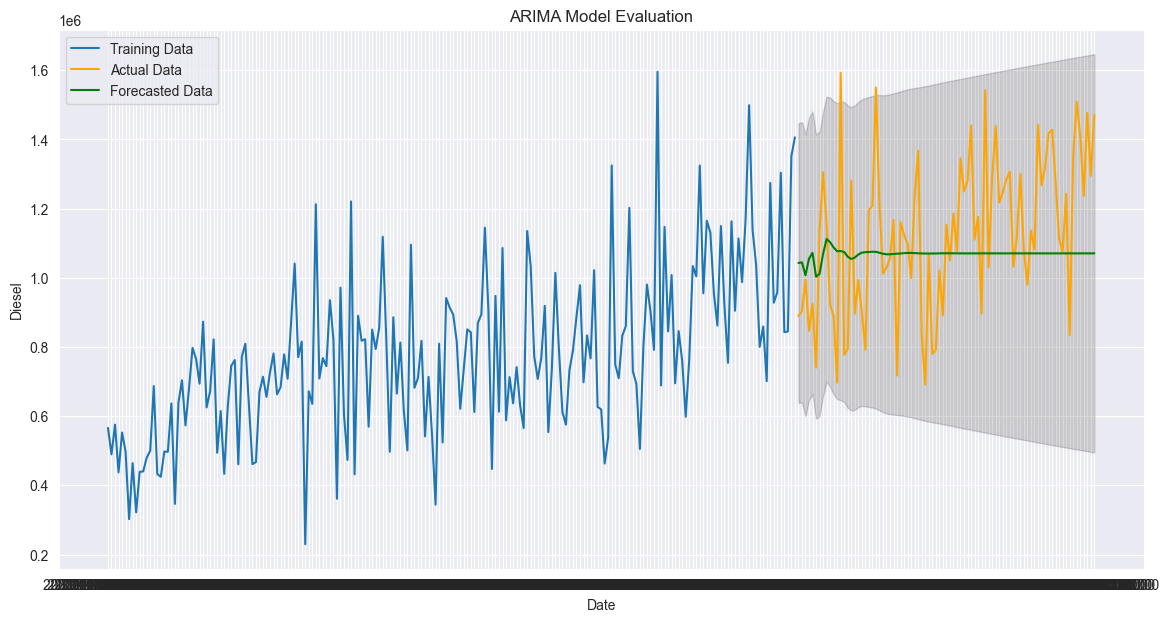

In [33]:
pid_811 = create_arima_model(train_imp[['Diesel']], p=8, d=1, q=1)
plot_arima_eval(pid_811, train_imp[['Diesel']], test_imp[['Diesel']], 'Diesel')

In [93]:
train_x_id, train_y_id, test_x_id, test_y_id = data_preprocessing(data_impor[['Diesel']], sequence_length=1)

##### LSTM 1

In [94]:
id_1 = create_lstm_model_s(train_x_id)
id_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
id_1_history = get_history(id_1, train_x_id, train_y_id, name='id 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 4s - 29ms/step - accuracy: 0.0000e+00 - loss: 1.1302 - mse: 1.1302 - val_accuracy: 0.0000e+00 - val_loss: 1.5477 - val_mse: 1.5477
Epoch 2/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.0913 - mse: 1.0913 - val_accuracy: 0.0000e+00 - val_loss: 1.5028 - val_mse: 1.5028
Epoch 3/100
146/146 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 1.0606 - mse: 1.0606 - val_accuracy: 0.0000e+00 - val_loss: 1.4662 - val_mse: 1.4662
Epoch 4/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.0350 - mse: 1.0350 - val_accuracy: 0.0000e+00 - val_loss: 1.4356 - val_mse: 1.4356
Epoch 5/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 1.0131 - mse: 1.0131 - val_accuracy: 0.0000e+00 - val_loss: 1.4094 - val_mse: 1.4094
Epoch 6/100
146/146 - 4s - 26ms/step - accuracy: 0.0000e+00 - loss: 0.9940 - mse: 0.9940 - val_accuracy: 0.0000e+00 - val_loss: 1.3865 - val_mse: 1.3865
Epoch 7/100
146/146 - 4s - 24ms/step - accuracy: 0.0000e+00 - loss: 0.9770 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.0212 - mse: 1.0212
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.2808 - mse: 1.2808


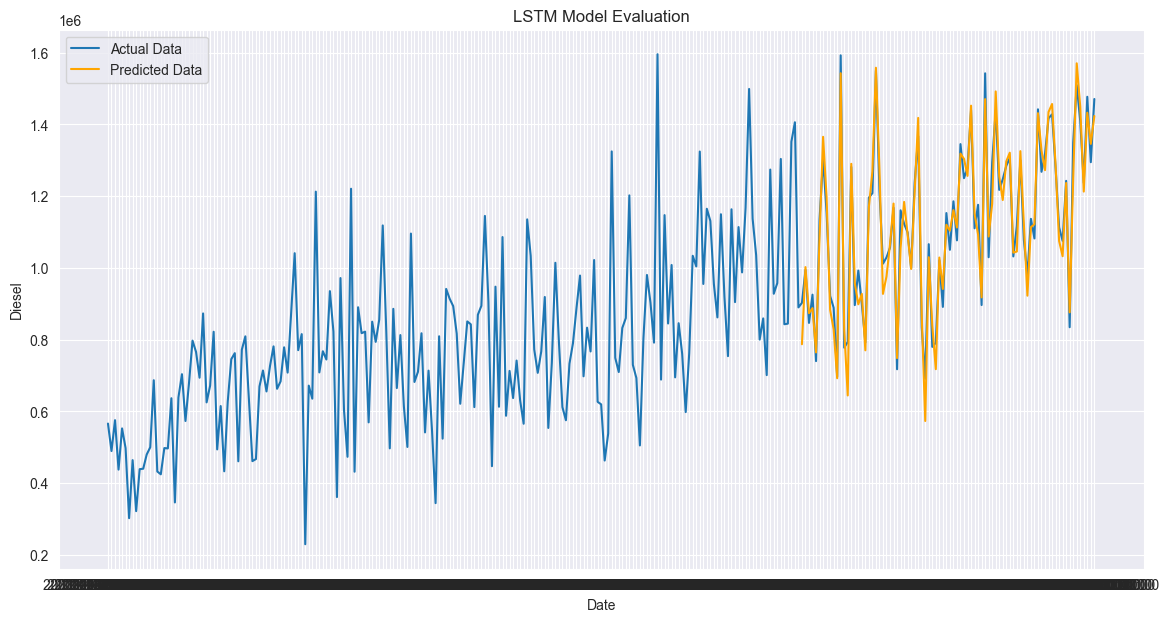

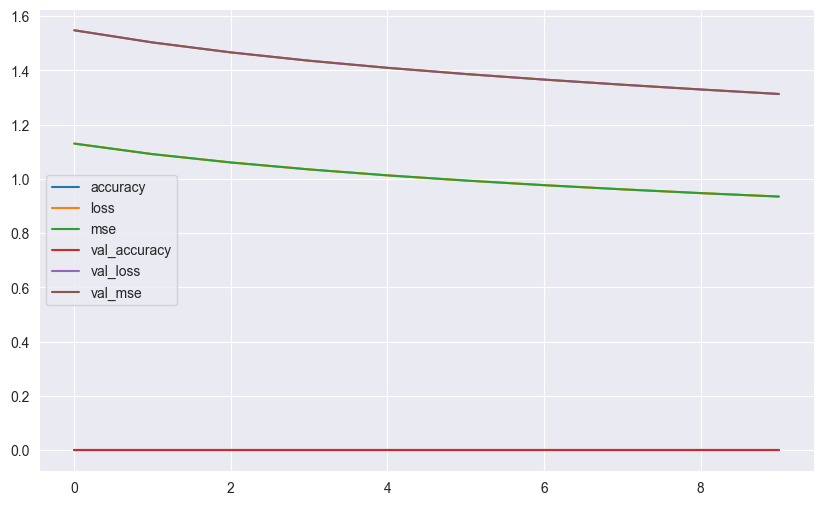

In [101]:
evaluate_model(id_1, id_1_history, data_impor[['Diesel']], 'Diesel', train_x_id, train_y_id, test_x_id, test_y_id, minus=0)

##### LSTM 2

In [103]:
id_2 = create_lstm_model(train_x_id, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
id_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
id_2_history = get_history(id_2, train_x_id, train_y_id, name='id 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 9s - 61ms/step - accuracy: 0.0000e+00 - loss: 0.7968 - mse: 0.7968 - val_accuracy: 0.0000e+00 - val_loss: 0.9253 - val_mse: 0.9253
Epoch 2/100
146/146 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.6685 - mse: 0.6685 - val_accuracy: 0.0000e+00 - val_loss: 0.8862 - val_mse: 0.8862
Epoch 3/100
146/146 - 8s - 52ms/step - accuracy: 0.0000e+00 - loss: 0.6694 - mse: 0.6694 - val_accuracy: 0.0000e+00 - val_loss: 0.8696 - val_mse: 0.8696
Epoch 4/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.6546 - mse: 0.6546 - val_accuracy: 0.0000e+00 - val_loss: 0.8688 - val_mse: 0.8688
Epoch 5/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.6420 - mse: 0.6420 - val_accuracy: 0.0000e+00 - val_loss: 0.8620 - val_mse: 0.8620
Epoch 6/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.6516 - mse: 0.6516 - val_accuracy: 0.0000e+00 - val_loss: 0.8632 - val_mse: 0.8632
Epoch 7/100
146/146 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.6535 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.5753 - mse: 0.5753
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.7790 - mse: 0.7790


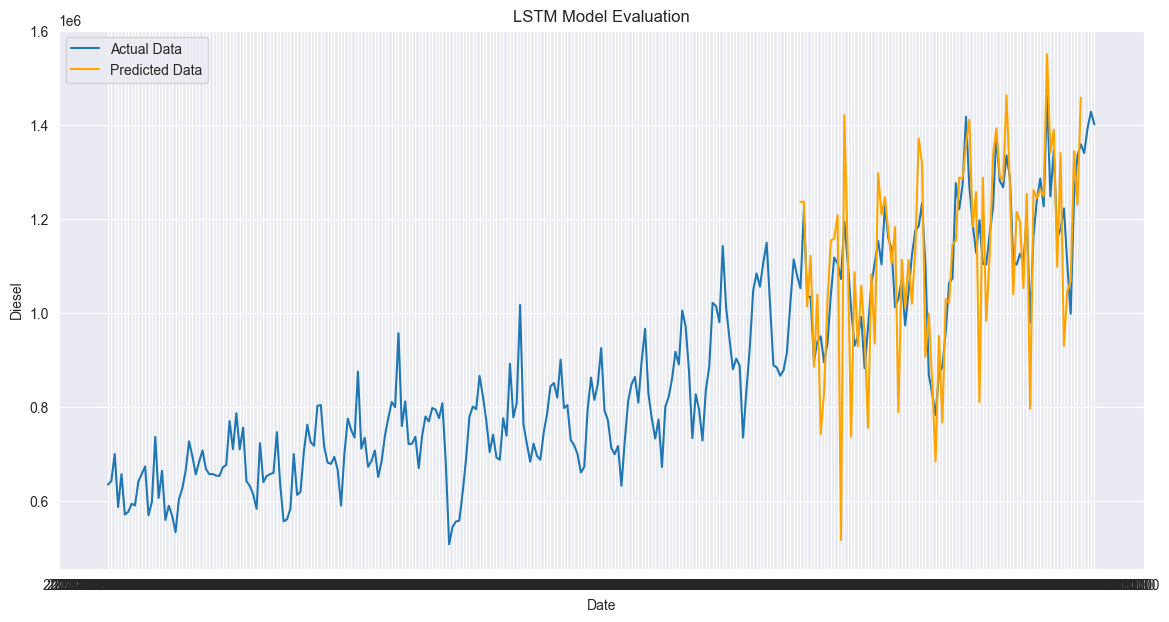

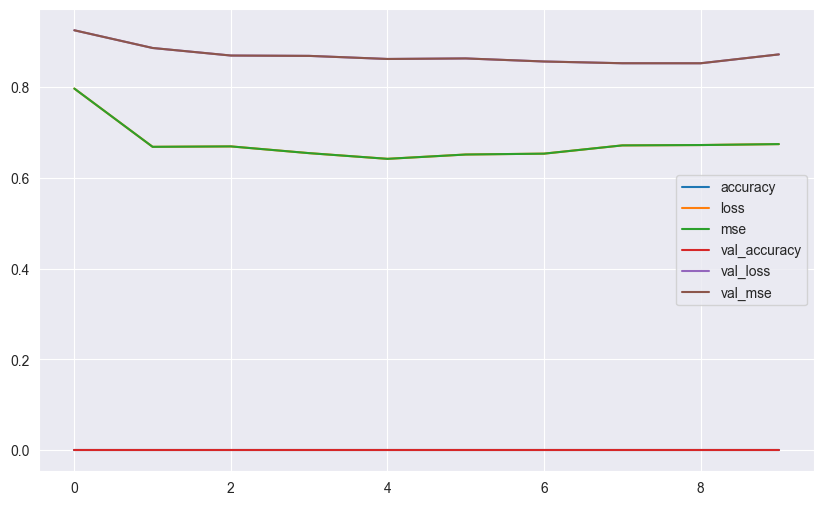

In [106]:
id_2_loaded = keras.models.load_model('./models/id 2.keras')
evaluate_model(id_2_loaded, id_2_history, data_consumo[['Diesel']], 'Diesel', train_x_id, train_y_id, test_x_id, test_y_id, minus=4)

#### Volumen de importacion de Gas licuado de petroleo
##### ARIMA

RMSE: 167456.55170594435


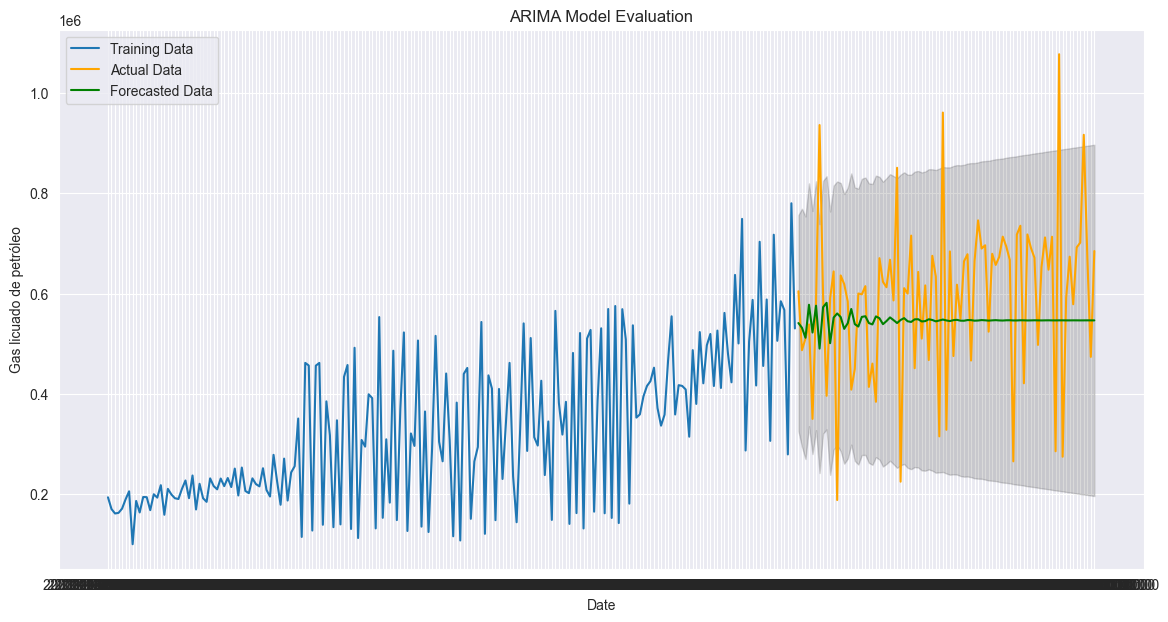

In [34]:
piglp_419 = create_arima_model(train_imp[['Gas licuado de petróleo']], p=4, d=1, q=9)
plot_arima_eval(piglp_419, train_imp[['Gas licuado de petróleo']], test_imp[['Gas licuado de petróleo']], 'Gas licuado de petróleo')

In [107]:
train_x_iglp, train_y_iglp, test_x_iglp, test_y_iglp = data_preprocessing(data_impor[['Gas licuado de petróleo']], sequence_length=1)

##### LSTM 1

In [108]:
iglp_1 = create_lstm_model_s(train_x_iglp)
iglp_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
iglp_1_history = get_history(iglp_1, train_x_iglp, train_y_iglp, name='iglp 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 5s - 32ms/step - accuracy: 0.0000e+00 - loss: 0.6796 - mse: 0.6796 - val_accuracy: 0.0000e+00 - val_loss: 0.5597 - val_mse: 0.5597
Epoch 2/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6422 - mse: 0.6422 - val_accuracy: 0.0000e+00 - val_loss: 0.5282 - val_mse: 0.5282
Epoch 3/100
146/146 - 4s - 27ms/step - accuracy: 0.0000e+00 - loss: 0.6092 - mse: 0.6092 - val_accuracy: 0.0000e+00 - val_loss: 0.4994 - val_mse: 0.4994
Epoch 4/100
146/146 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.5793 - mse: 0.5793 - val_accuracy: 0.0000e+00 - val_loss: 0.4734 - val_mse: 0.4734
Epoch 5/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.5528 - mse: 0.5528 - val_accuracy: 0.0000e+00 - val_loss: 0.4506 - val_mse: 0.4506
Epoch 6/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.5299 - mse: 0.5299 - val_accuracy: 0.0000e+00 - val_loss: 0.4312 - val_mse: 0.4312
Epoch 7/100
146/146 - 4s - 25ms/step - accuracy: 0.0000e+00 - loss: 0.5107 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.3157 - mse: 0.3157 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.8312 - mse: 0.8312 


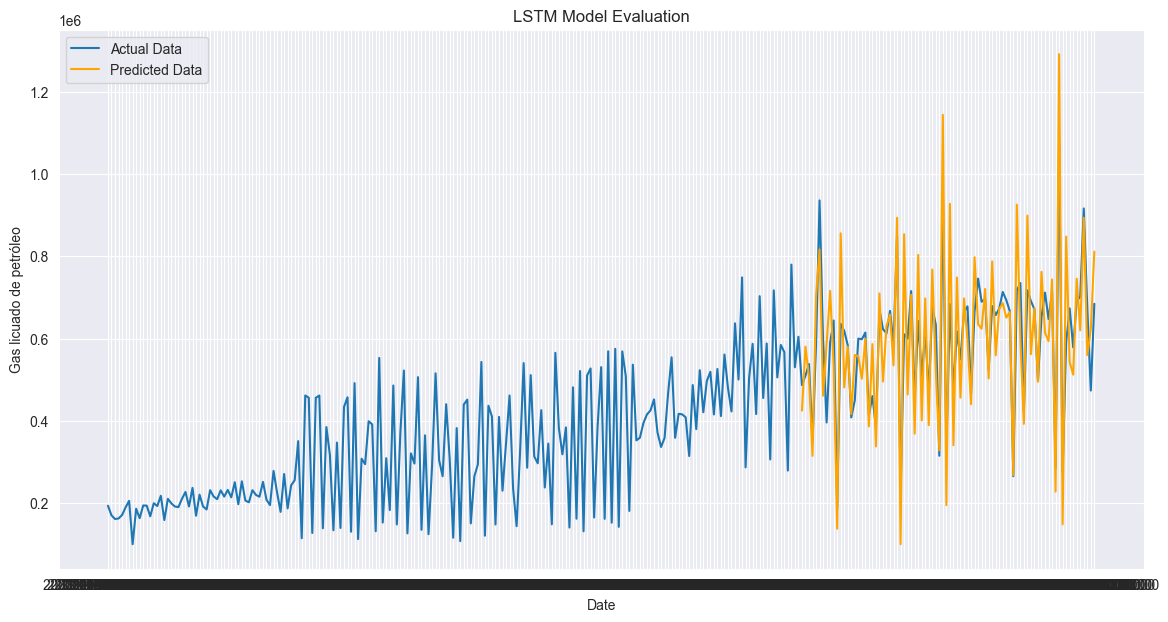

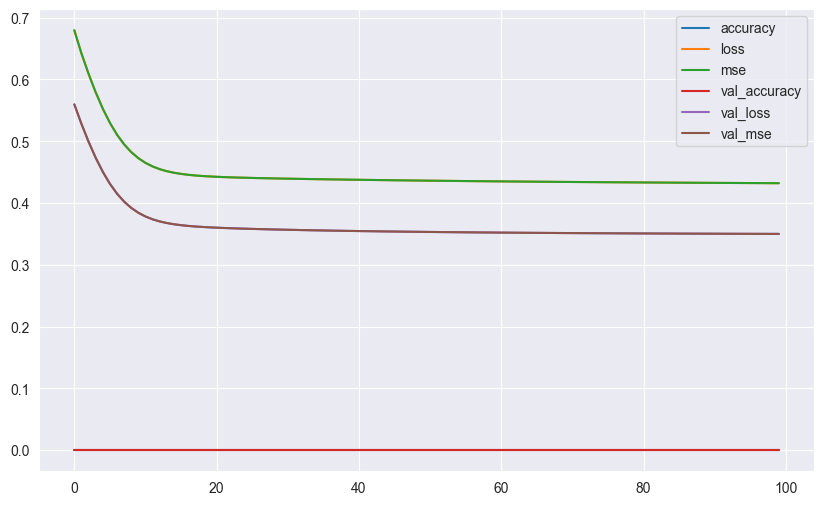

In [117]:
evaluate_model(iglp_1, iglp_1_history, data_impor[['Gas licuado de petróleo']], 'Gas licuado de petróleo', train_x_iglp, train_y_iglp, test_x_iglp, test_y_iglp, minus=0)

In [109]:
iglp_2 = create_lstm_model(train_x_iglp, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
iglp_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
iglp_2_history = get_history(iglp_2, train_x_iglp, train_y_iglp, name='iglp 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.5672 - mse: 0.5672 - val_accuracy: 0.0000e+00 - val_loss: 0.3526 - val_mse: 0.3526
Epoch 2/100
146/146 - 9s - 61ms/step - accuracy: 0.0000e+00 - loss: 0.4498 - mse: 0.4498 - val_accuracy: 0.0000e+00 - val_loss: 0.3540 - val_mse: 0.3540
Epoch 3/100
146/146 - 7s - 49ms/step - accuracy: 0.0000e+00 - loss: 0.4570 - mse: 0.4570 - val_accuracy: 0.0000e+00 - val_loss: 0.3530 - val_mse: 0.3530
Epoch 4/100
146/146 - 8s - 54ms/step - accuracy: 0.0000e+00 - loss: 0.4568 - mse: 0.4568 - val_accuracy: 0.0000e+00 - val_loss: 0.3525 - val_mse: 0.3525
Epoch 5/100
146/146 - 8s - 53ms/step - accuracy: 0.0000e+00 - loss: 0.4516 - mse: 0.4516 - val_accuracy: 0.0000e+00 - val_loss: 0.3549 - val_mse: 0.3549
Epoch 6/100
146/146 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.4428 - mse: 0.4428 - val_accuracy: 0.0000e+00 - val_loss: 0.3536 - val_mse: 0.3536
Epoch 7/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4467 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.3152 - mse: 0.3152
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.8125 - mse: 0.8125


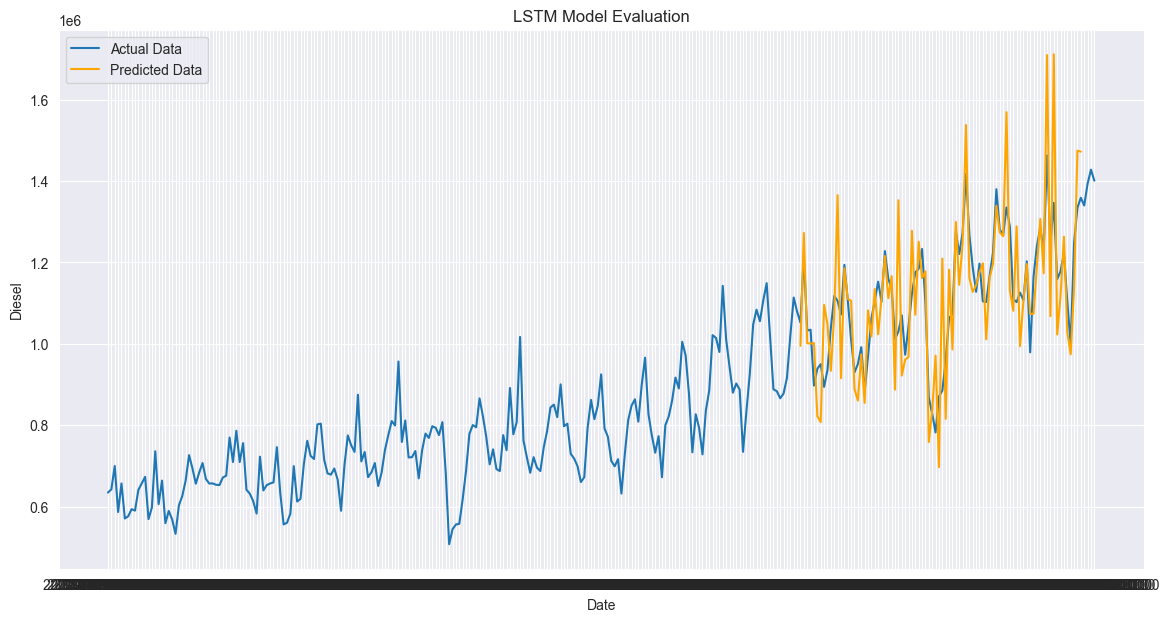

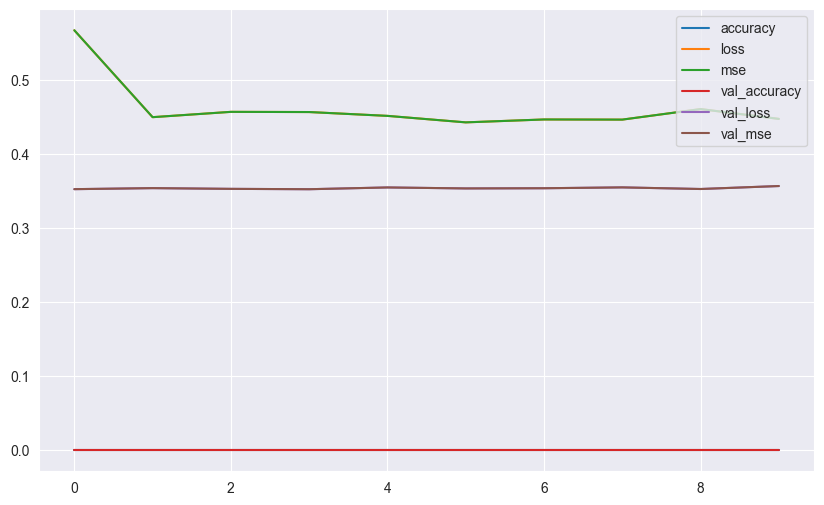

In [118]:
iglp_2_loaded = keras.models.load_model('./models/iglp 2.keras')
evaluate_model(iglp_2_loaded, iglp_2_history, data_consumo[['Diesel']], 'Diesel', train_x_iglp, train_y_iglp, test_x_iglp, test_y_iglp, minus=4)

#### Volumen de importacion Gasolina regular
##### ARIMA

RMSE: 146534.84796342126


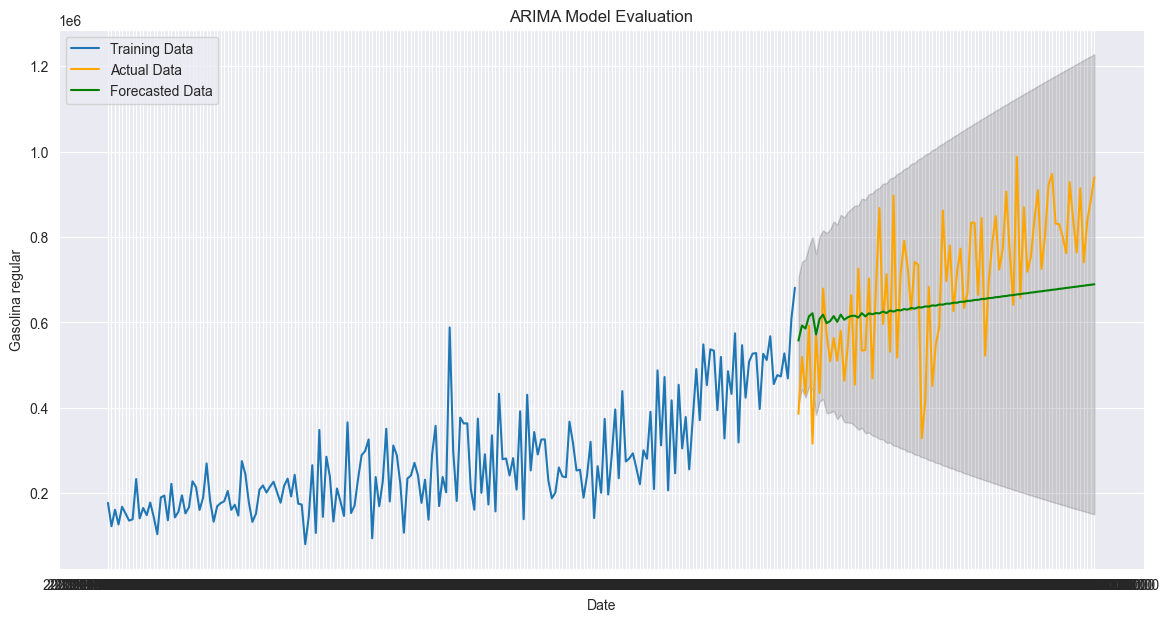

In [35]:
pigr_714 = create_arima_model(train_imp[['Gasolina regular']], p=7, d=1, q=4)
plot_arima_eval(pigr_714, train_imp[['Gasolina regular']], test_imp[['Gasolina regular']], 'Gasolina regular')

In [110]:
train_x_igr, train_y_igr, test_x_igr, test_y_igr = data_preprocessing(data_impor[['Gasolina regular']], sequence_length=1)

##### LSTM 1

In [111]:
igr_1 = create_lstm_model_s(train_x_igr)
igr_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
igr_1_history = get_history(igr_1, train_x_igr, train_y_igr, name='igr 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.6784 - mse: 0.6784 - val_accuracy: 0.0000e+00 - val_loss: 1.0208 - val_mse: 1.0208
Epoch 2/100
146/146 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.6702 - mse: 0.6702 - val_accuracy: 0.0000e+00 - val_loss: 1.0069 - val_mse: 1.0069
Epoch 3/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6650 - mse: 0.6650 - val_accuracy: 0.0000e+00 - val_loss: 0.9971 - val_mse: 0.9971
Epoch 4/100
146/146 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.6613 - mse: 0.6613 - val_accuracy: 0.0000e+00 - val_loss: 0.9898 - val_mse: 0.9898
Epoch 5/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.6583 - mse: 0.6583 - val_accuracy: 0.0000e+00 - val_loss: 0.9834 - val_mse: 0.9834
Epoch 6/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.6553 - mse: 0.6553 - val_accuracy: 0.0000e+00 - val_loss: 0.9762 - val_mse: 0.9762
Epoch 7/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.6516 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.5638 - mse: 0.5638 
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.7752 - mse: 1.7752 


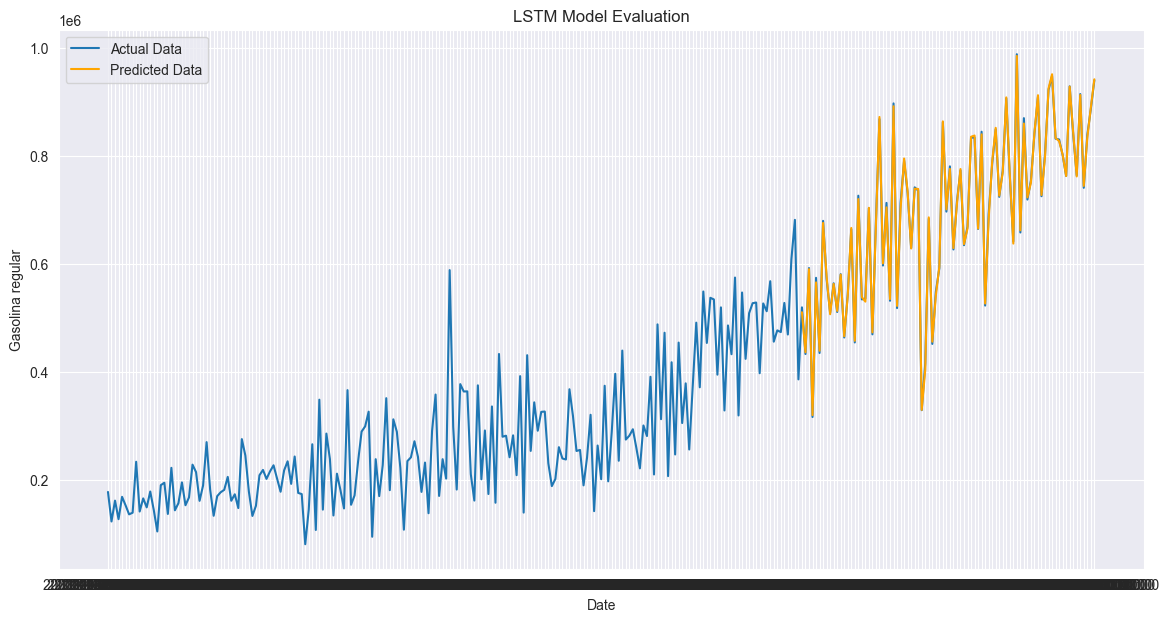

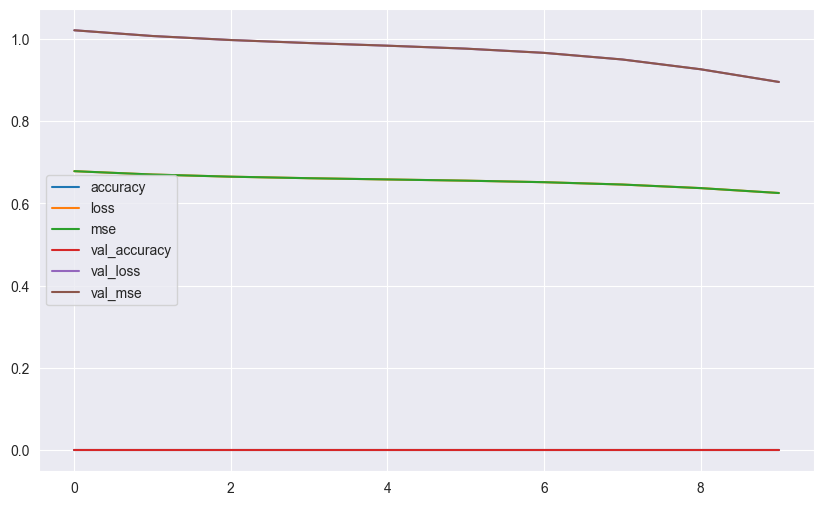

In [119]:
evaluate_model(igr_1, igr_1_history, data_impor[['Gasolina regular']], 'Gasolina regular', train_x_igr, train_y_igr, test_x_igr, test_y_igr, minus=0)

##### LSTM 2

In [112]:
igr_2 = create_lstm_model(train_x_igr, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
igr_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
igr_2_history = get_history(igr_2, train_x_igr, train_y_igr, name='igr 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.5385 - mse: 0.5385 - val_accuracy: 0.0000e+00 - val_loss: 0.4227 - val_mse: 0.4227
Epoch 2/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4259 - mse: 0.4259 - val_accuracy: 0.0000e+00 - val_loss: 0.3804 - val_mse: 0.3804
Epoch 3/100
146/146 - 7s - 48ms/step - accuracy: 0.0000e+00 - loss: 0.4144 - mse: 0.4144 - val_accuracy: 0.0000e+00 - val_loss: 0.3775 - val_mse: 0.3775
Epoch 4/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4334 - mse: 0.4334 - val_accuracy: 0.0000e+00 - val_loss: 0.3908 - val_mse: 0.3908
Epoch 5/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4252 - mse: 0.4252 - val_accuracy: 0.0000e+00 - val_loss: 0.3907 - val_mse: 0.3907
Epoch 6/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4186 - mse: 0.4186 - val_accuracy: 0.0000e+00 - val_loss: 0.3900 - val_mse: 0.3900
Epoch 7/100
146/146 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.4182 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.3256 - mse: 0.3256
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 1.0150 - mse: 1.0150


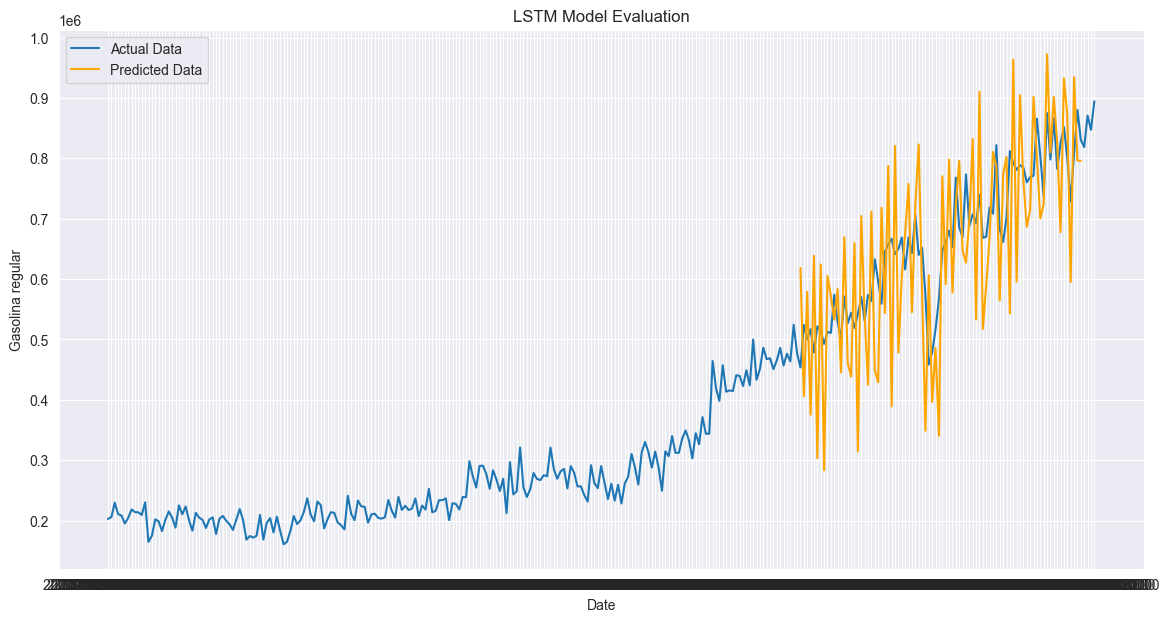

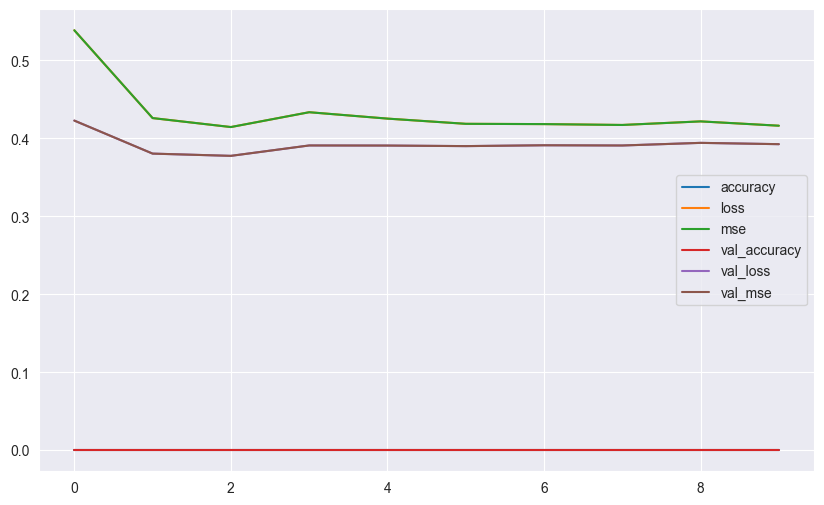

In [120]:
igr_2_loaded = keras.models.load_model('./models/igr 2.keras')
evaluate_model(igr_2_loaded, igr_2_history, data_consumo[['Gasolina regular']], 'Gasolina regular', train_x_igr, train_y_igr, test_x_igr, test_y_igr, minus=4)

#### Volumen de importacion Gasolina Superior
##### ARIMA

RMSE: 136171.4321088318


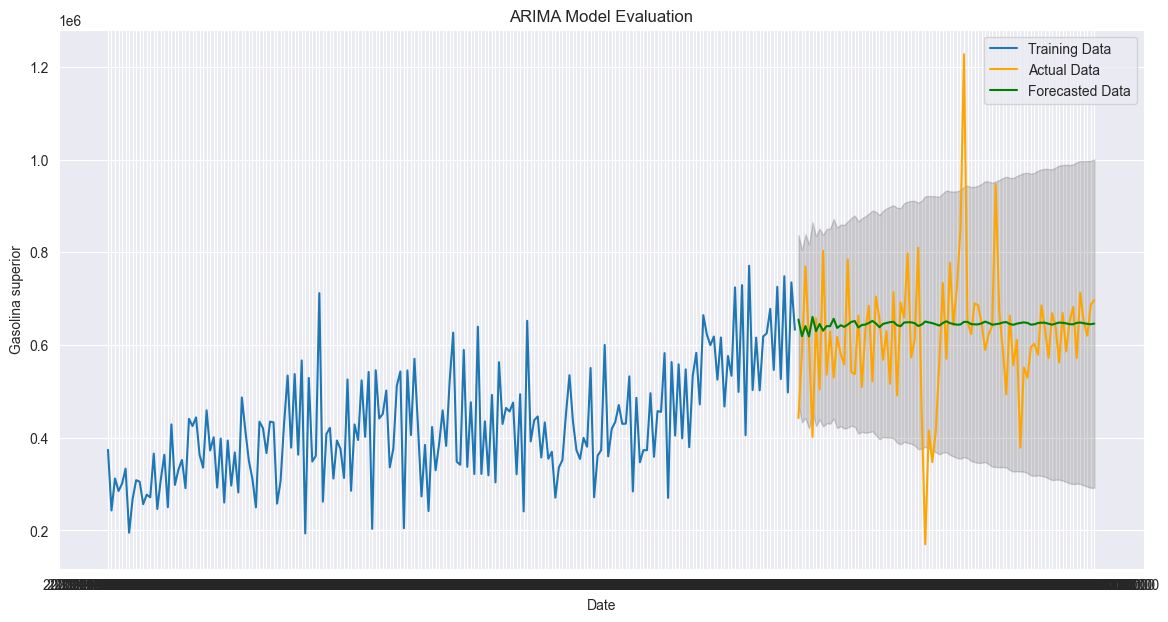

In [36]:
pigs_719 = create_arima_model(train_imp[['Gasolina superior']], p=7, d=1, q=9)
plot_arima_eval(pigs_719, train_imp[['Gasolina superior']], test_imp[['Gasolina superior']], 'Gasolina superior')

In [113]:
train_x_igs, train_y_igs, test_x_igs, test_y_igs = data_preprocessing(data_impor[['Gasolina superior']], sequence_length=1)

##### LSTM 1

In [114]:
igs_1 = create_lstm_model_s(train_x_igs)
igs_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
igs_1_history = get_history(igs_1, train_x_igs, train_y_igs, name='igs 1', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.8146 - mse: 0.8146 - val_accuracy: 0.0000e+00 - val_loss: 0.9239 - val_mse: 0.9239
Epoch 2/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.7802 - mse: 0.7802 - val_accuracy: 0.0000e+00 - val_loss: 0.8673 - val_mse: 0.8673
Epoch 3/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.7451 - mse: 0.7451 - val_accuracy: 0.0000e+00 - val_loss: 0.8081 - val_mse: 0.8081
Epoch 4/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.7096 - mse: 0.7096 - val_accuracy: 0.0000e+00 - val_loss: 0.7484 - val_mse: 0.7484
Epoch 5/100
146/146 - 3s - 20ms/step - accuracy: 0.0000e+00 - loss: 0.6753 - mse: 0.6753 - val_accuracy: 0.0000e+00 - val_loss: 0.6905 - val_mse: 0.6905
Epoch 6/100
146/146 - 3s - 21ms/step - accuracy: 0.0000e+00 - loss: 0.6434 - mse: 0.6434 - val_accuracy: 0.0000e+00 - val_loss: 0.6364 - val_mse: 0.6364
Epoch 7/100
146/146 - 3s - 22ms/step - accuracy: 0.0000e+00 - loss: 0.6151 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.7198 - mse: 0.7198
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 1.0019 - mse: 1.0019 


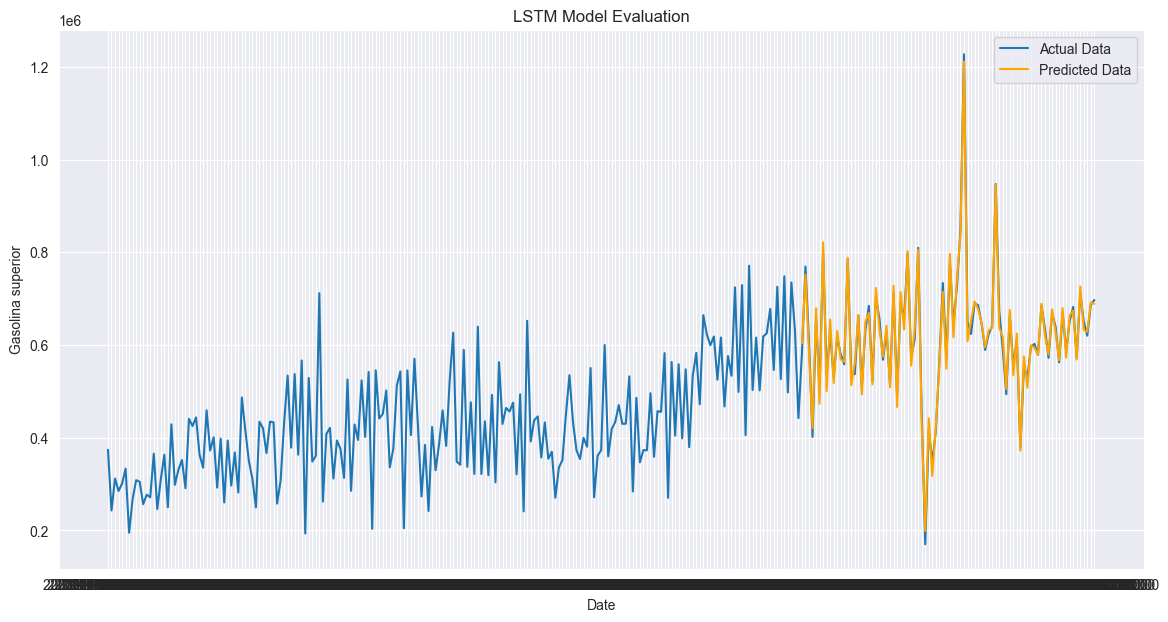

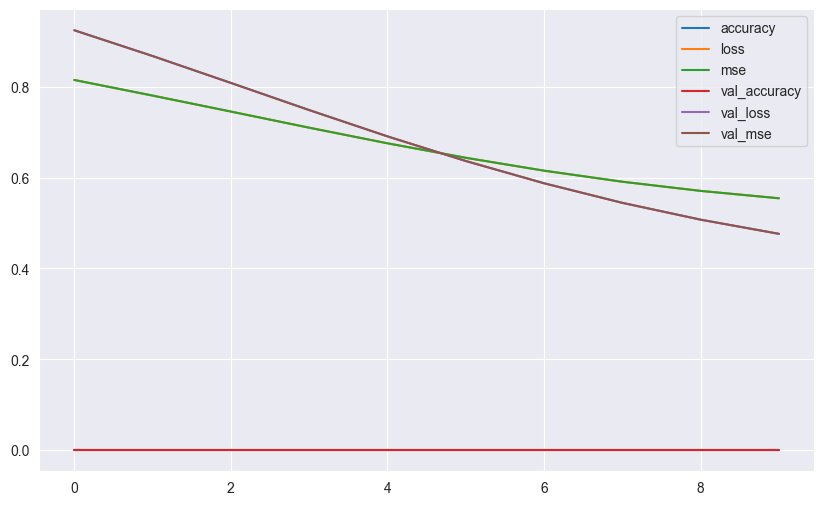

In [121]:
evaluate_model(igs_1, igs_1_history, data_impor[['Gasolina superior']], 'Gasolina superior', train_x_igs, train_y_igs, test_x_igs, test_y_igs, minus=0)

##### LSTM 2

In [115]:
igs_2 = create_lstm_model(train_x_igs, units=[128, 64, 32], dropout=[0.2, 0.2, 0.2])
igs_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy'], run_eagerly=True)
igs_2_history = get_history(igs_2, train_x_igs, train_y_igs, name='igs 2', epochs=100, batch_size=1, validation_rate=0.25)

Epoch 1/100
146/146 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.6697 - mse: 0.6697 - val_accuracy: 0.0000e+00 - val_loss: 0.3022 - val_mse: 0.3022
Epoch 2/100
146/146 - 7s - 47ms/step - accuracy: 0.0000e+00 - loss: 0.4983 - mse: 0.4983 - val_accuracy: 0.0000e+00 - val_loss: 0.3007 - val_mse: 0.3007
Epoch 3/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4890 - mse: 0.4890 - val_accuracy: 0.0000e+00 - val_loss: 0.3018 - val_mse: 0.3018
Epoch 4/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4891 - mse: 0.4891 - val_accuracy: 0.0000e+00 - val_loss: 0.2965 - val_mse: 0.2965
Epoch 5/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4832 - mse: 0.4832 - val_accuracy: 0.0000e+00 - val_loss: 0.2980 - val_mse: 0.2980
Epoch 6/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.5250 - mse: 0.5250 - val_accuracy: 0.0000e+00 - val_loss: 0.3037 - val_mse: 0.3037
Epoch 7/100
146/146 - 7s - 46ms/step - accuracy: 0.0000e+00 - loss: 0.4913 - mse: 

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.4105 - mse: 0.4105
Pérdida en Prueba
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.8311 - mse: 0.8311


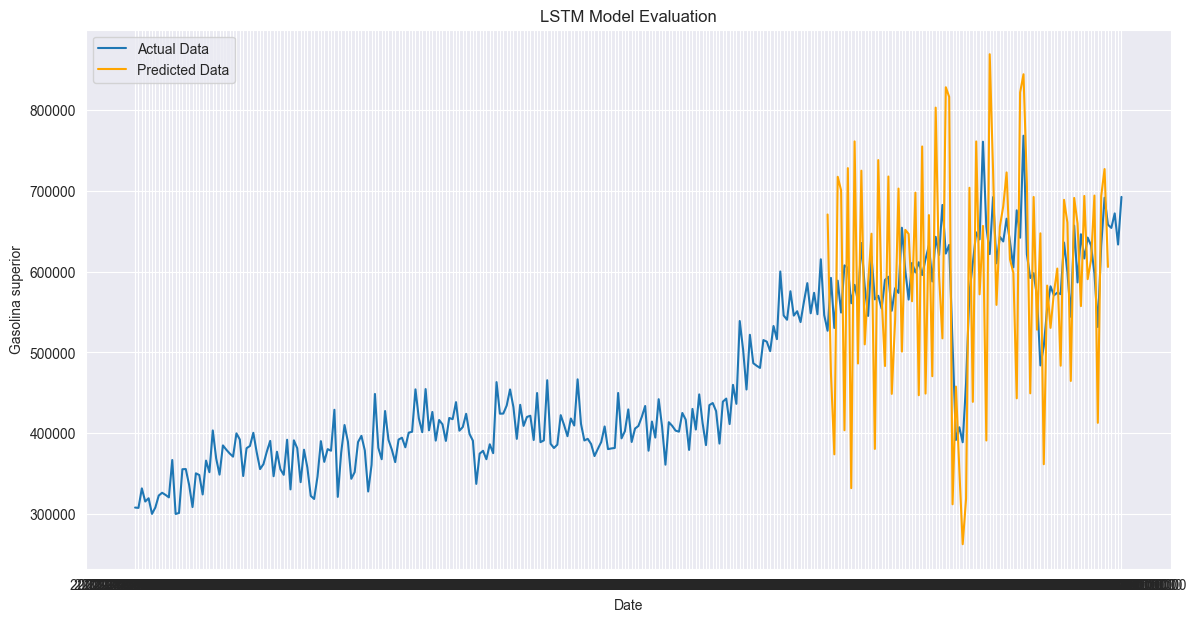

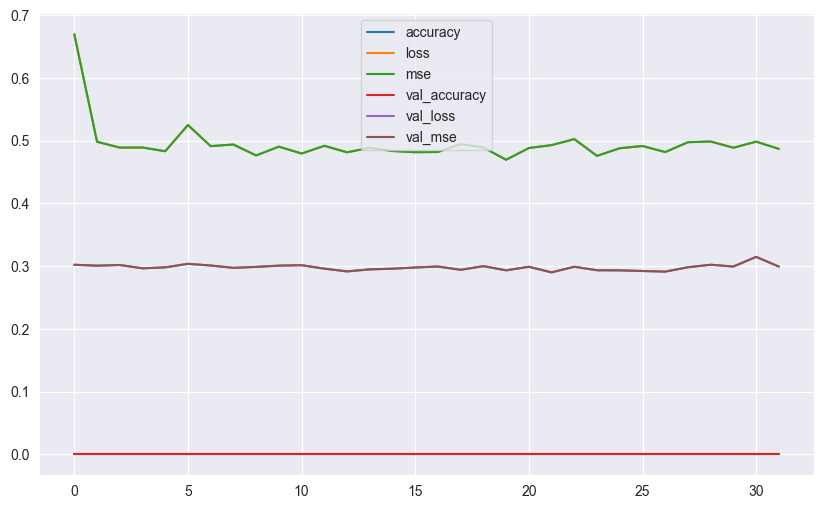

In [122]:
igs_2_loaded = keras.models.load_model('./models/igs 2.keras')
evaluate_model(igs_2_loaded, igs_2_history, data_consumo[['Gasolina superior']], 'Gasolina superior', train_x_igs, train_y_igs, test_x_igs, test_y_igs, minus=4)